In [51]:
import tensorflow as tf 
import os
import numpy as np
from keras import Sequential
from astropy.io import fits 
from tensorflow.keras.metrics import Recall 
from tensorflow.keras.layers import RandomTranslation
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Define a function to perform ASinh scaling on the images, to exagerate details for the CNN

In [52]:
def apply_arcsinh_scaling(data, scale_factor=0.95):
    # Normalize the data to [0, 1]
    min_val = np.min(data)
    if min_val < 0:
        data -= min_val

    # Apply arcsinh scaling
    data = np.arcsinh(scale_factor * data)
    data -= data.min()
    data /= data.max()
    return data

Crop the data function to a more reasonable cutout

In [53]:
def cropData(data, height, width, crop_size):
        start_y = (height - crop_size) // 2
        start_x = (width - crop_size) // 2

        # Slice the central 210x210 region
        cropped_data = data[start_y:start_y+crop_size, start_x:start_x+crop_size, :]
        return cropped_data

Function to load a random sample of the images from the given path, and no of images 

In [87]:
#Function call to store fits images as a numpy array. Enter noimages to balance classes. 
def load_images(path, noimages): 
    with os.scandir(path) as files:
        images = []
        nofiles = 0
        file_list = [entry for entry in files if not entry.name.startswith('.') and entry.is_file()]
    
        # Sample once
        selected_files = random.sample(file_list, min(noimages, len(file_list)))
    
        images = []
        for entry in selected_files:
            try:
                hdu = fits.open(entry.path)  # use .path to get the full file path
                data = hdu[0].data.astype(np.float32)
                height, width = data.shape
                data = np.expand_dims(data, axis=-1)
                data = cropData(data, height, width, crop_size=105)
                data = tf.image.resize(data, (105, 105))
                data=data.numpy()
                #Normalise the data for the CNN
                apply_arcsinh_scaling(data)
                images.append(data)
                nofiles += 1 
            except:
                continue

    return np.array(images)

Load all of the images from their appropriate directories 

In [88]:
#Load all images in directories
gcimages_1 = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/fitsgcs/Centre_GCs',200)
gcimage_bins1 = np.ones(len(gcimages_1))
gcimages_2 = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/fitsgcs/Halo_GCs',48)
gcimage_bins2 = np.ones(len(gcimages_2))
galaxyimages_1 = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/galaxies/Centre Galaxies',200)
galaxyimage_bins1 = np.zeros(len(galaxyimages_1))
galaxyimages_2 = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/galaxies/Halo Galaxies',69)
galaxyimage_bins2 = np.zeros(len(galaxyimages_2))
wanghaloimages = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/wang_galaxies/wang001-225,275-500',56)
wanghaloimage_bins = np.zeros(len(wanghaloimages))
wangcentreimages = load_images('/Users/jackskinner/Documents/3rd Year/Computer Science/astrodataset/astrodataset/outputdata/outputfits/wang_galaxies/wang225-275',169)
wangcentreimage_bins = np.zeros(len(wangcentreimages))
#Load synthetic gcs. testsynthetic used to validate CNNs ability to recognise synthetic data.
syntheticgcimages = load_images('/Volumes/Backup Plus/Pandas_Data/clusters',248)
syntheticgcimage_bins = np.ones(len(syntheticgcimages))
testsyntheticgcimages = load_images('/Volumes/Backup Plus/Pandas_Data/clusters',500)
testsyntheticgcimage_bins = np.ones(len(testsyntheticgcimages))

Concatenate all of the types of images wanted into a single array 

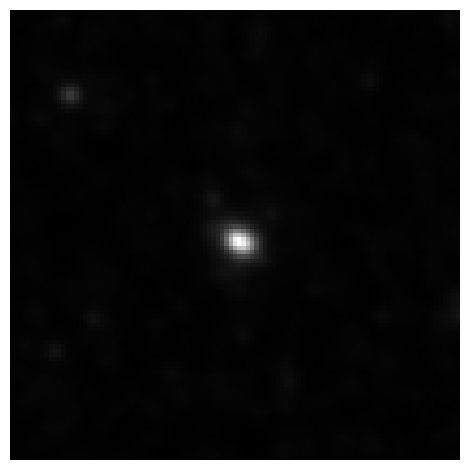

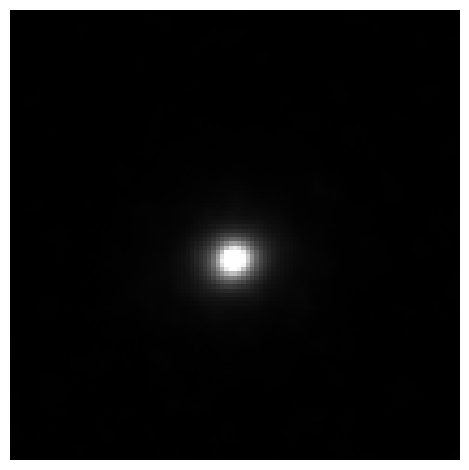

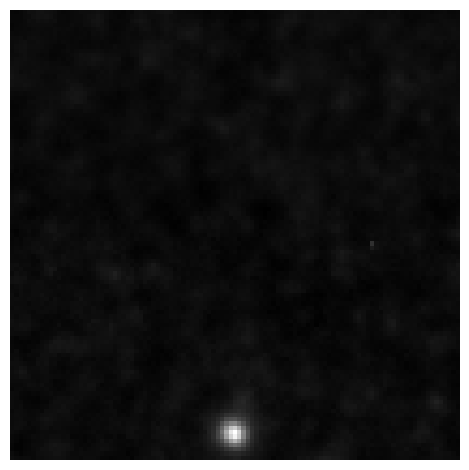

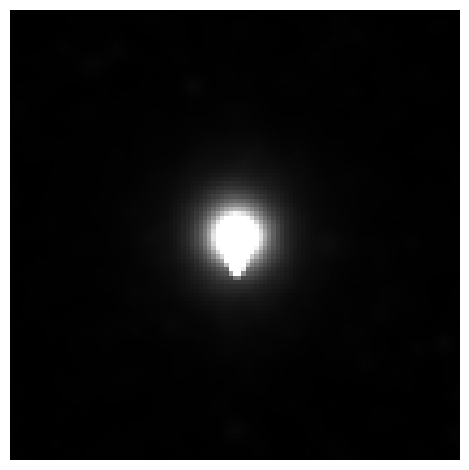

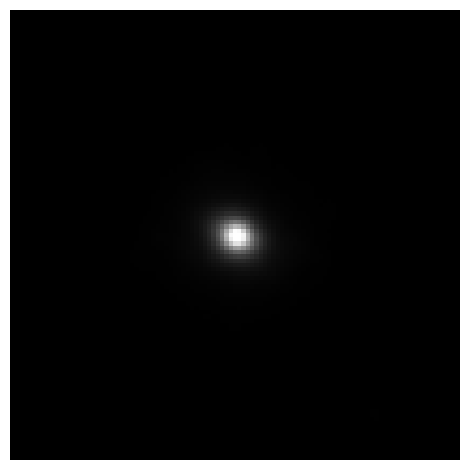

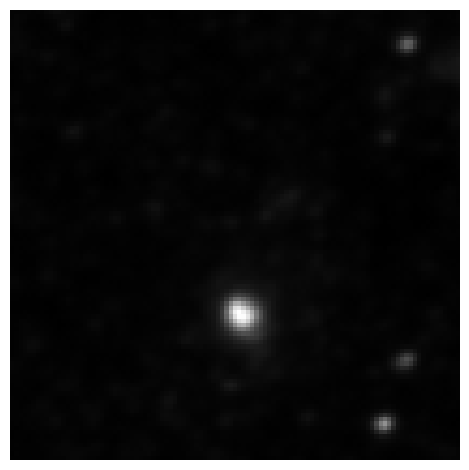

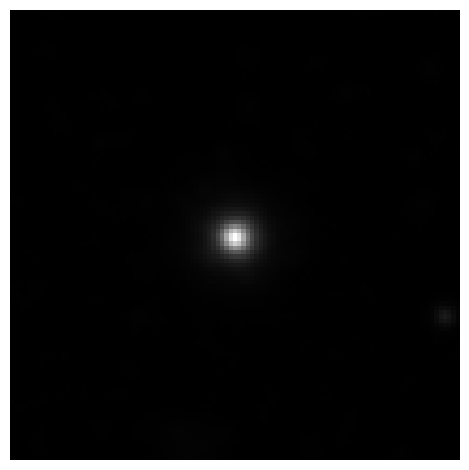

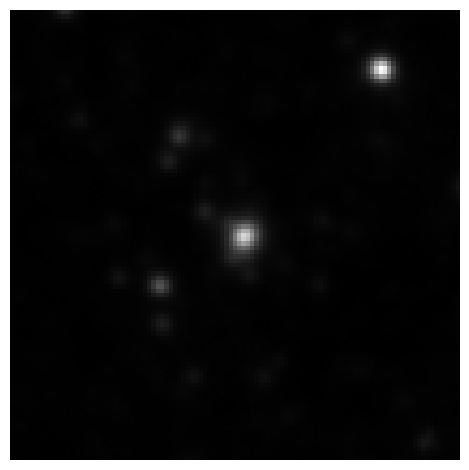

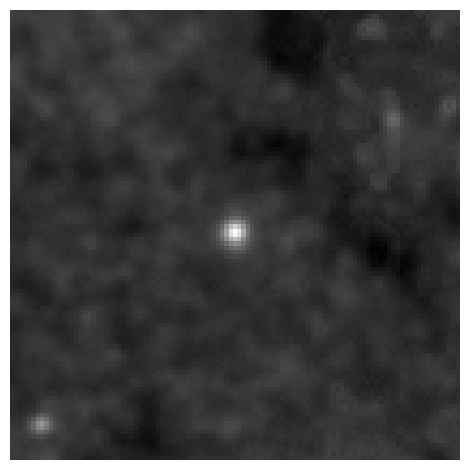

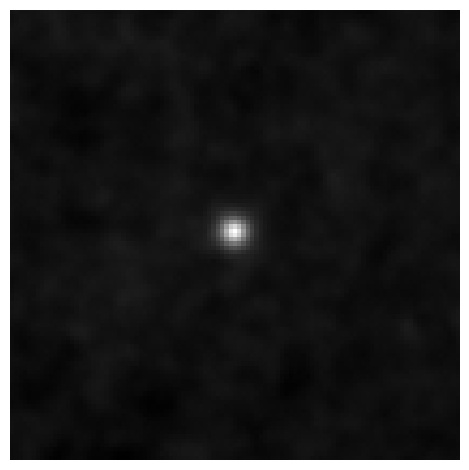

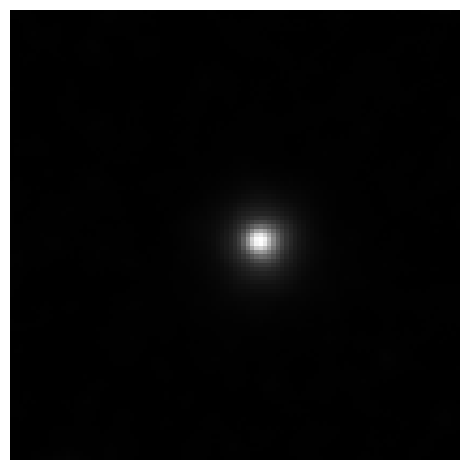

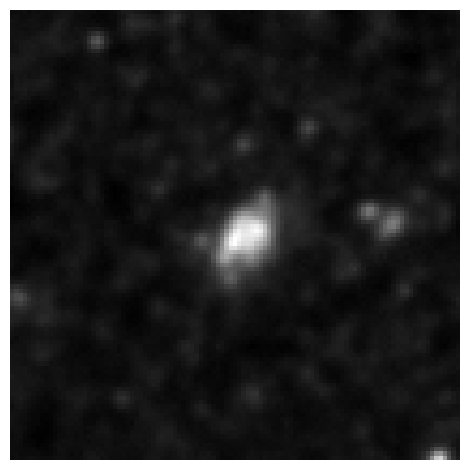

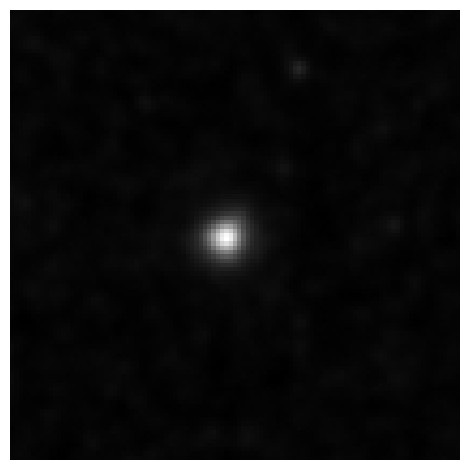

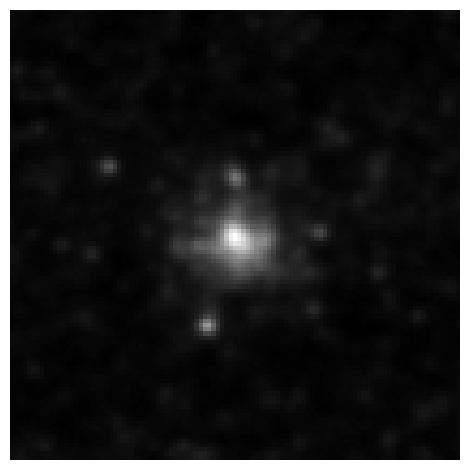

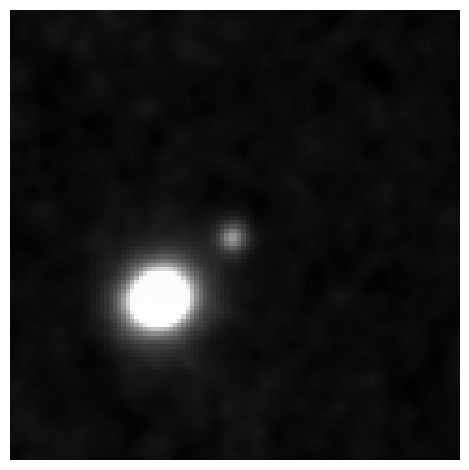

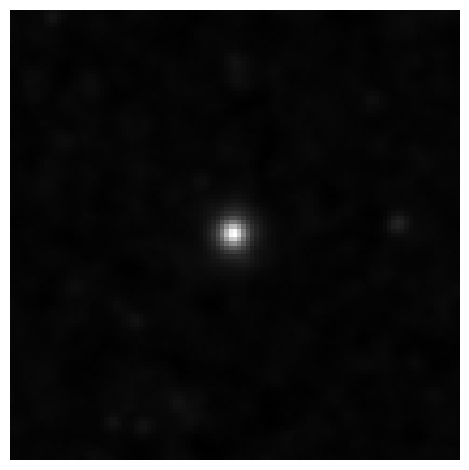

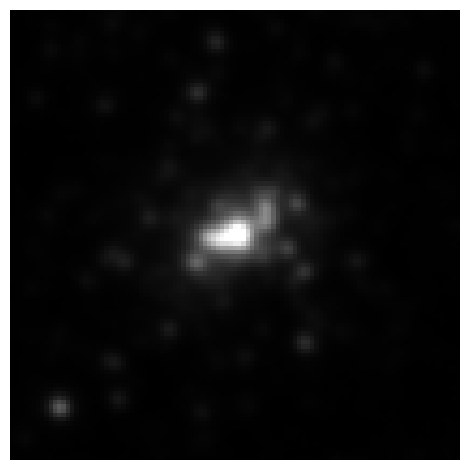

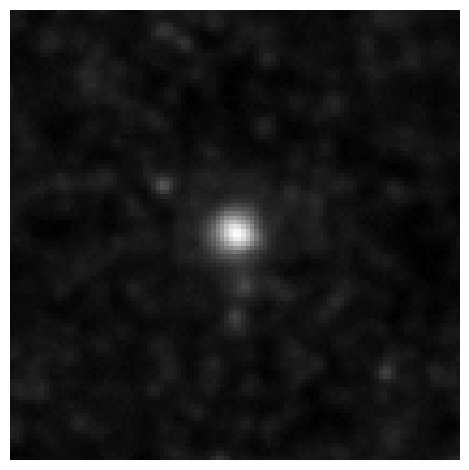

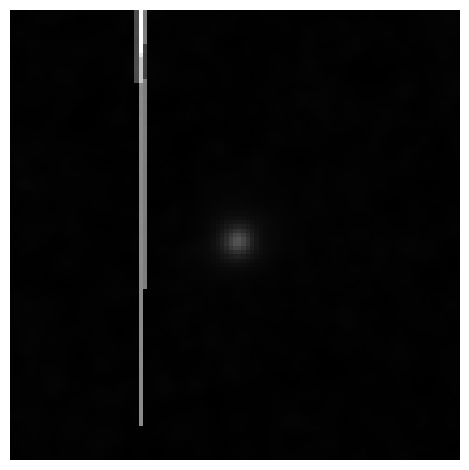

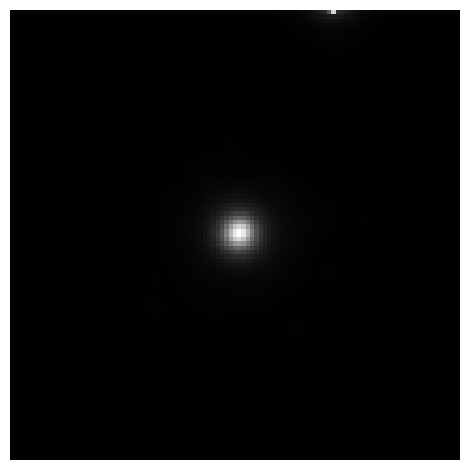

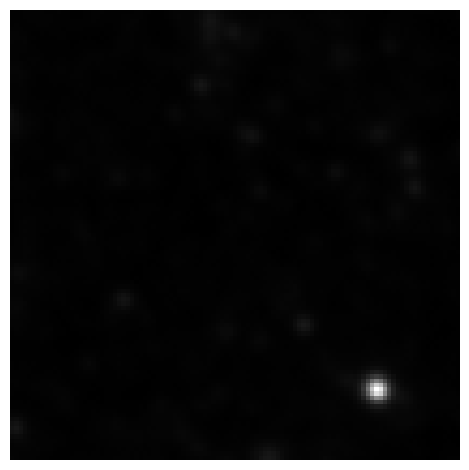

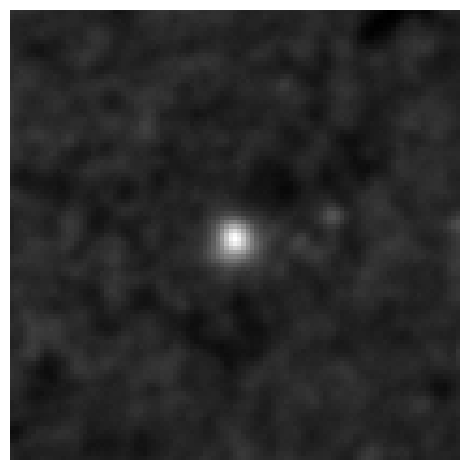

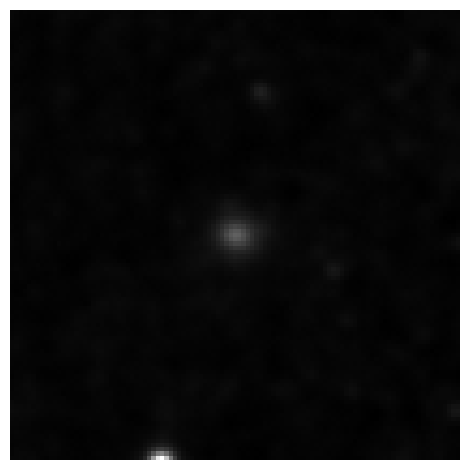

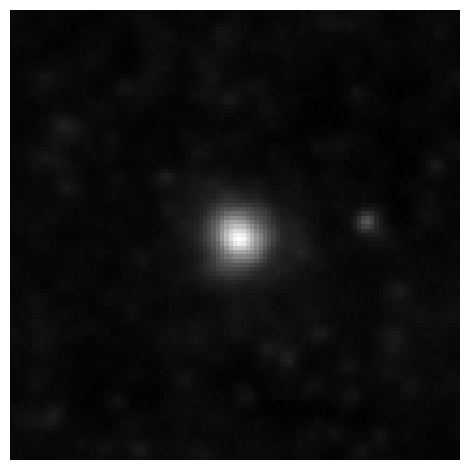

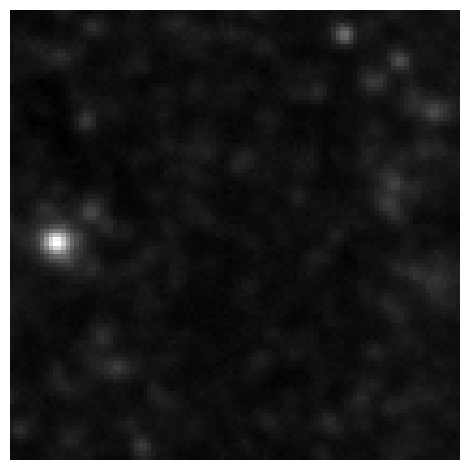

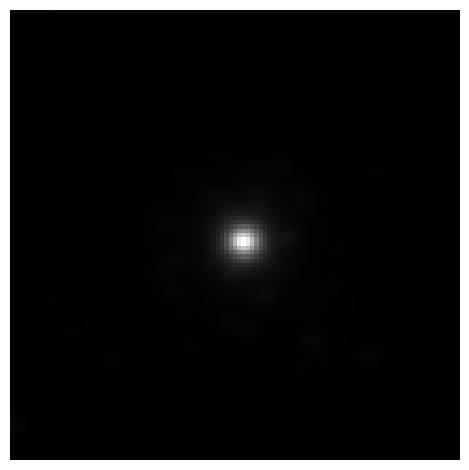

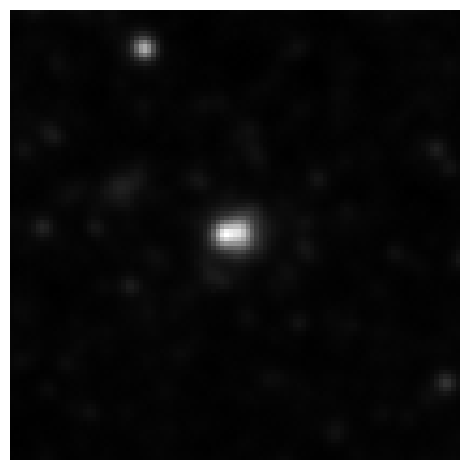

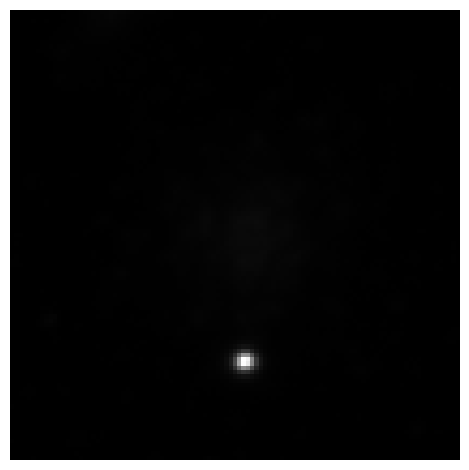

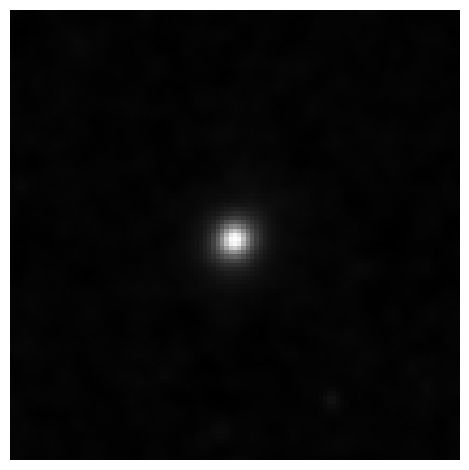

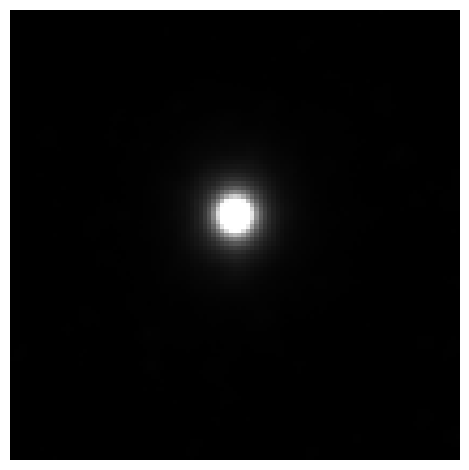

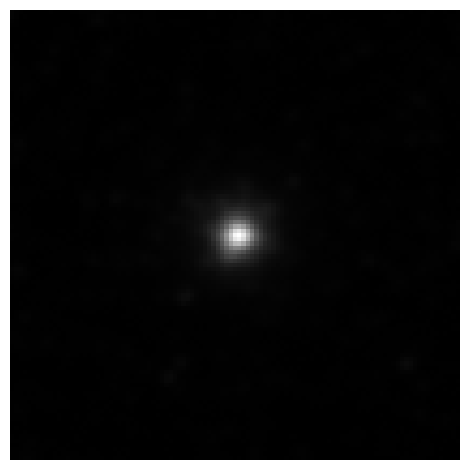

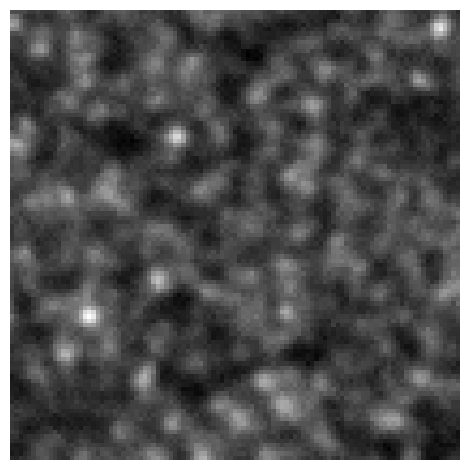

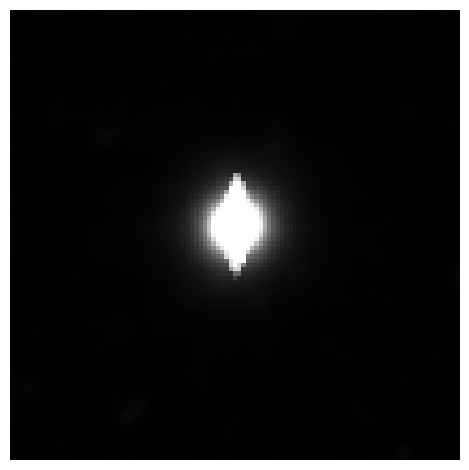

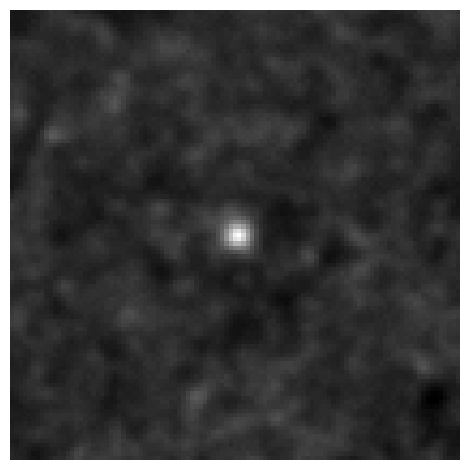

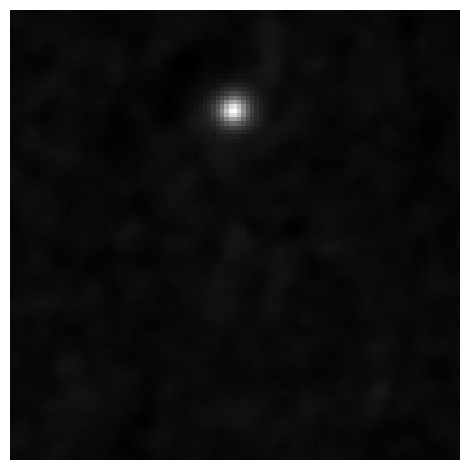

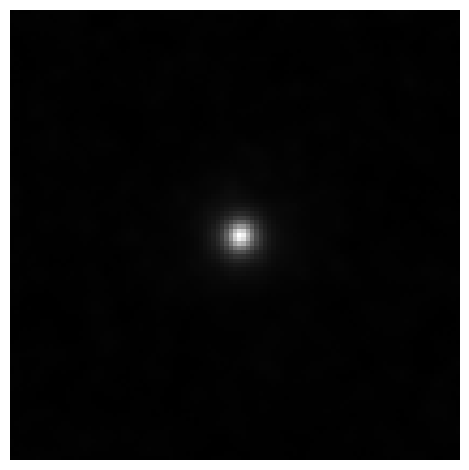

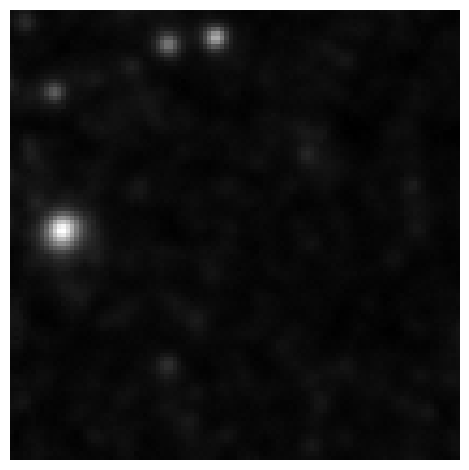

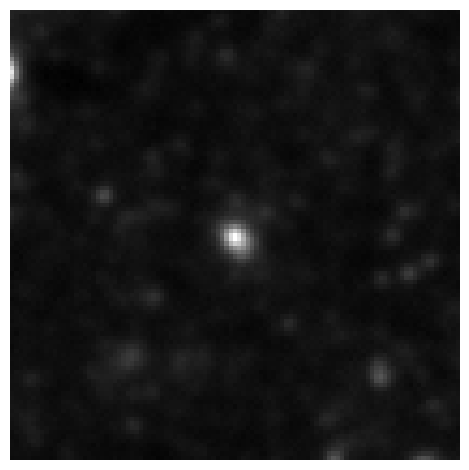

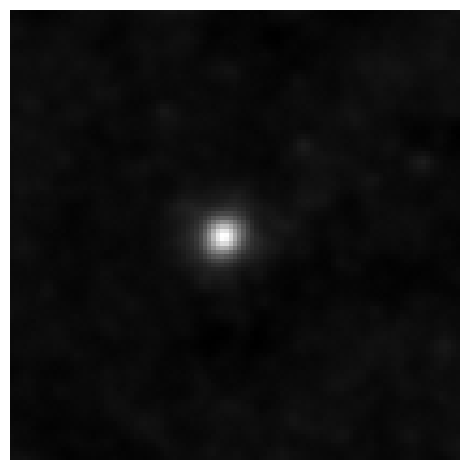

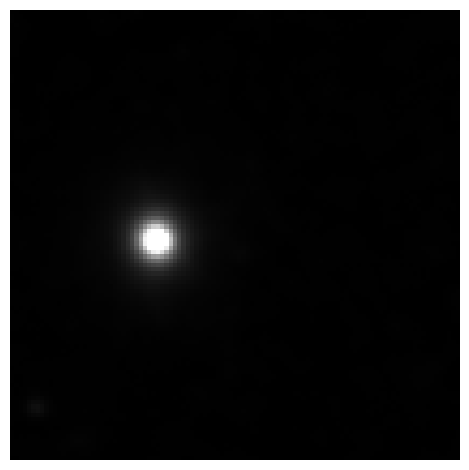

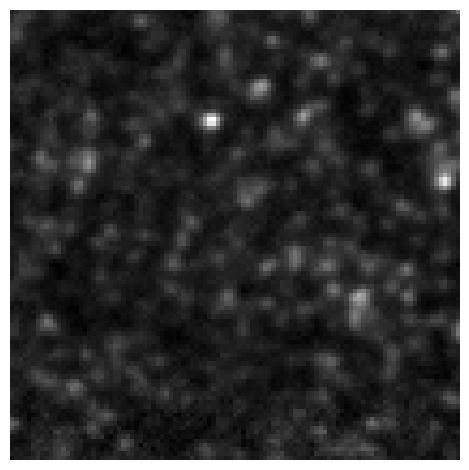

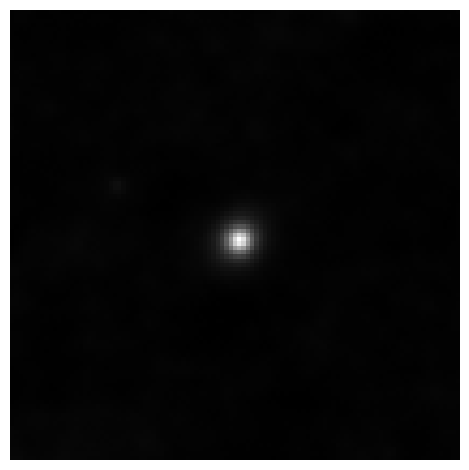

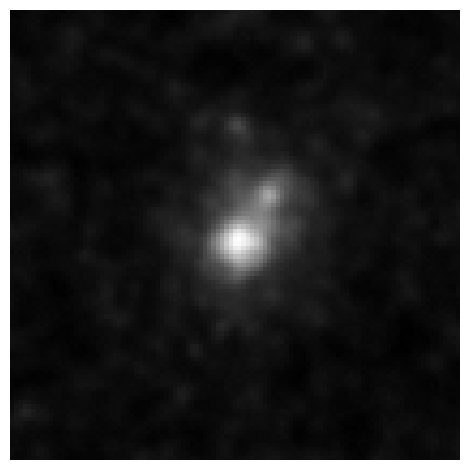

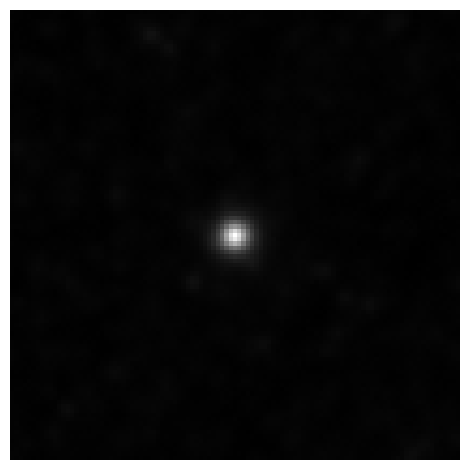

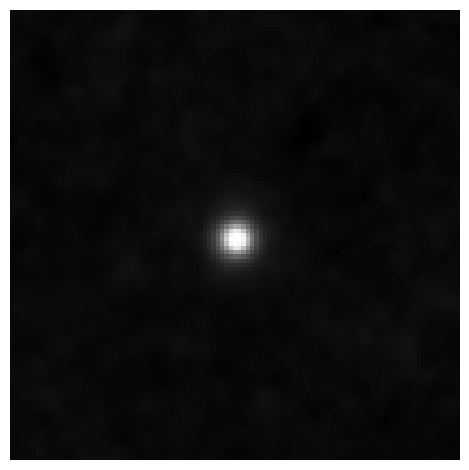

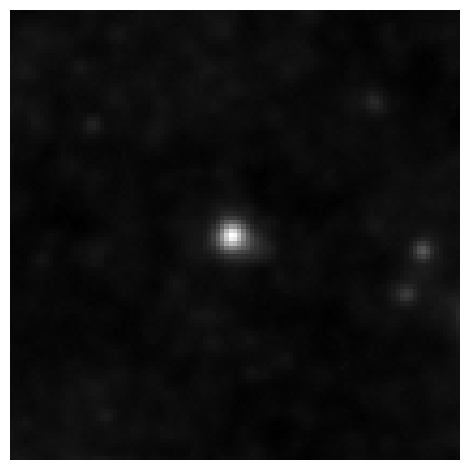

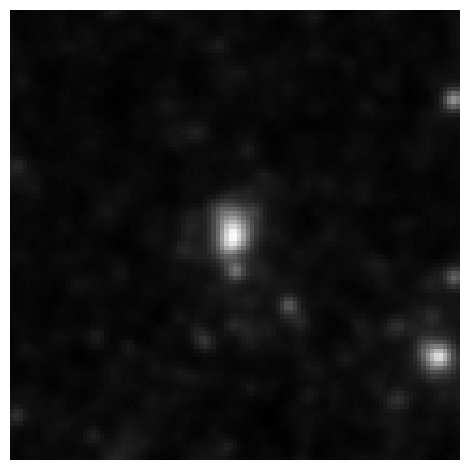

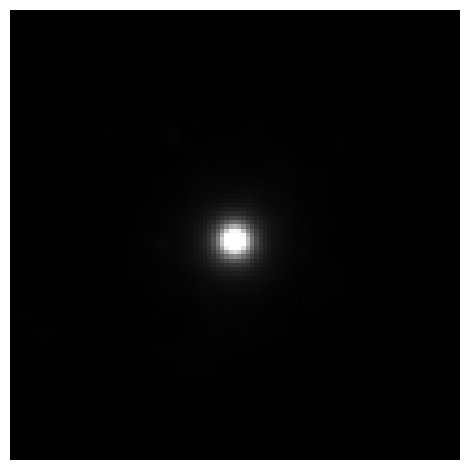

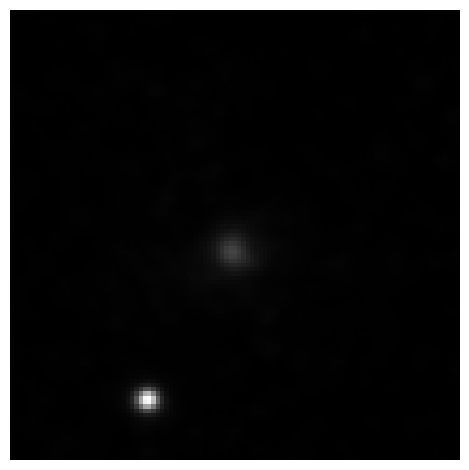

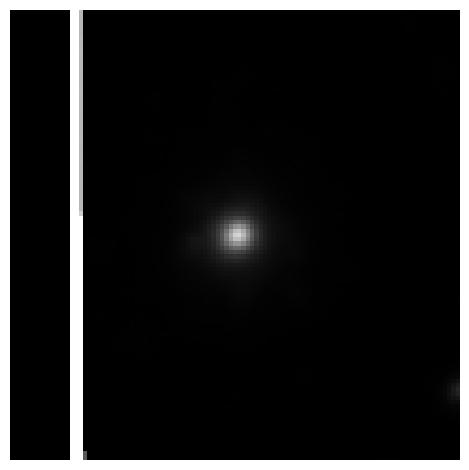

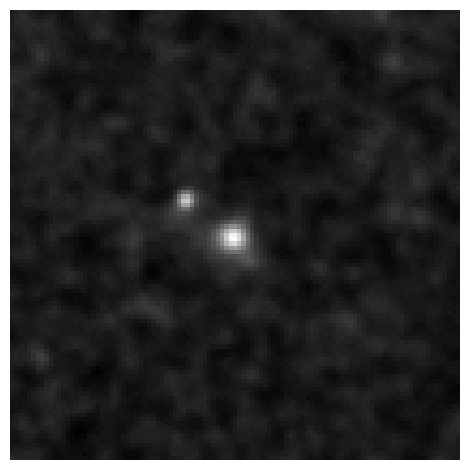

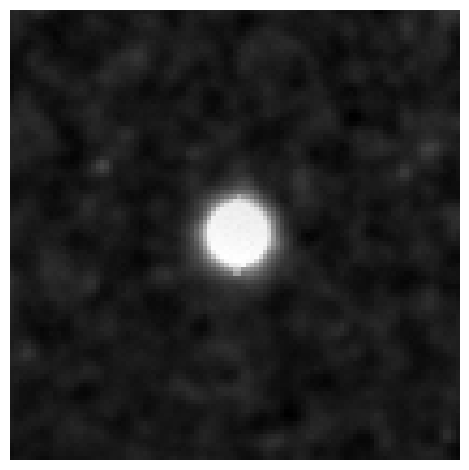

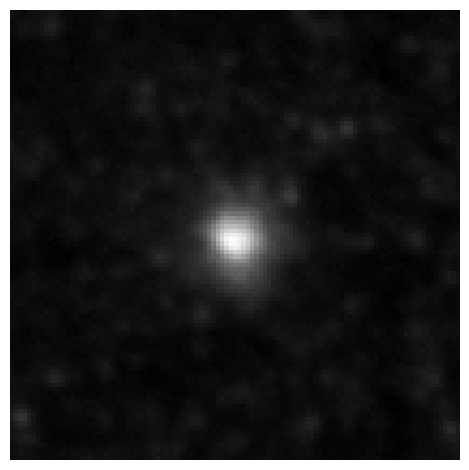

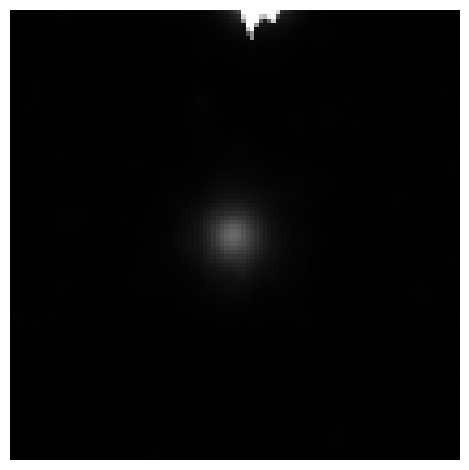

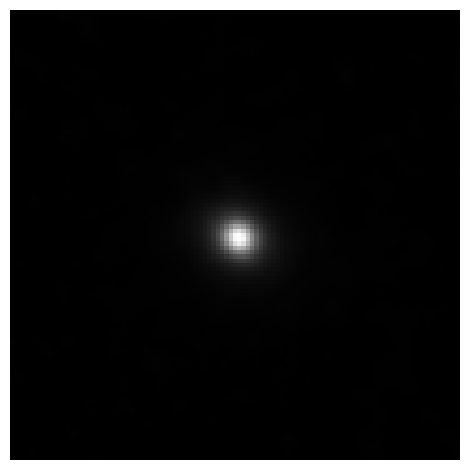

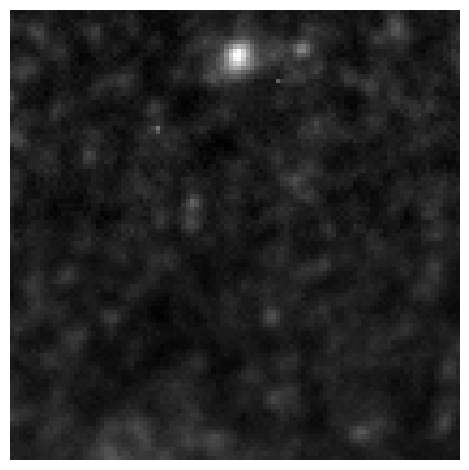

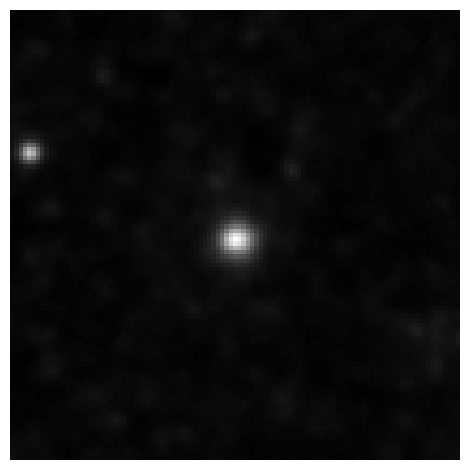

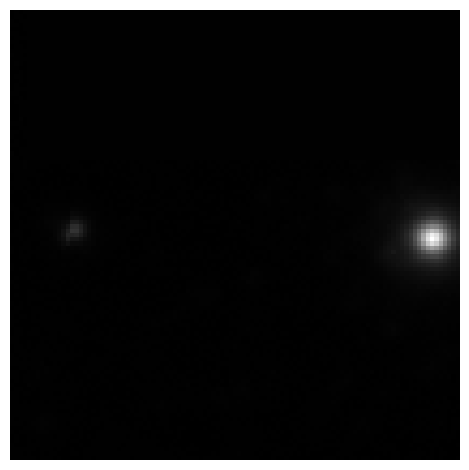

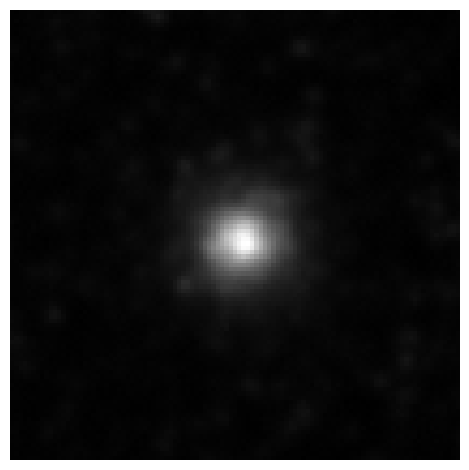

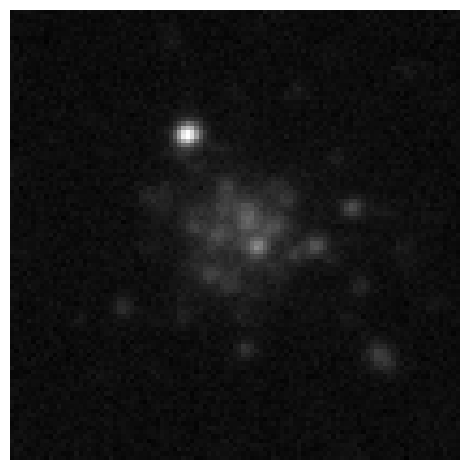

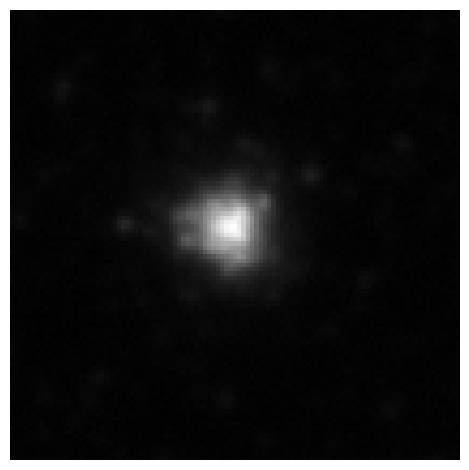

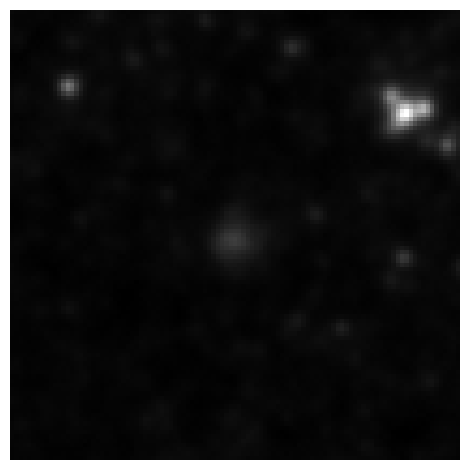

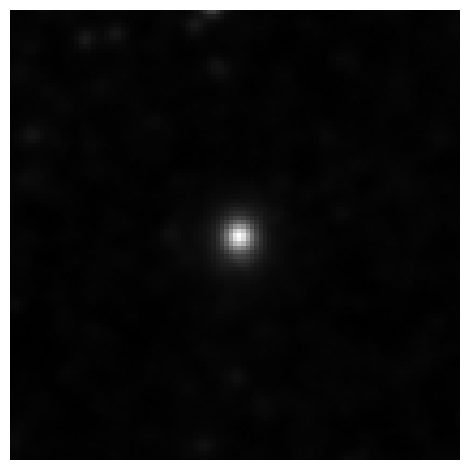

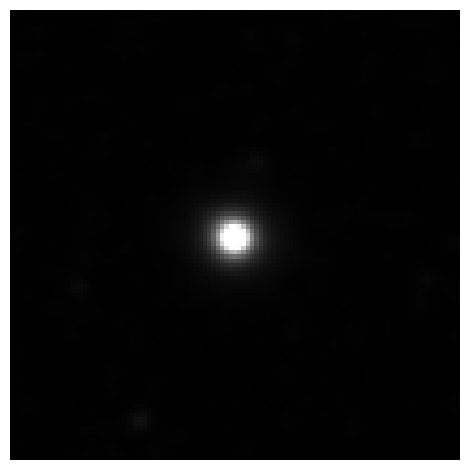

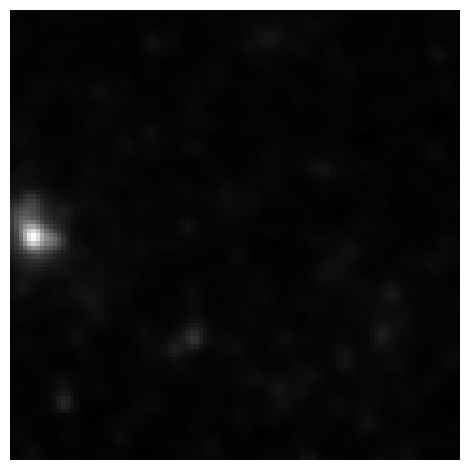

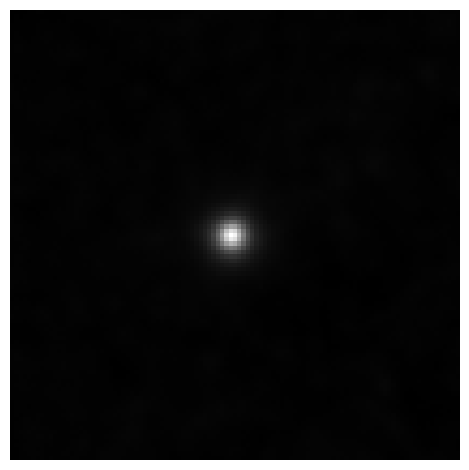

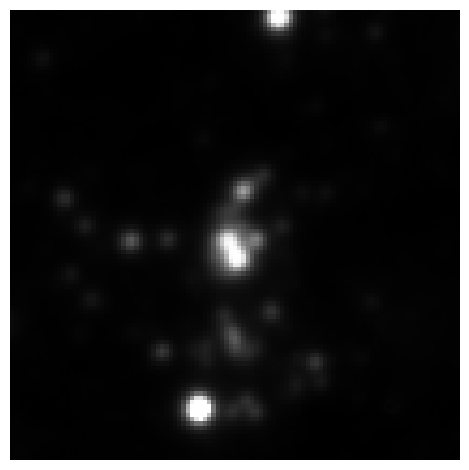

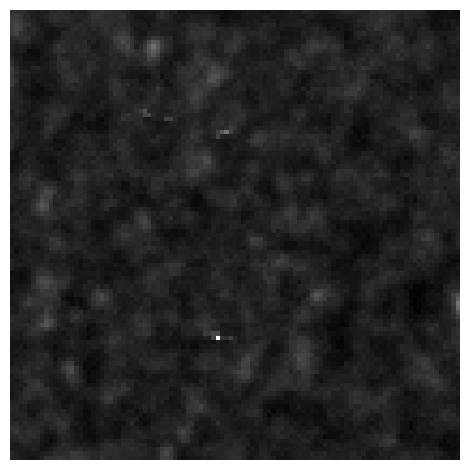

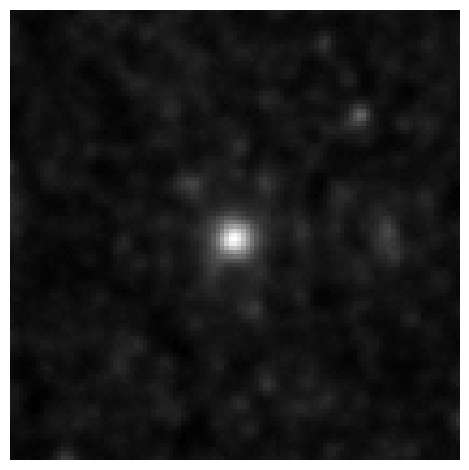

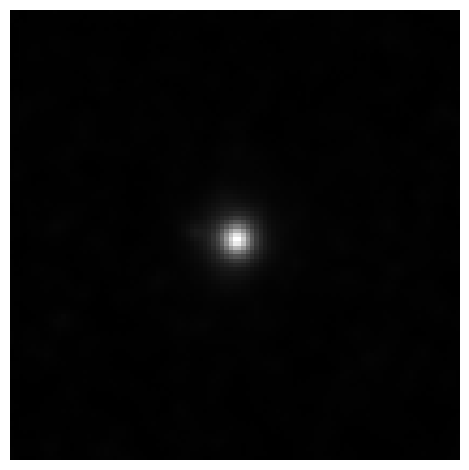

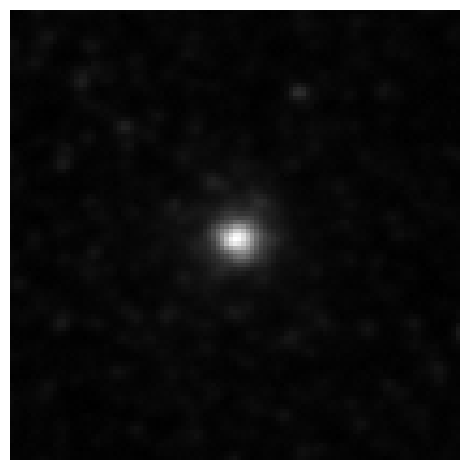

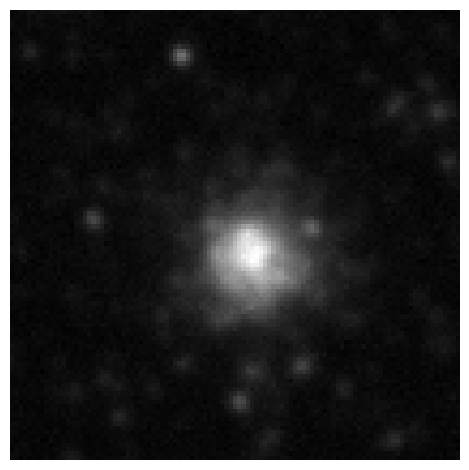

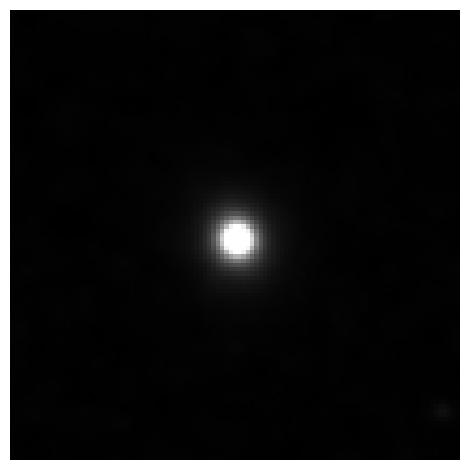

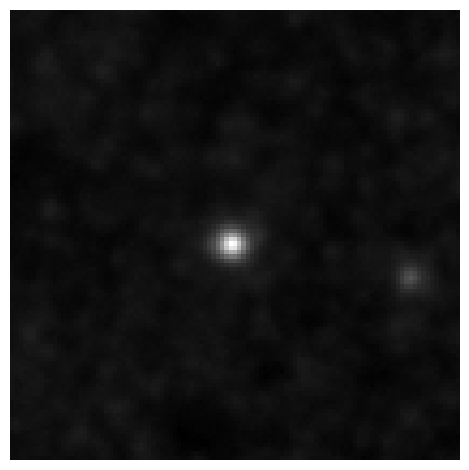

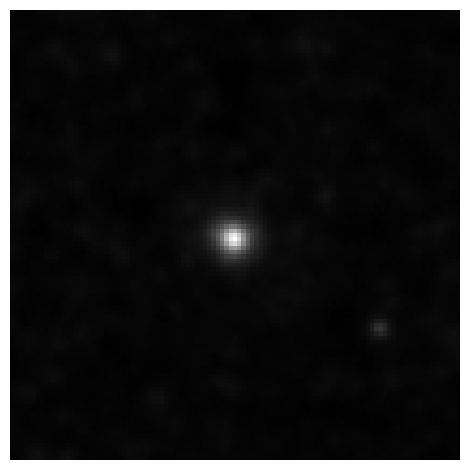

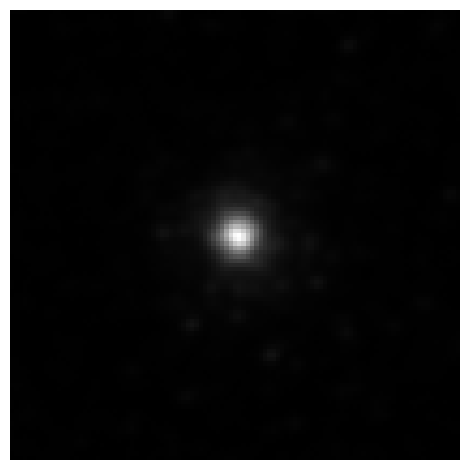

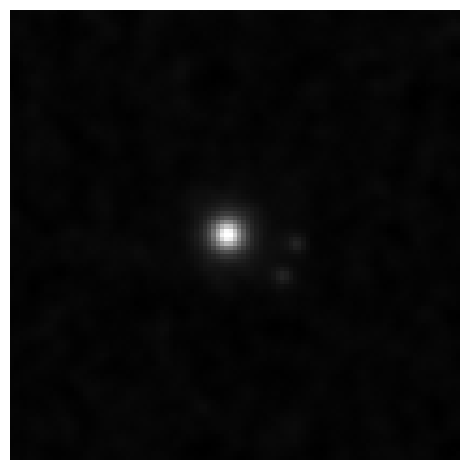

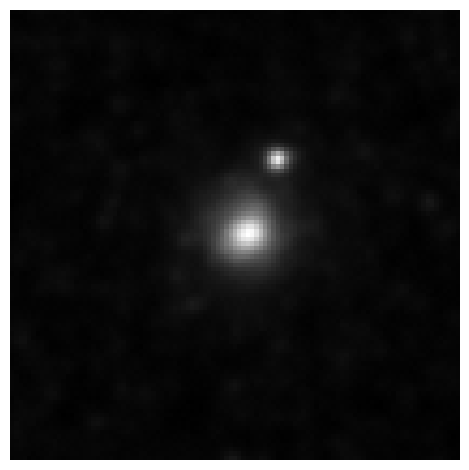

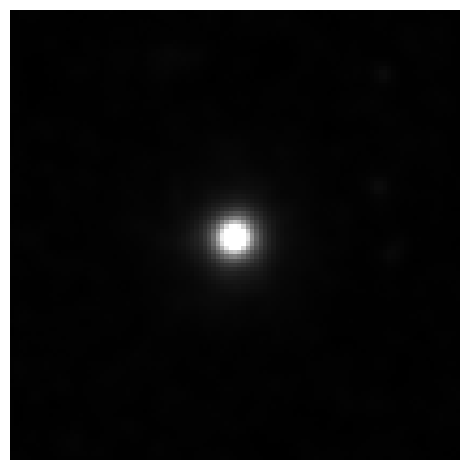

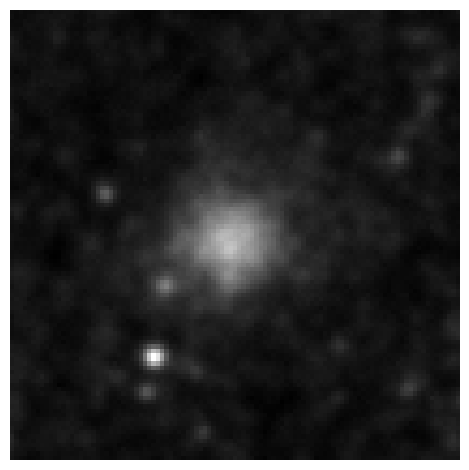

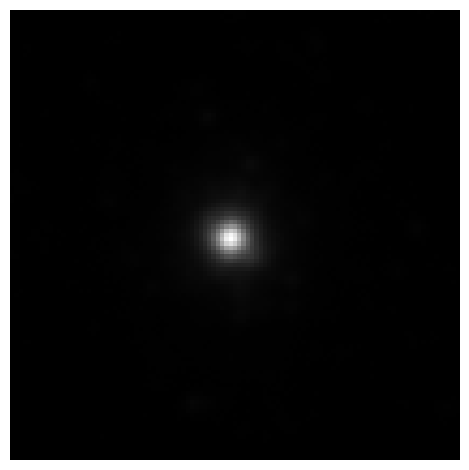

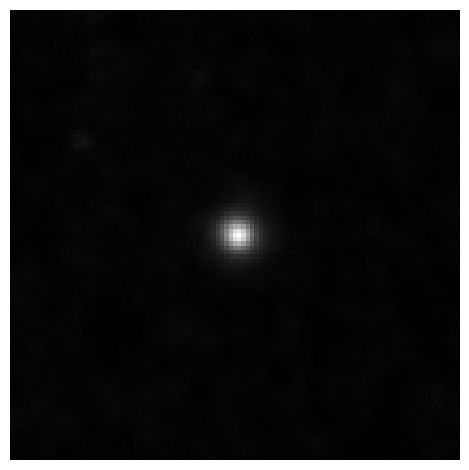

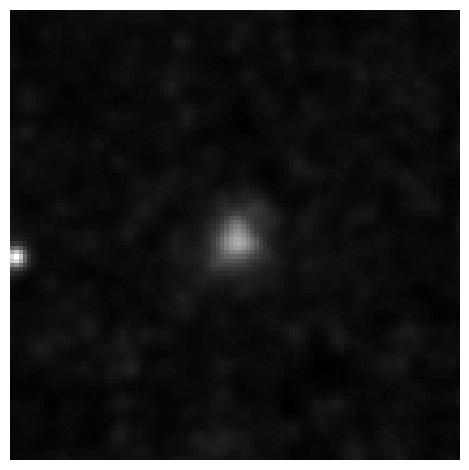

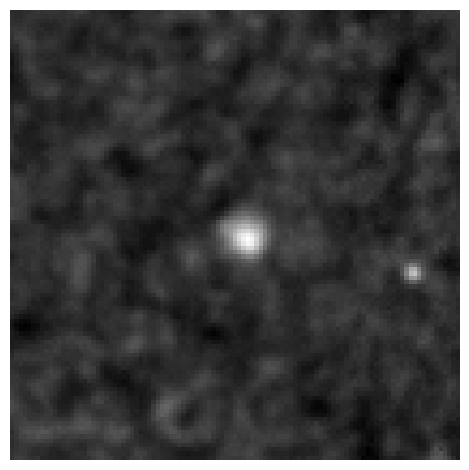

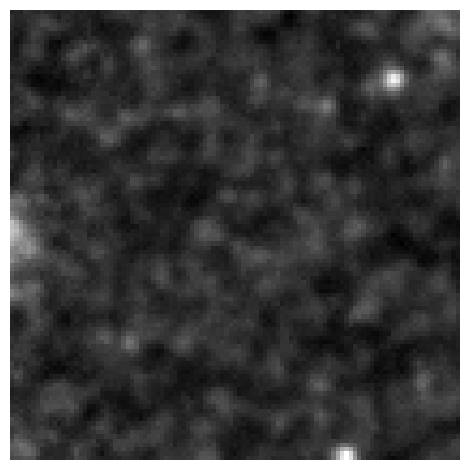

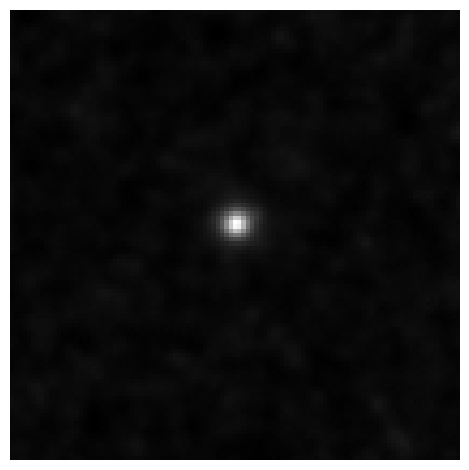

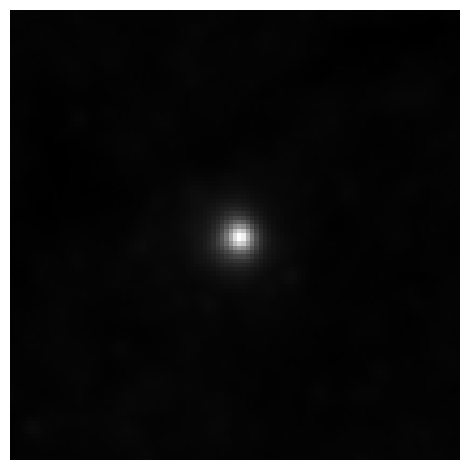

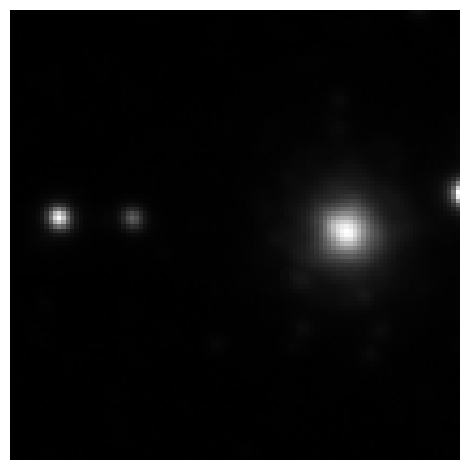

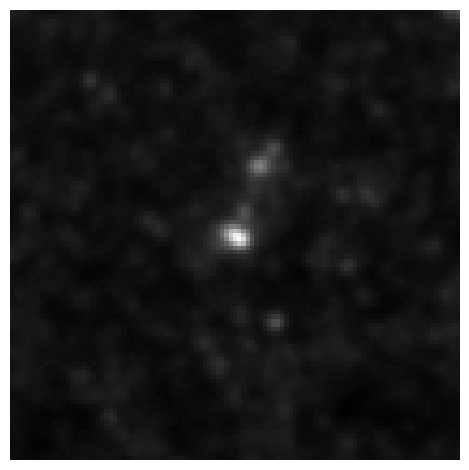

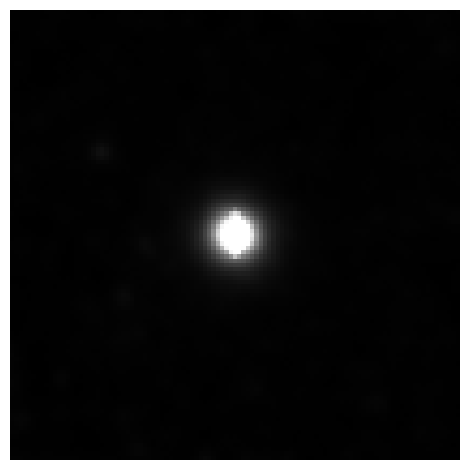

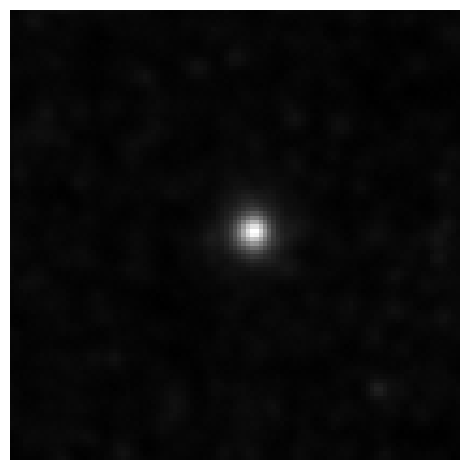

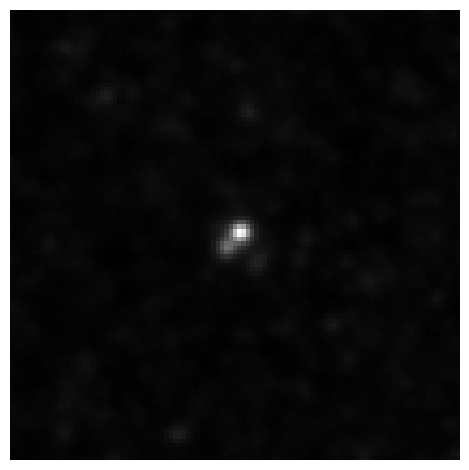

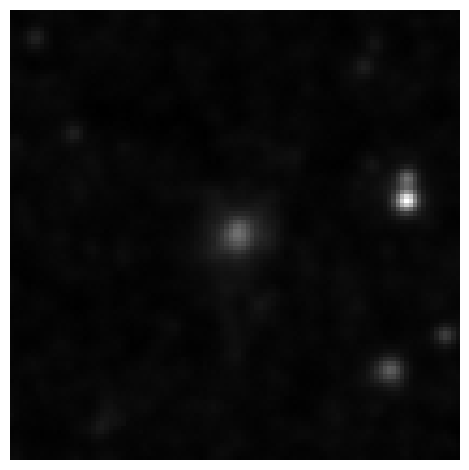

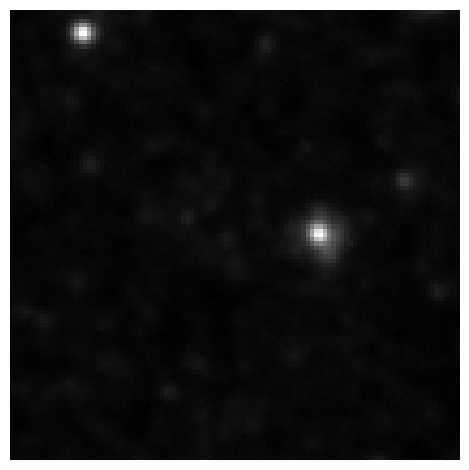

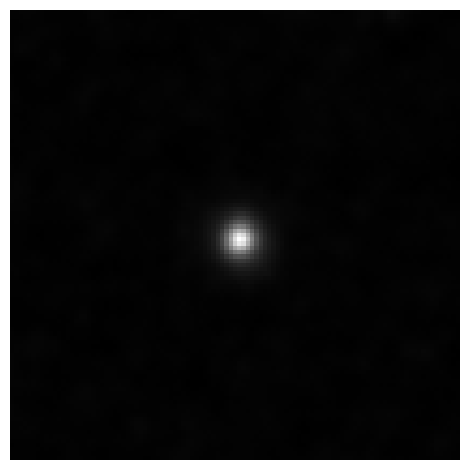

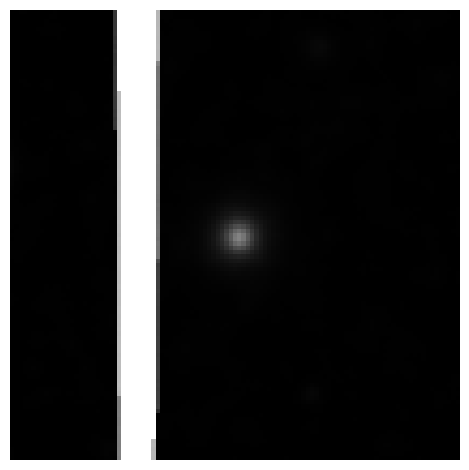

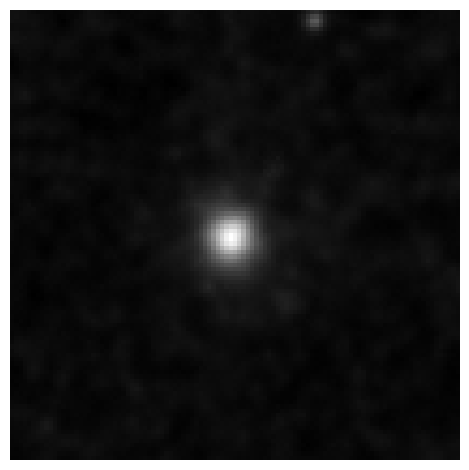

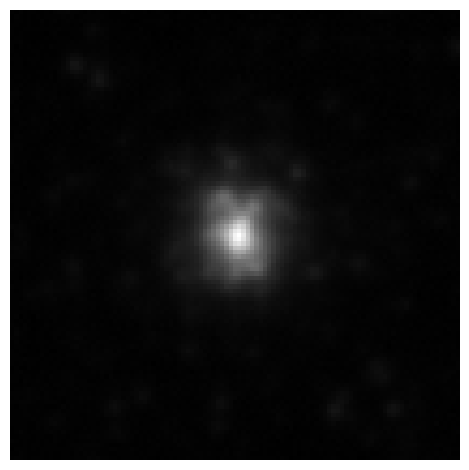

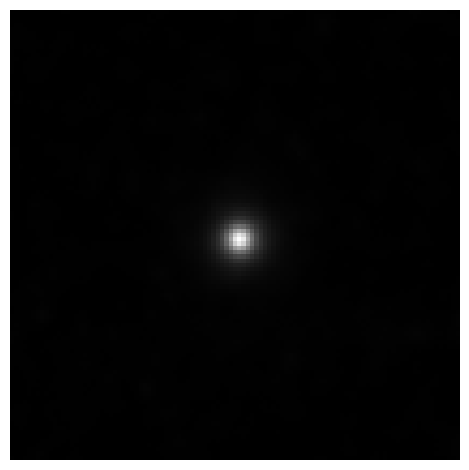

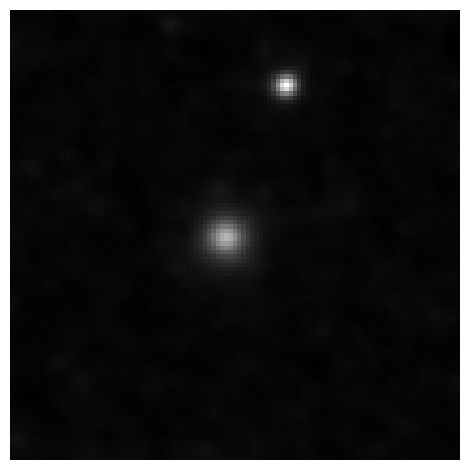

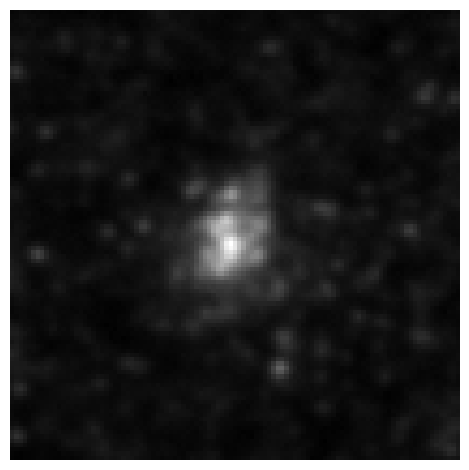

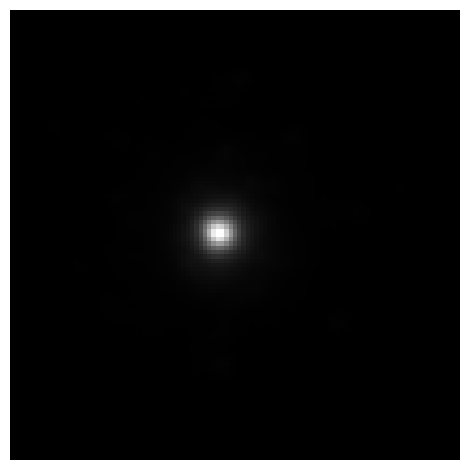

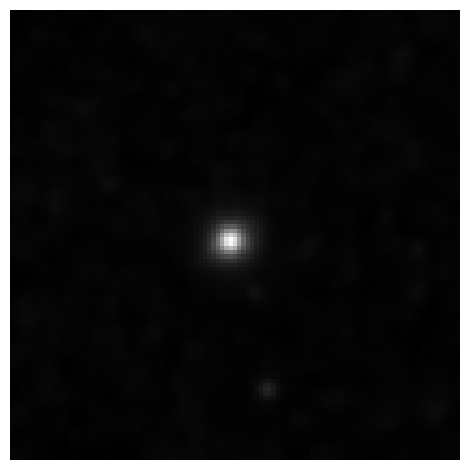

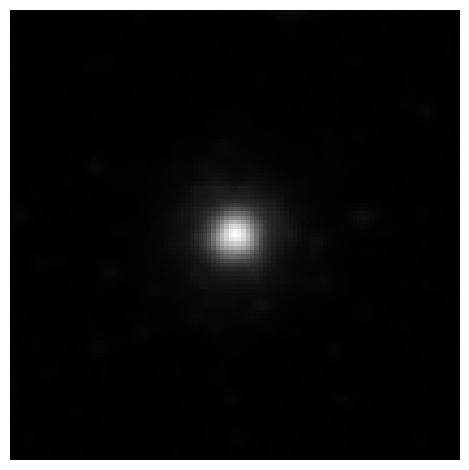

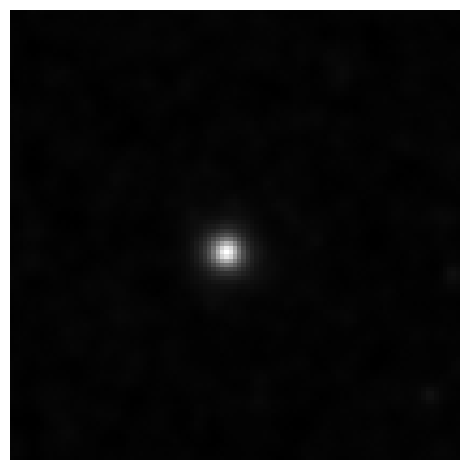

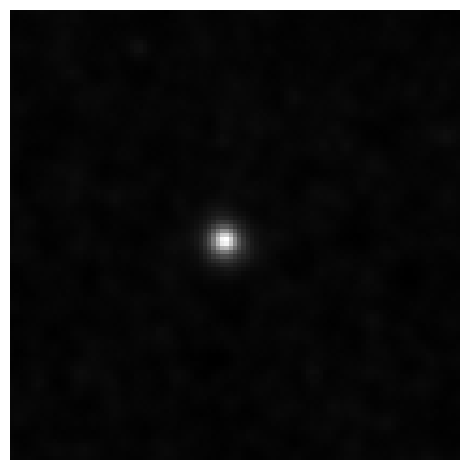

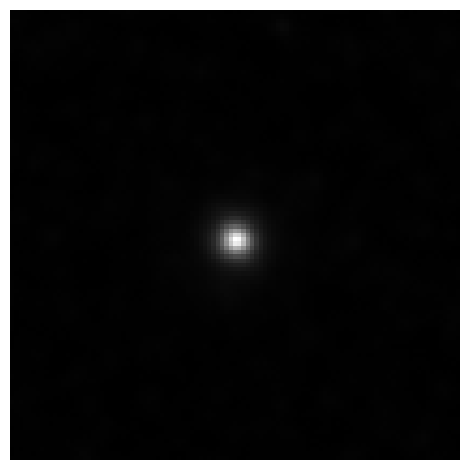

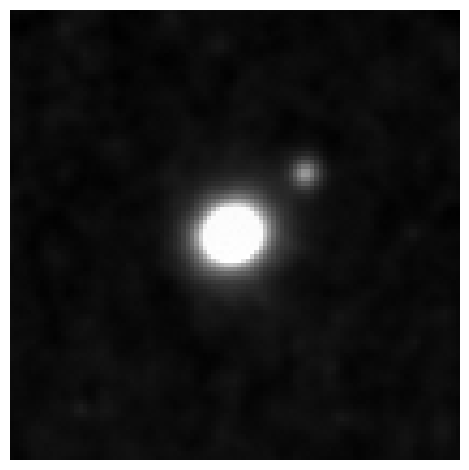

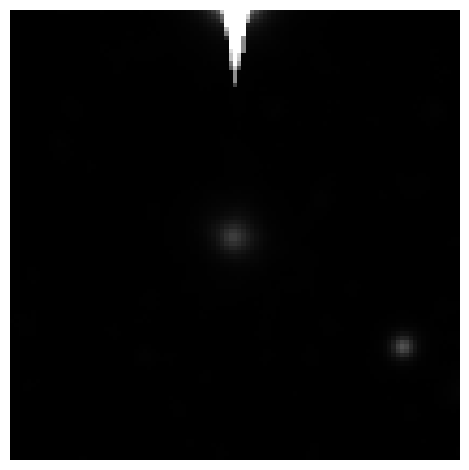

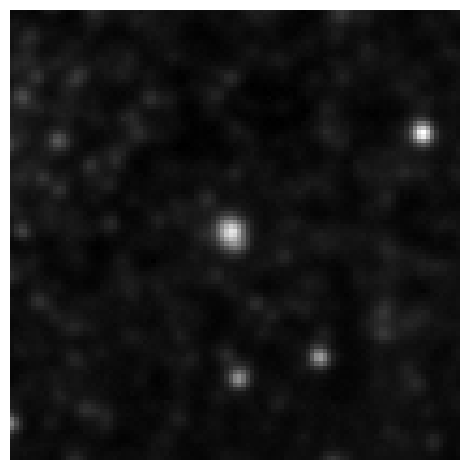

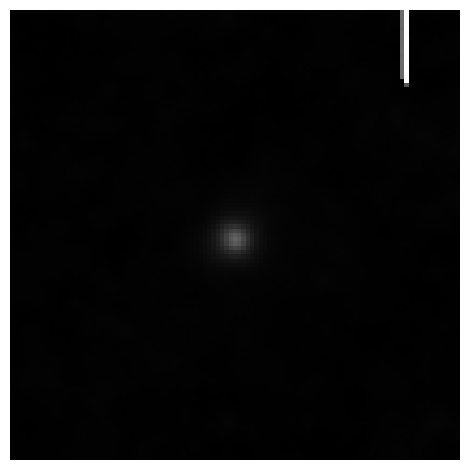

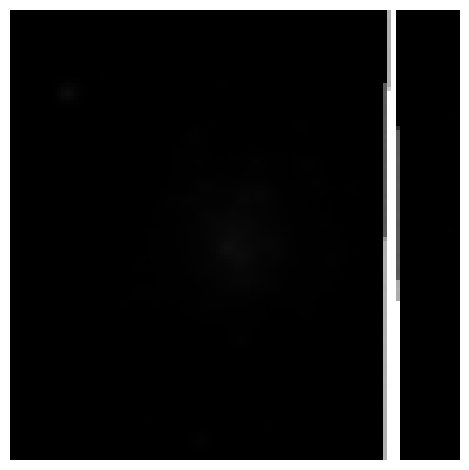

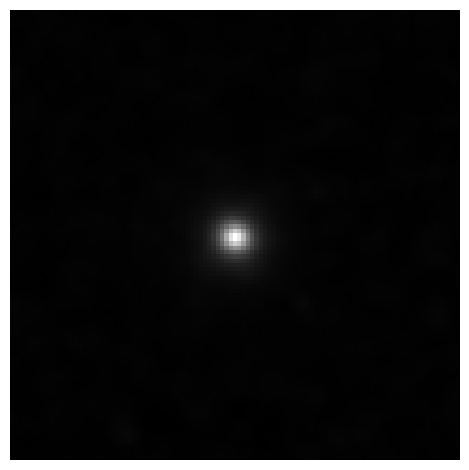

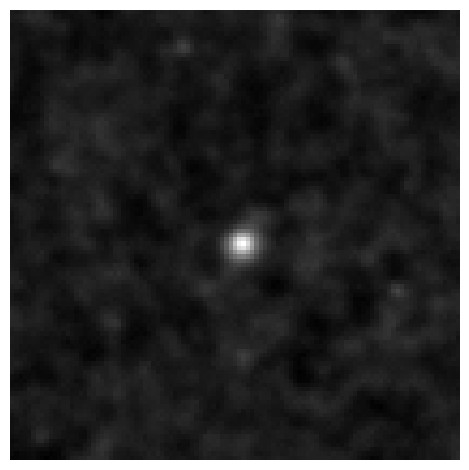

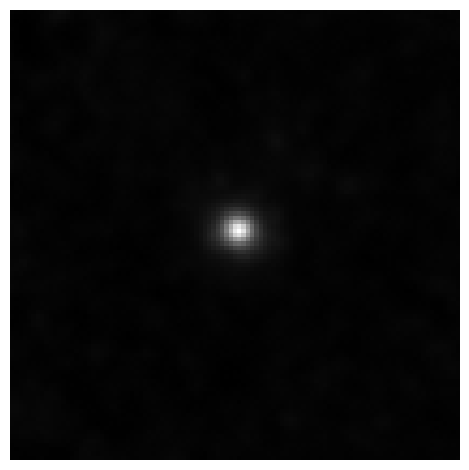

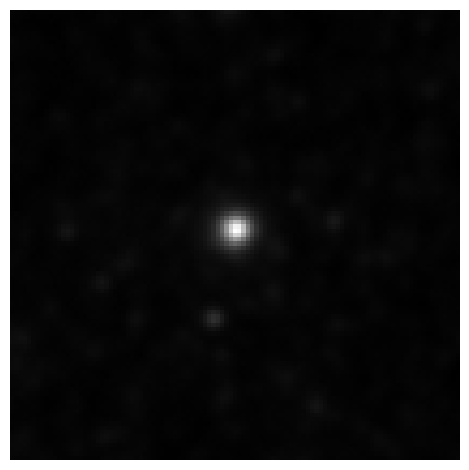

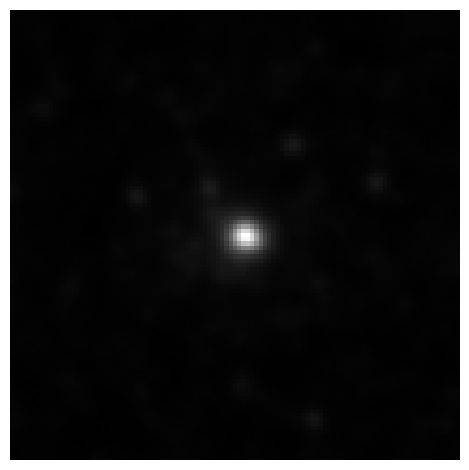

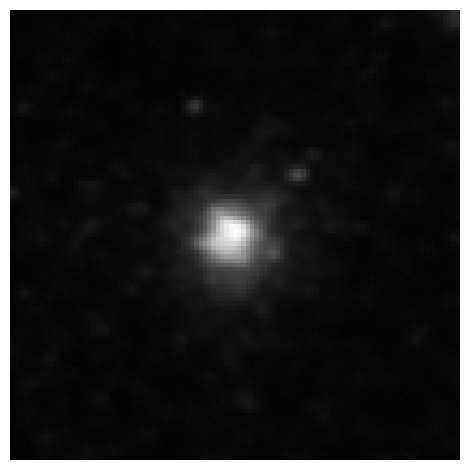

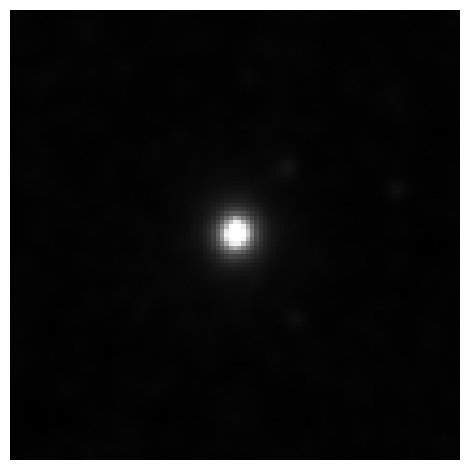

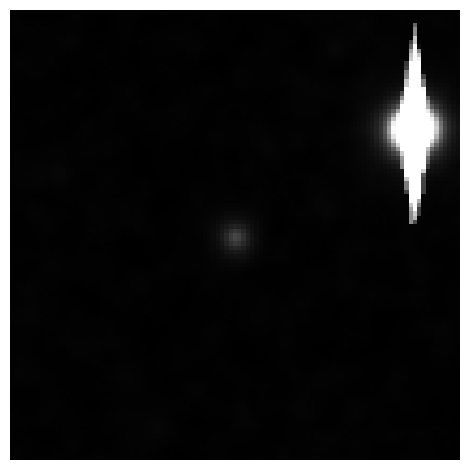

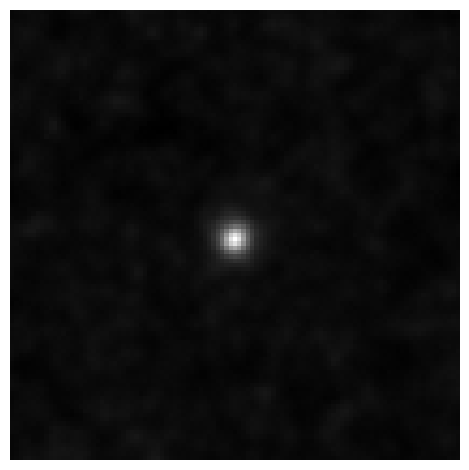

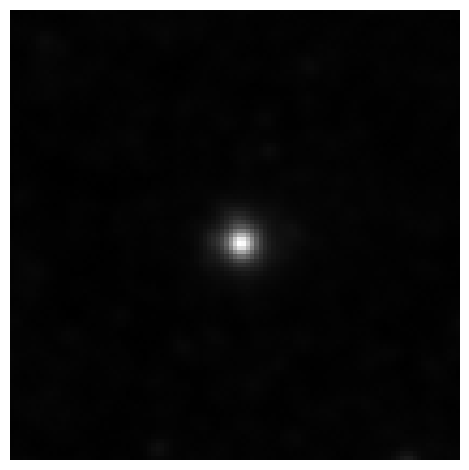

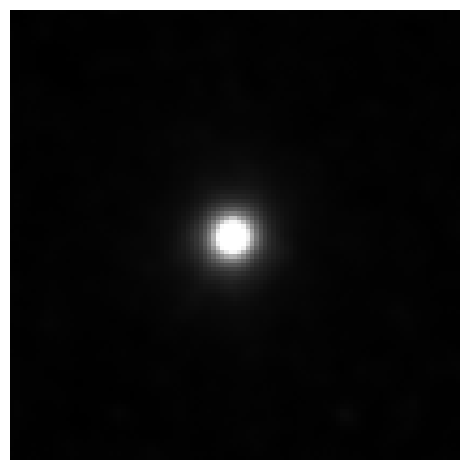

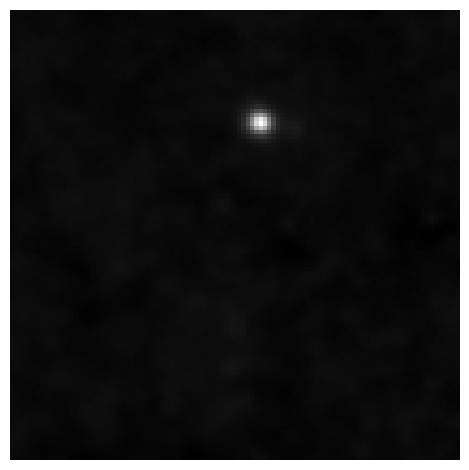

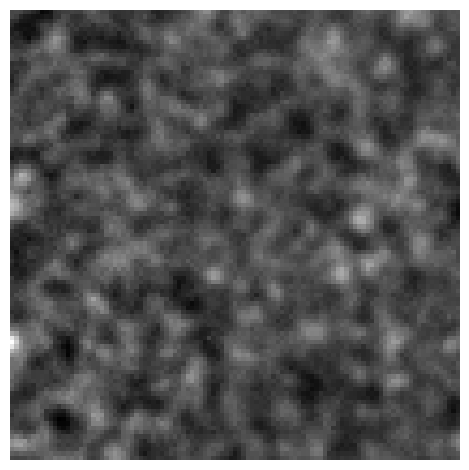

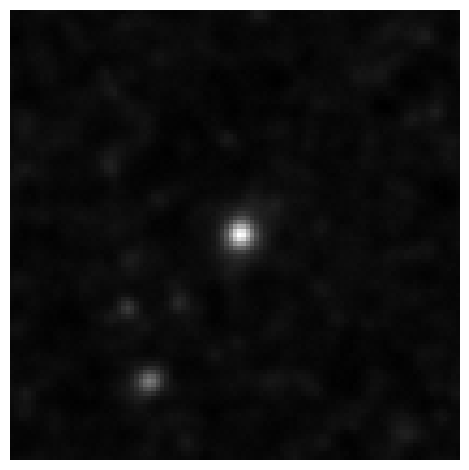

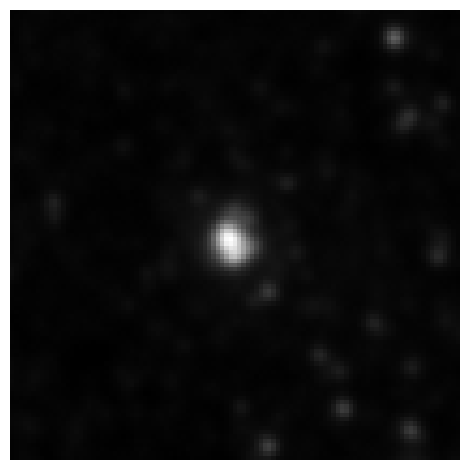

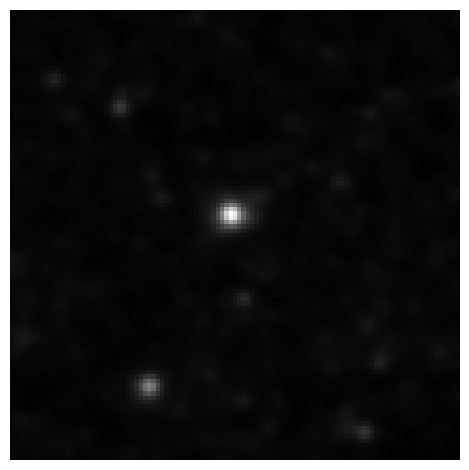

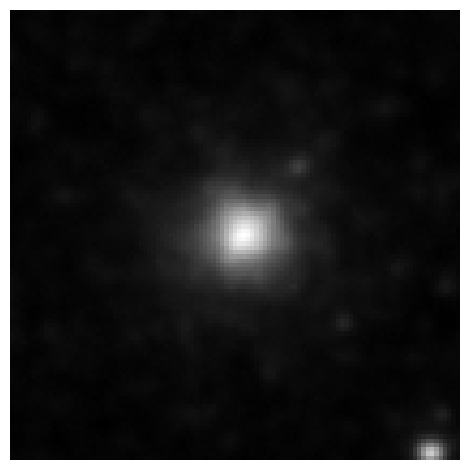

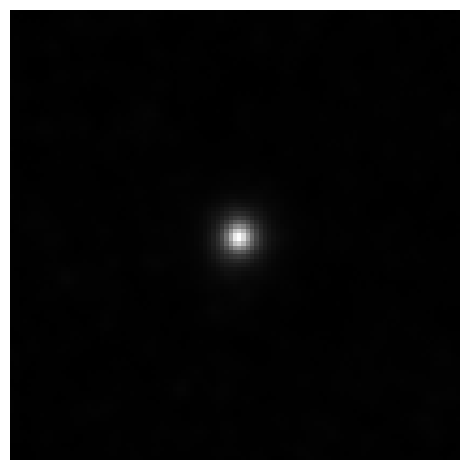

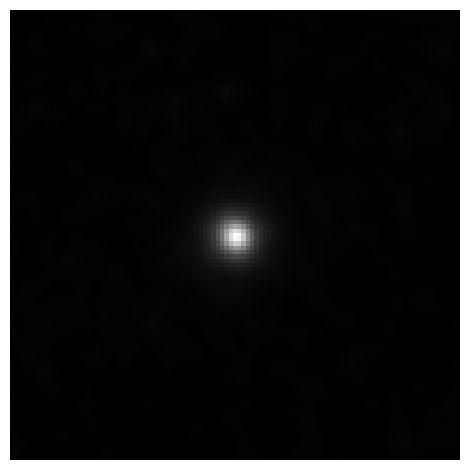

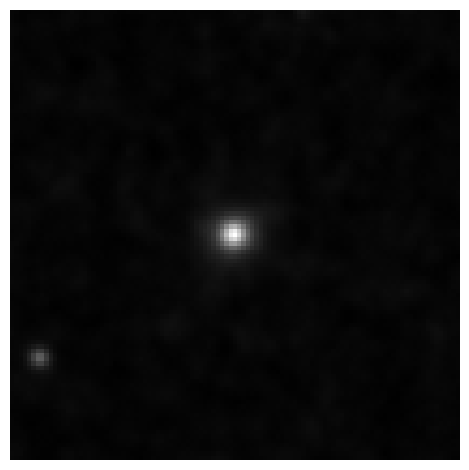

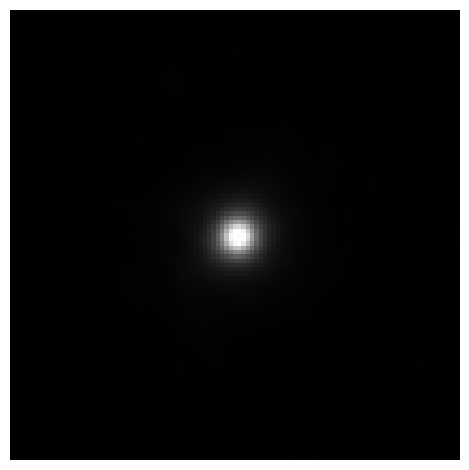

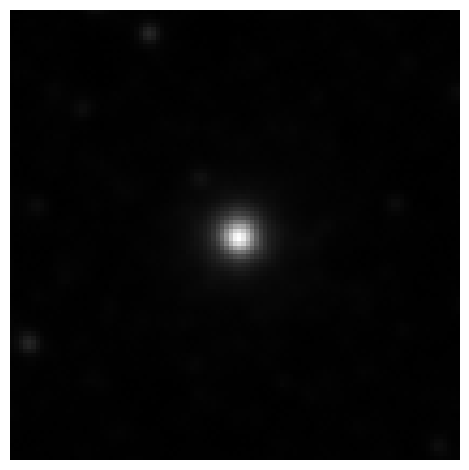

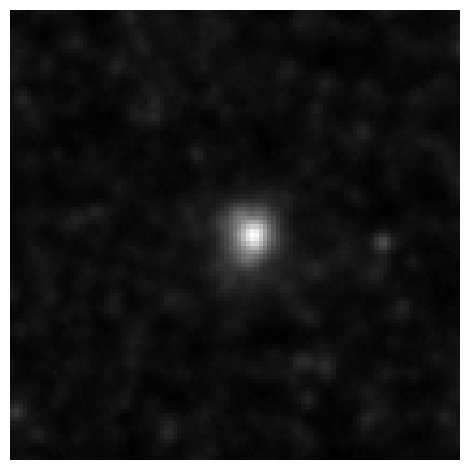

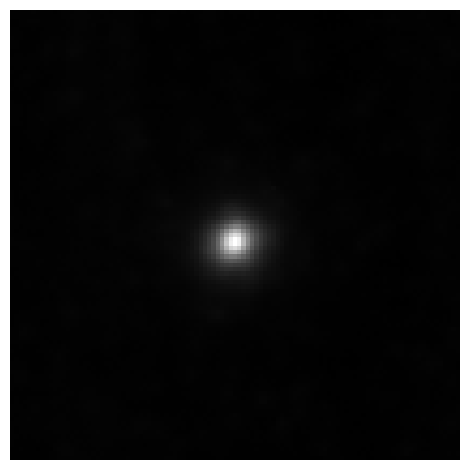

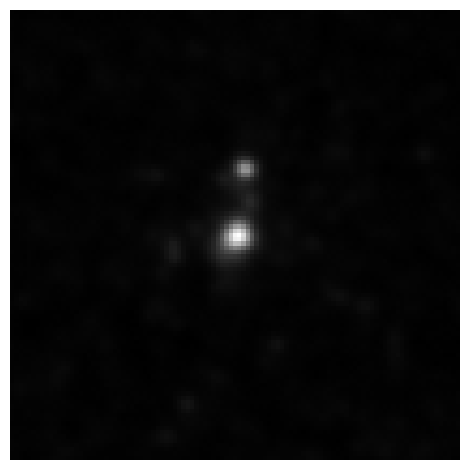

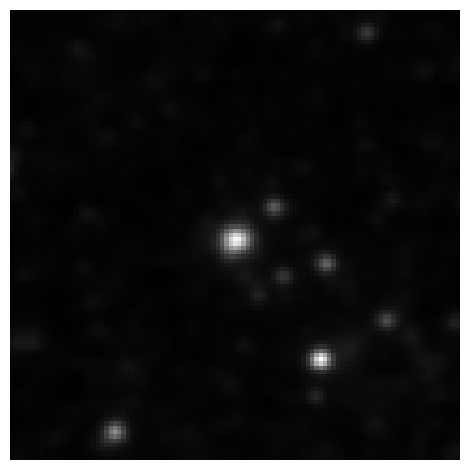

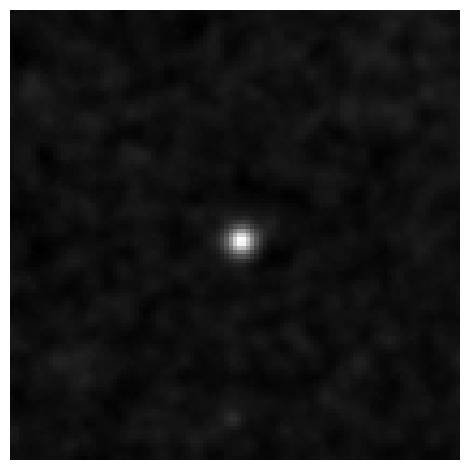

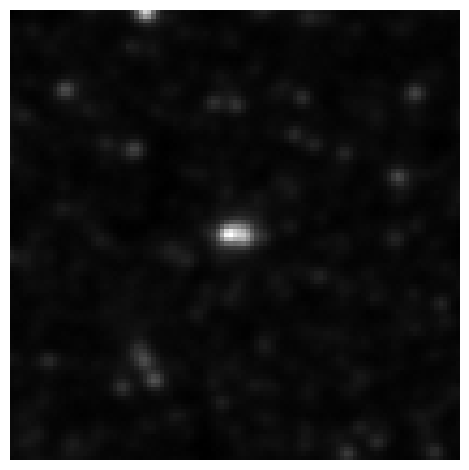

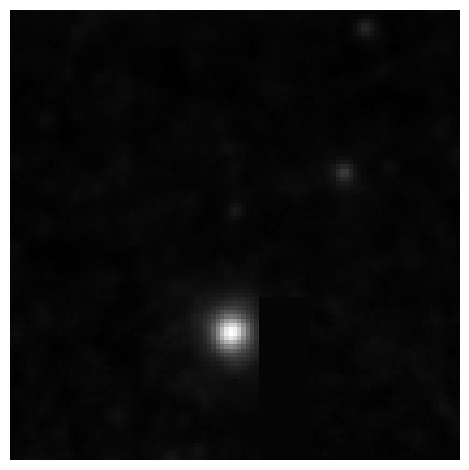

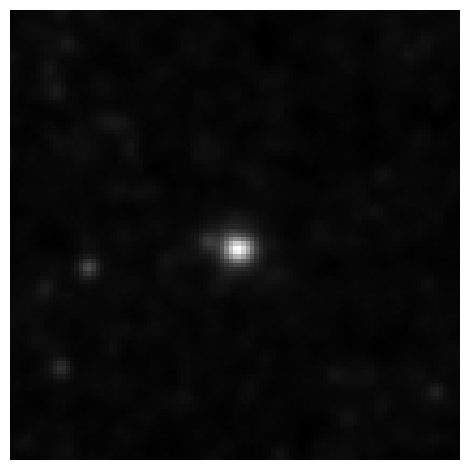

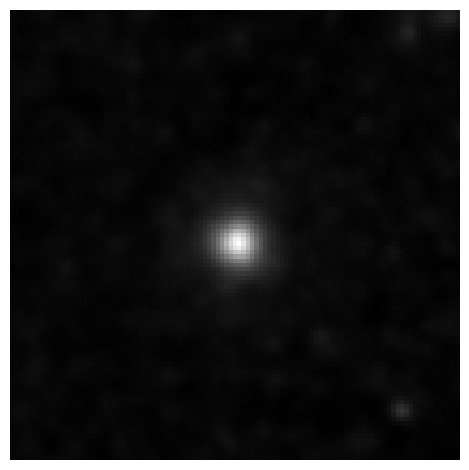

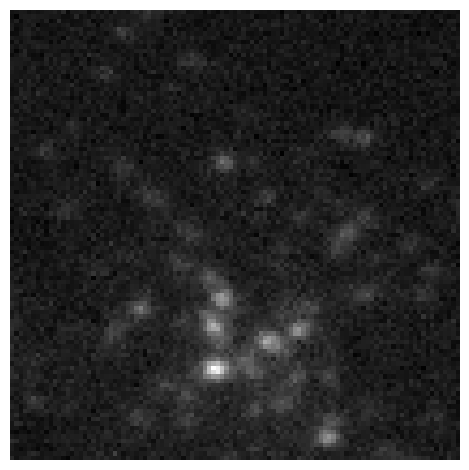

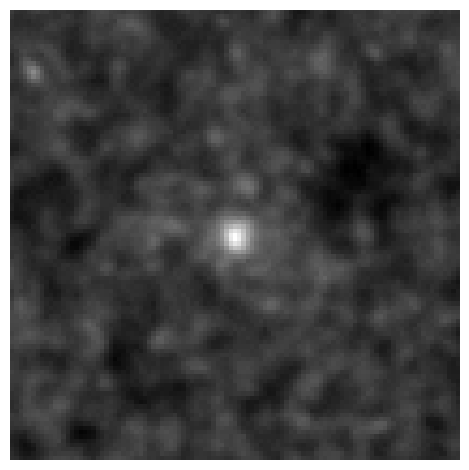

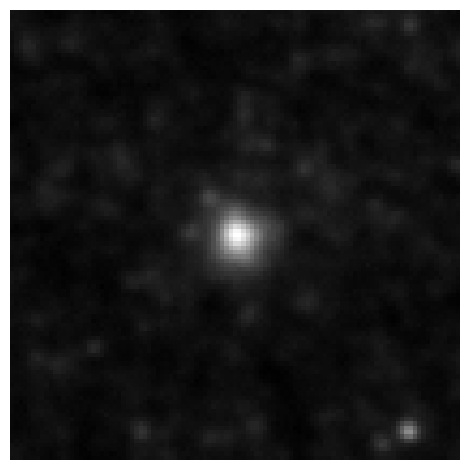

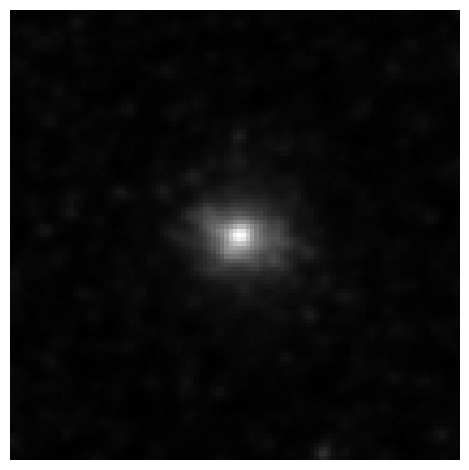

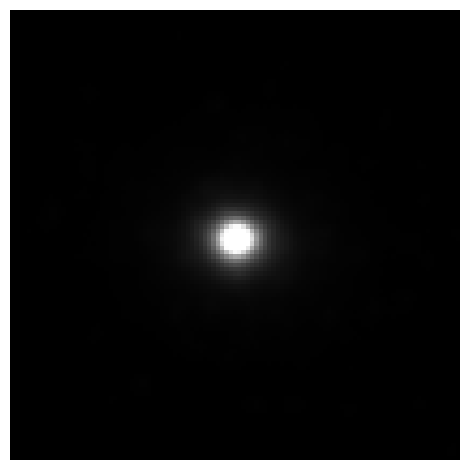

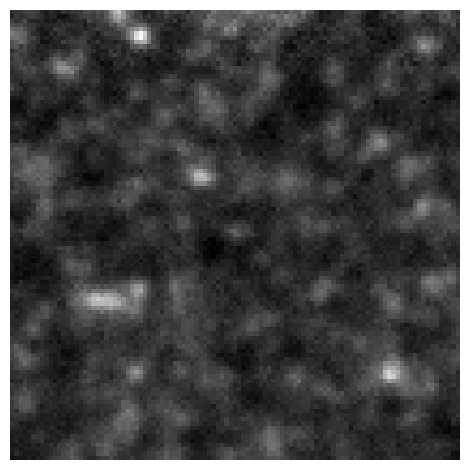

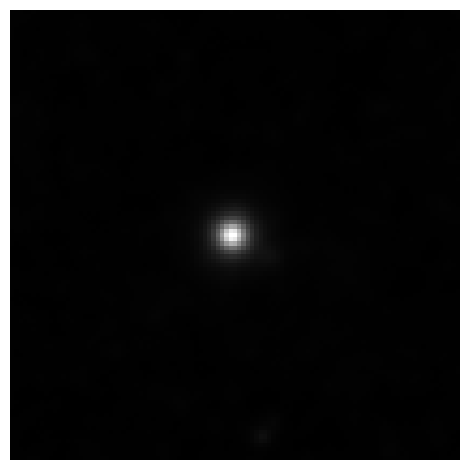

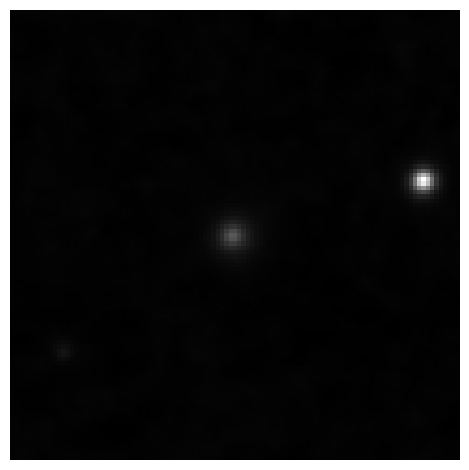

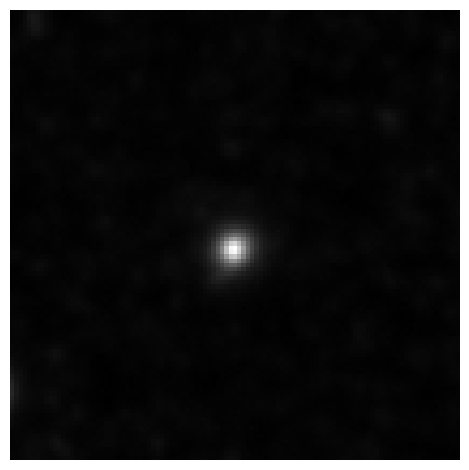

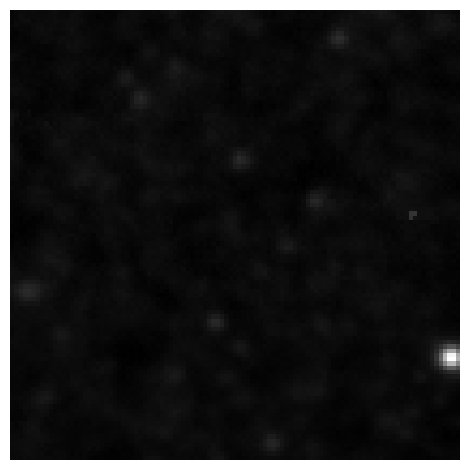

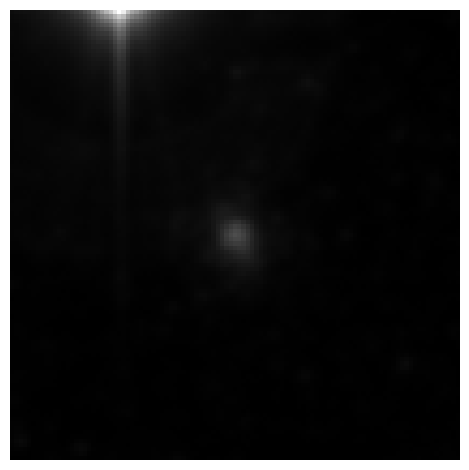

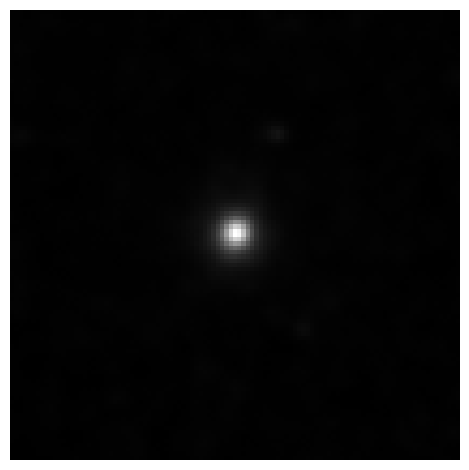

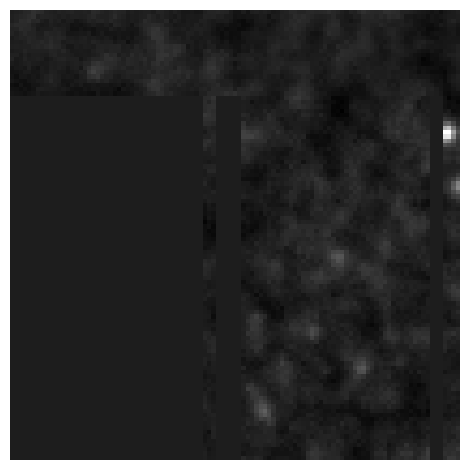

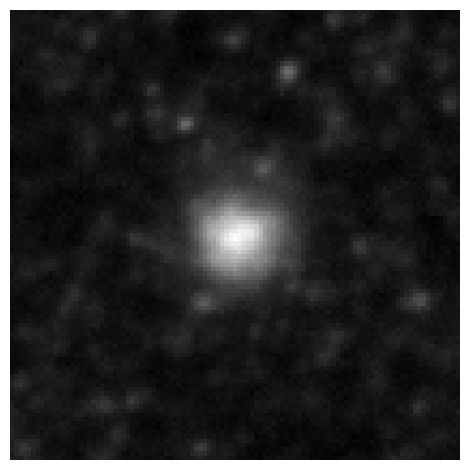

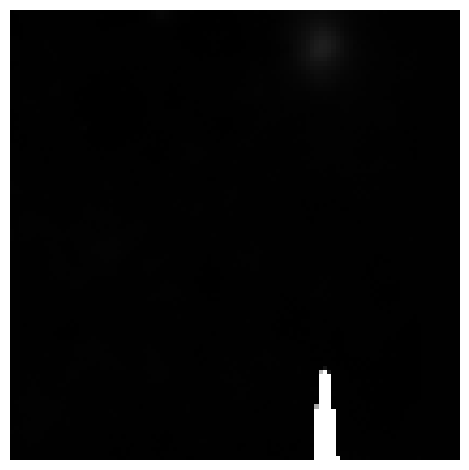

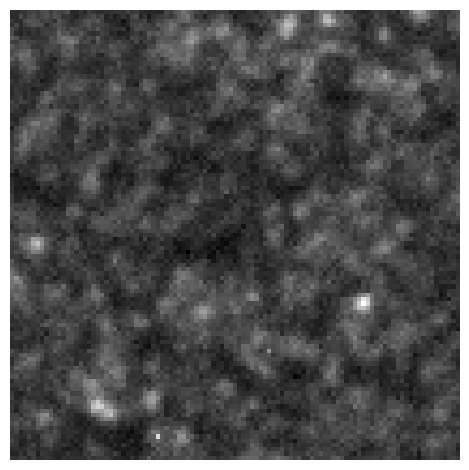

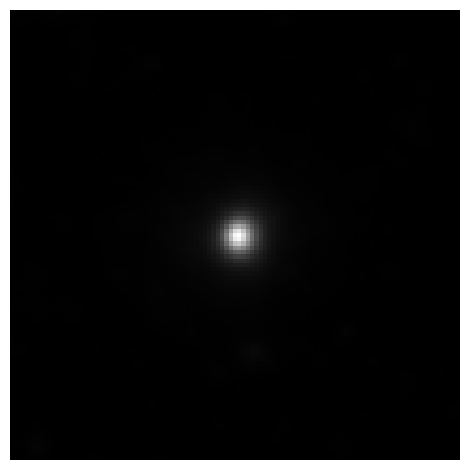

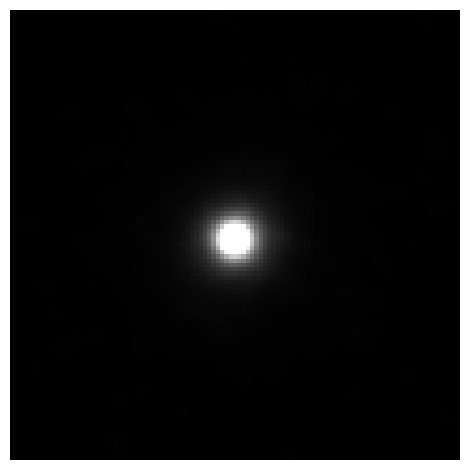

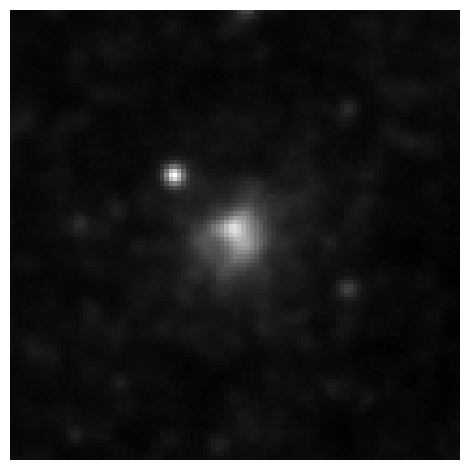

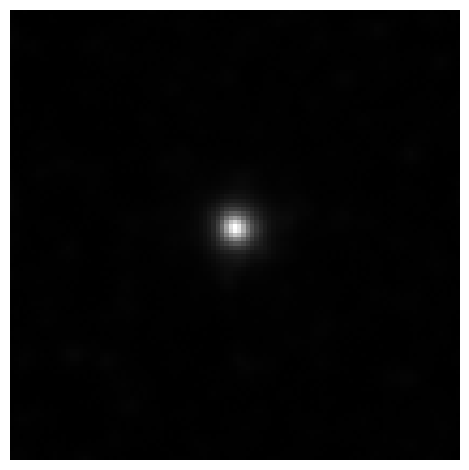

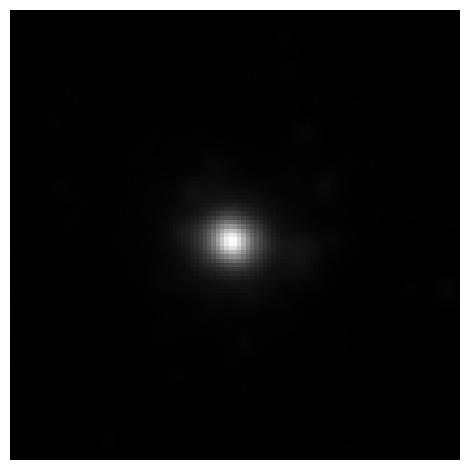

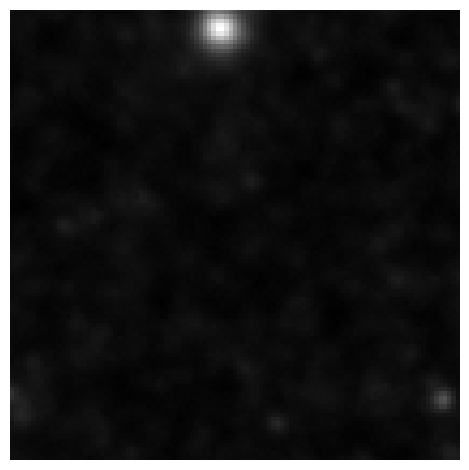

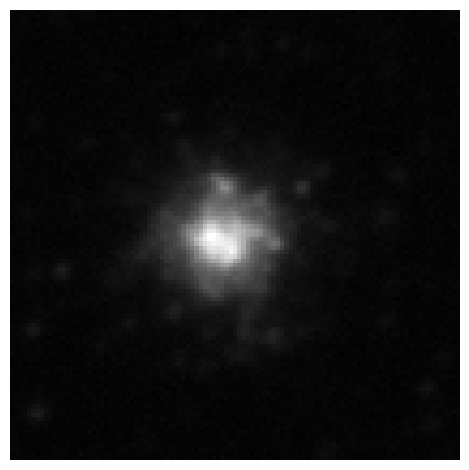

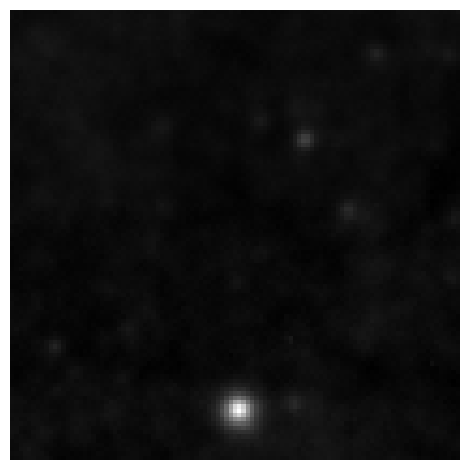

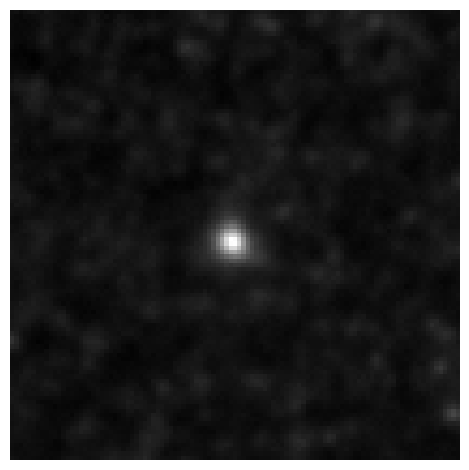

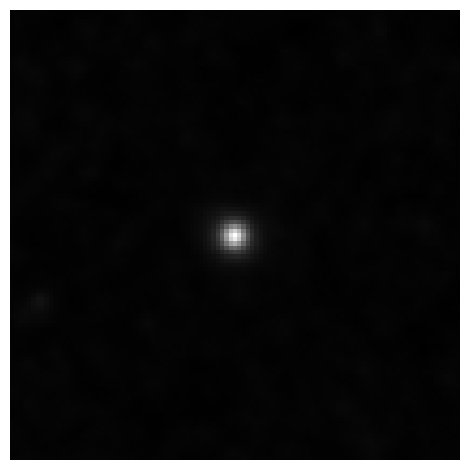

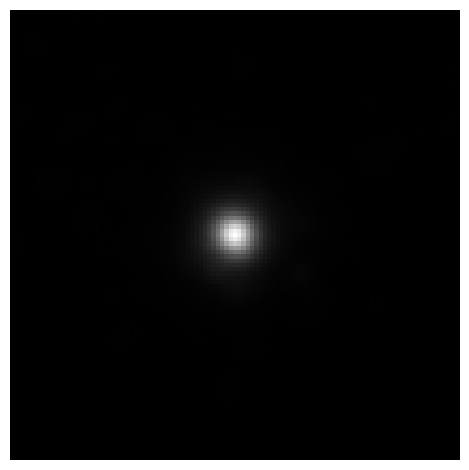

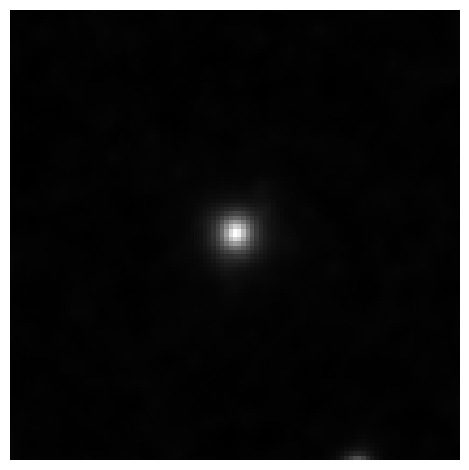

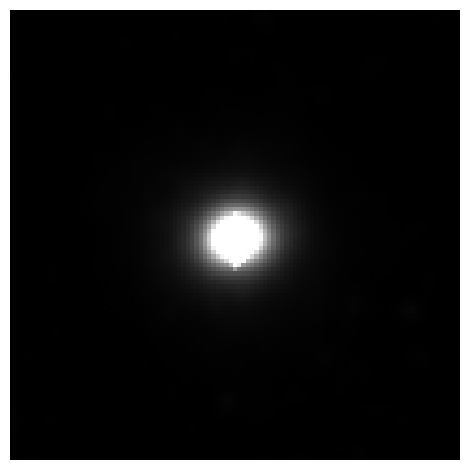

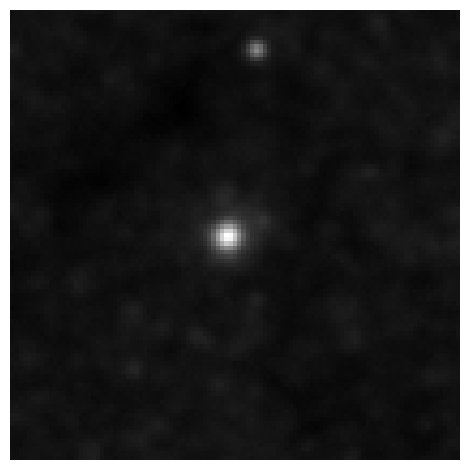

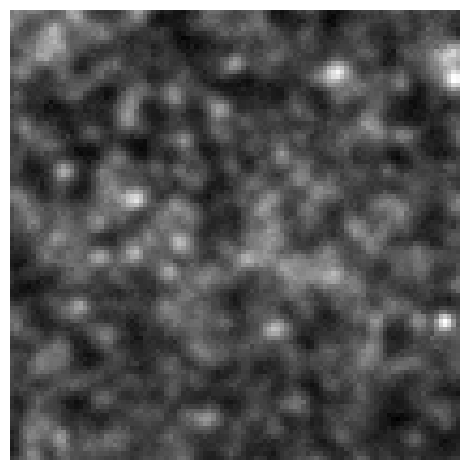

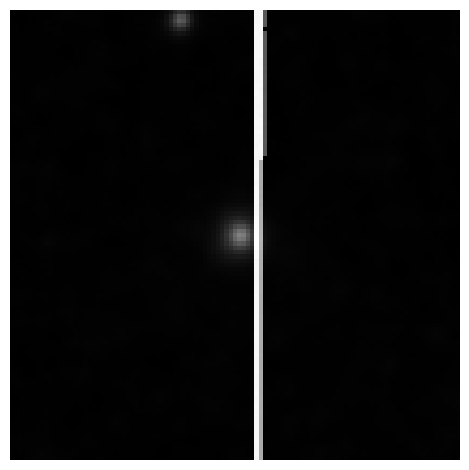

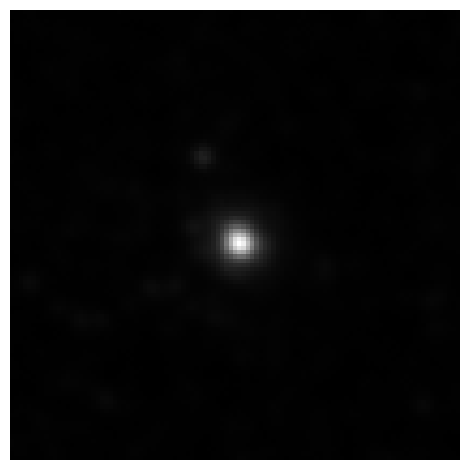

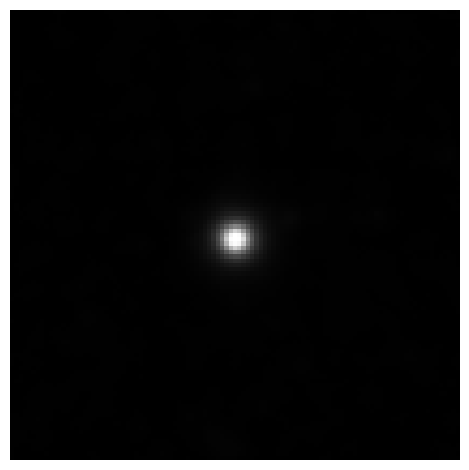

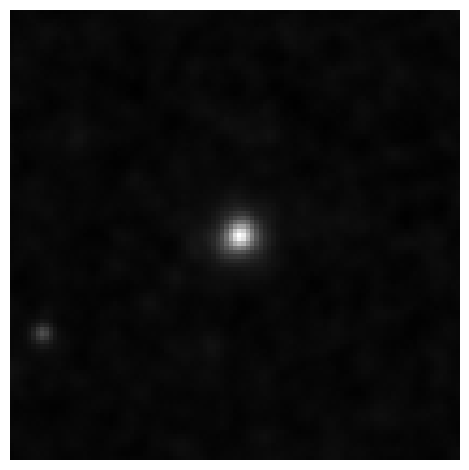

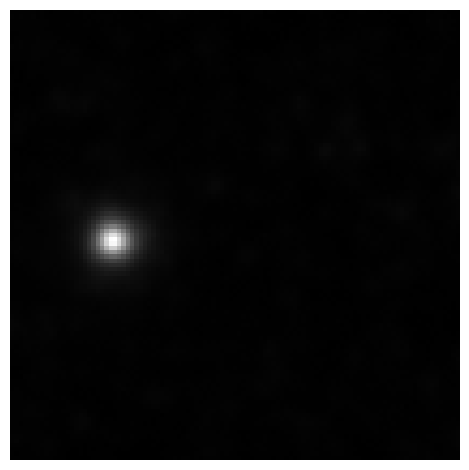

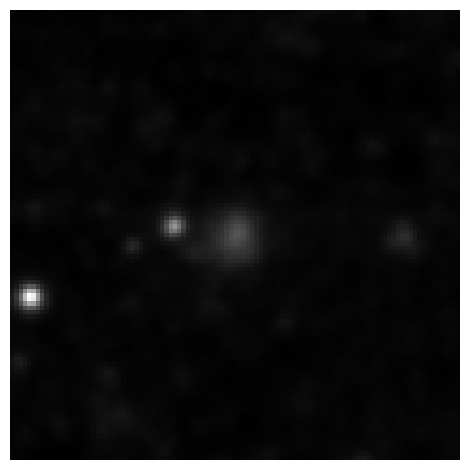

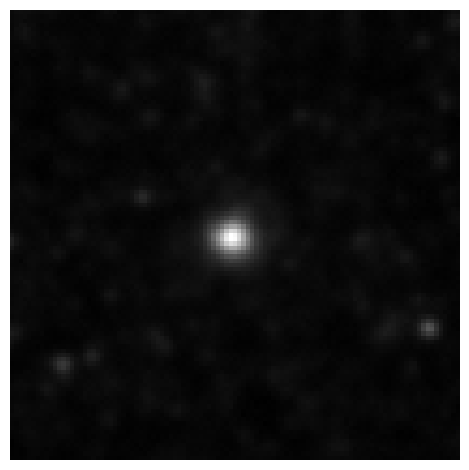

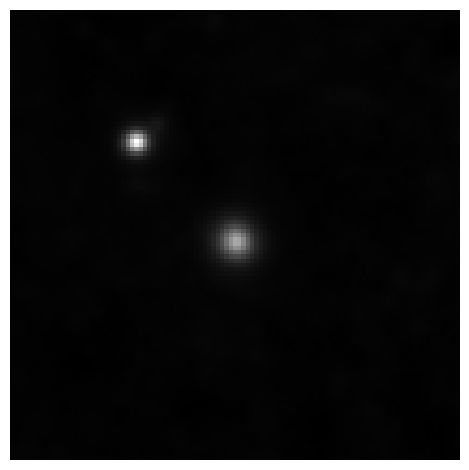

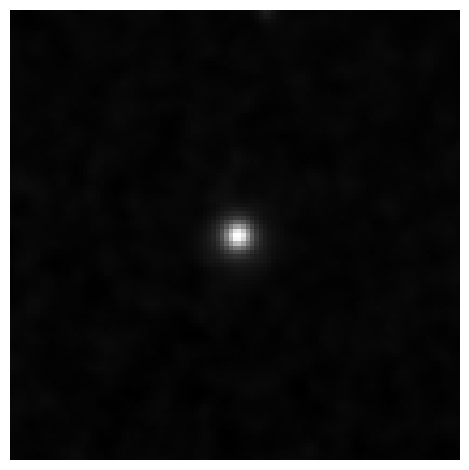

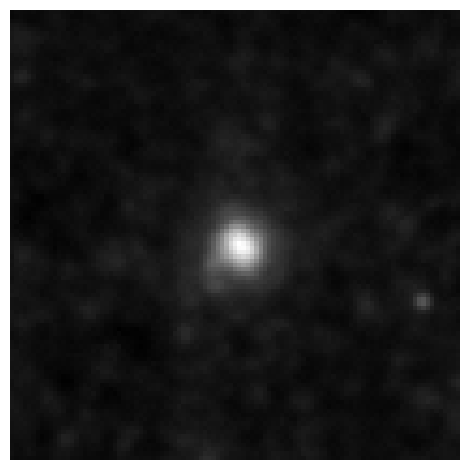

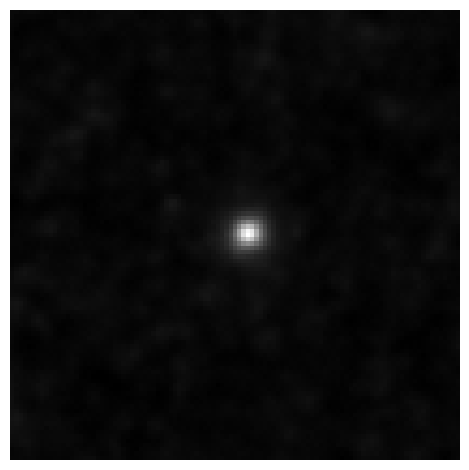

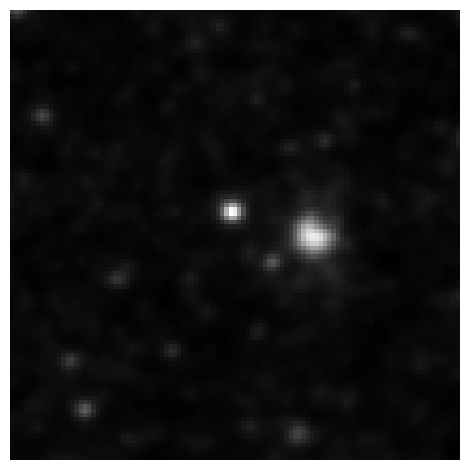

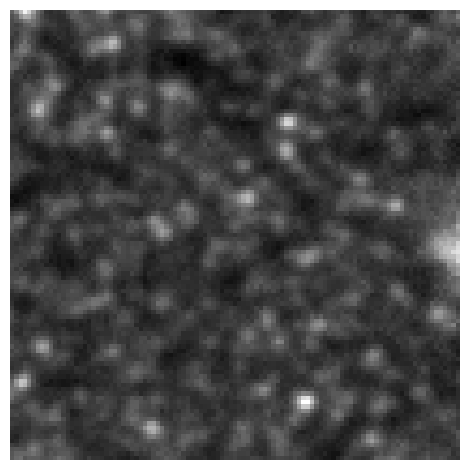

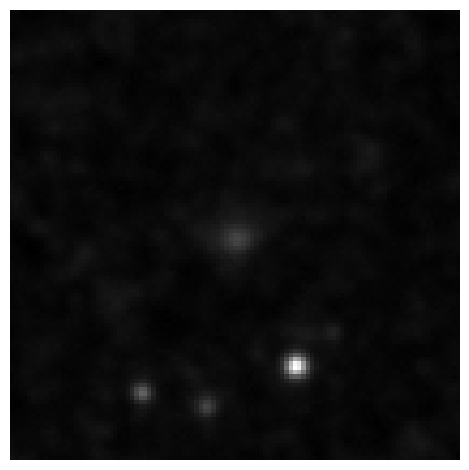

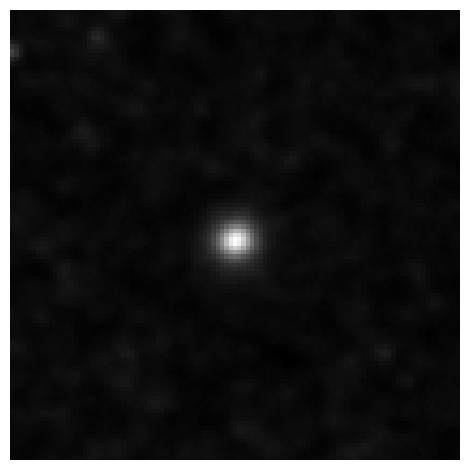

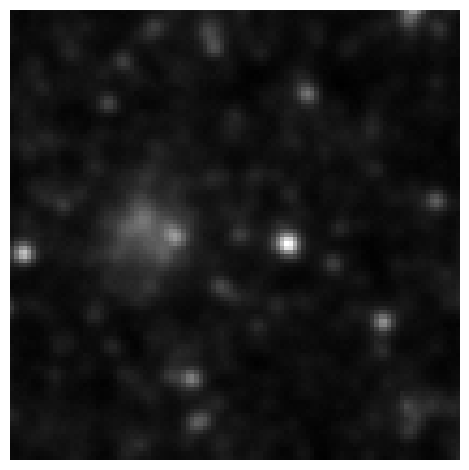

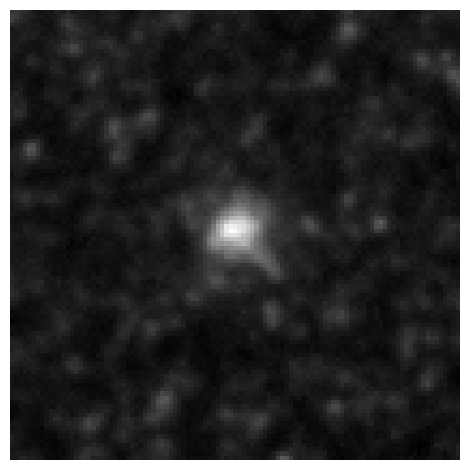

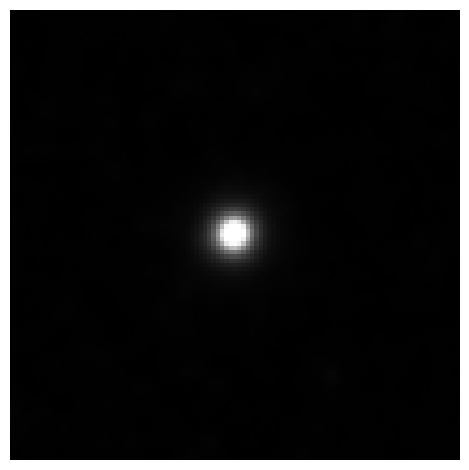

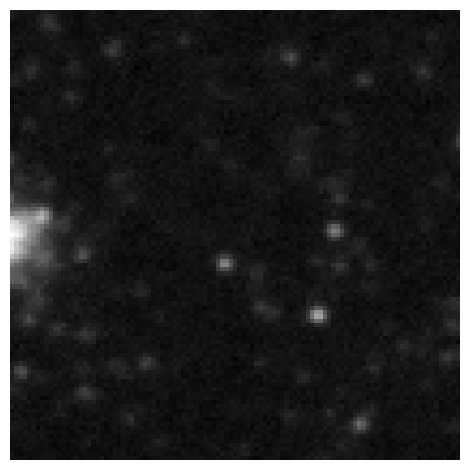

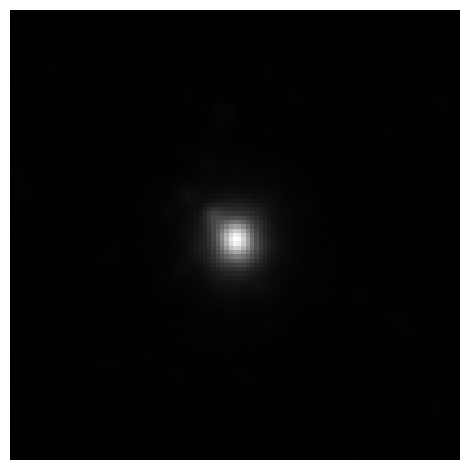

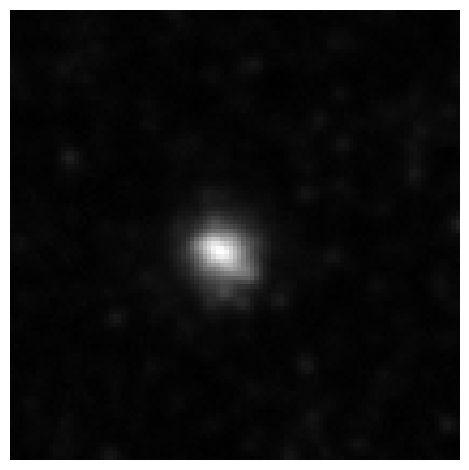

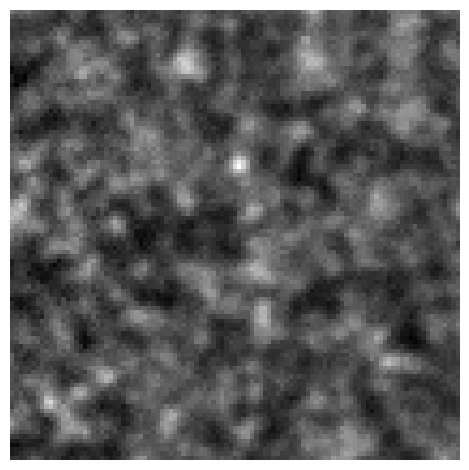

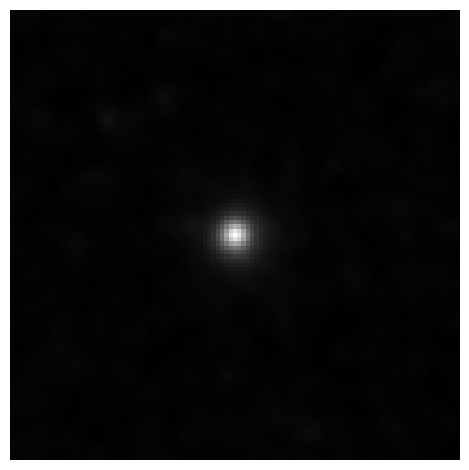

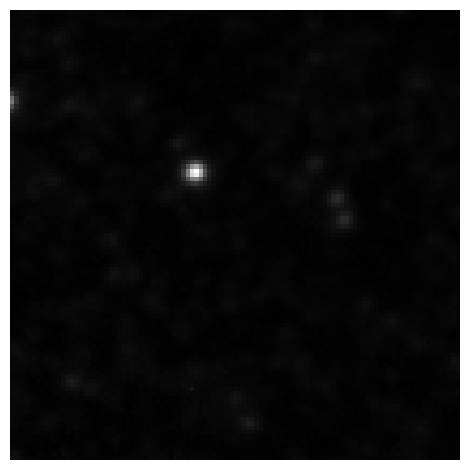

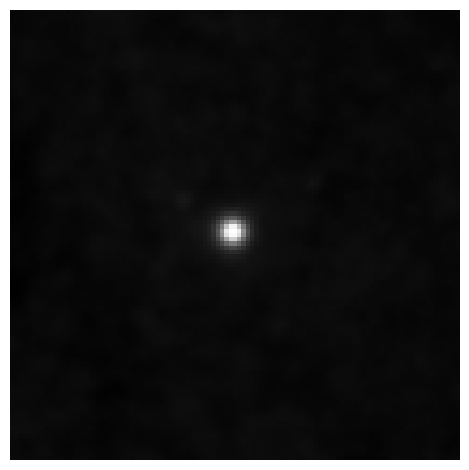

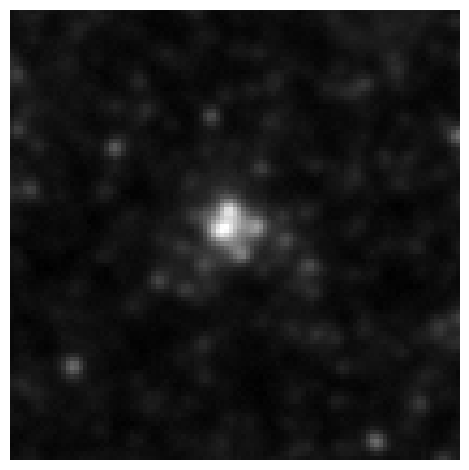

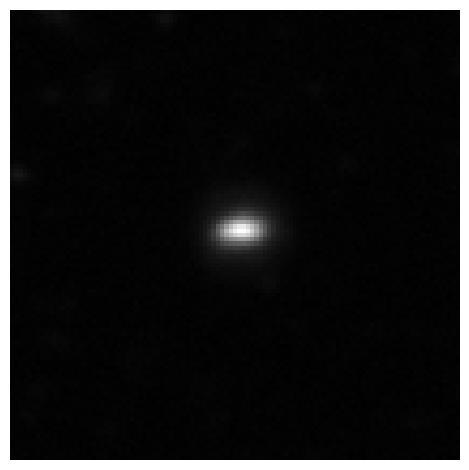

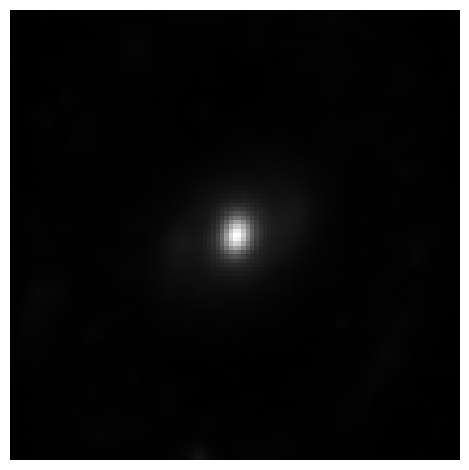

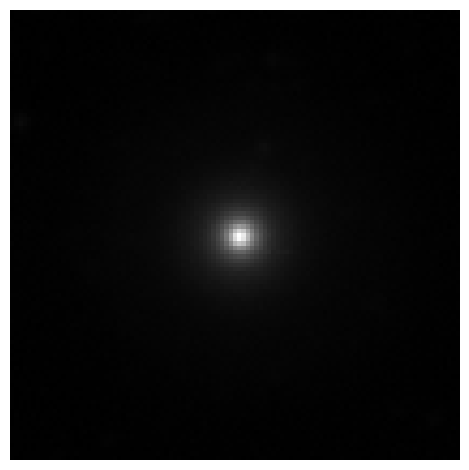

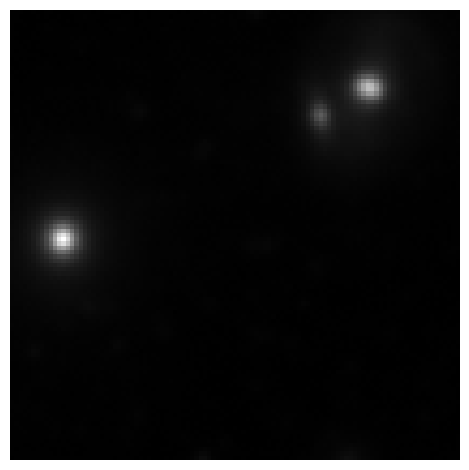

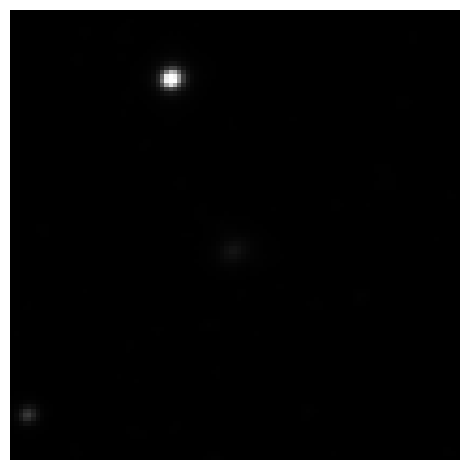

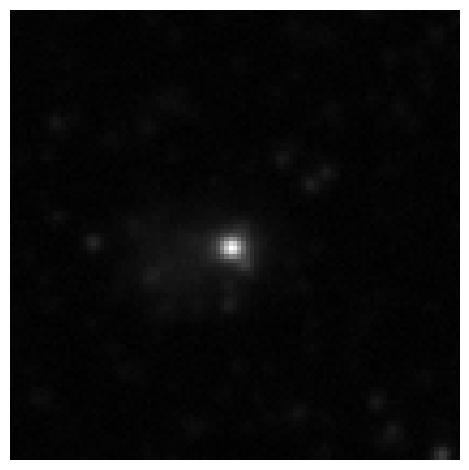

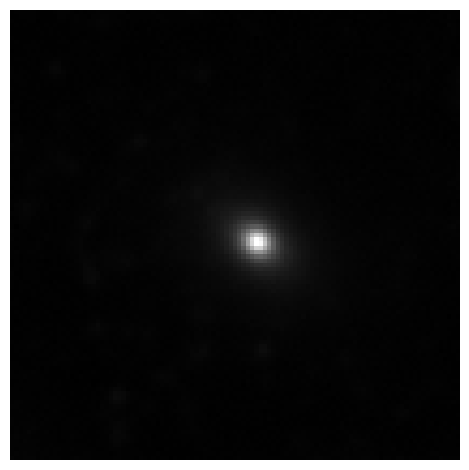

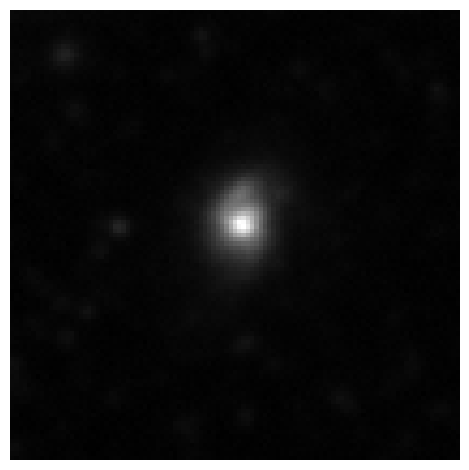

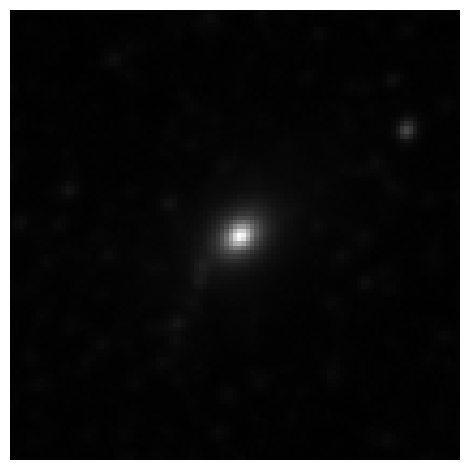

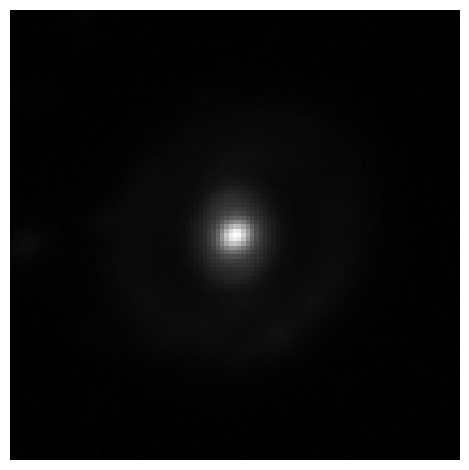

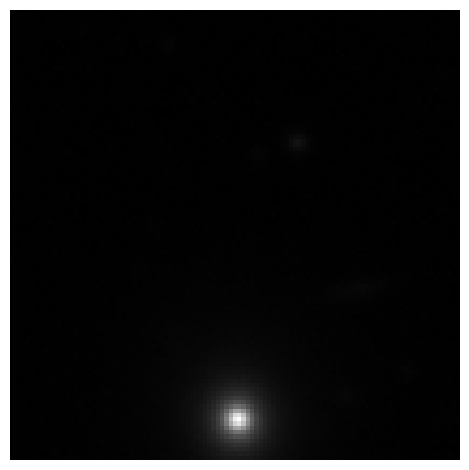

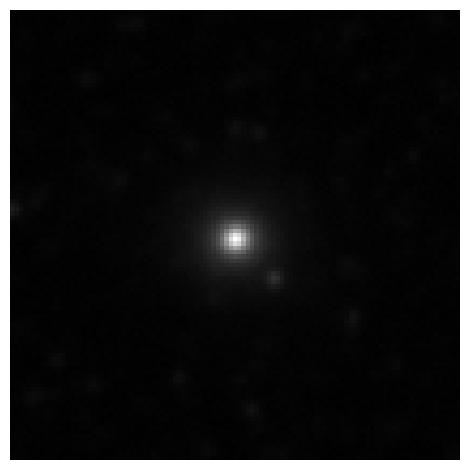

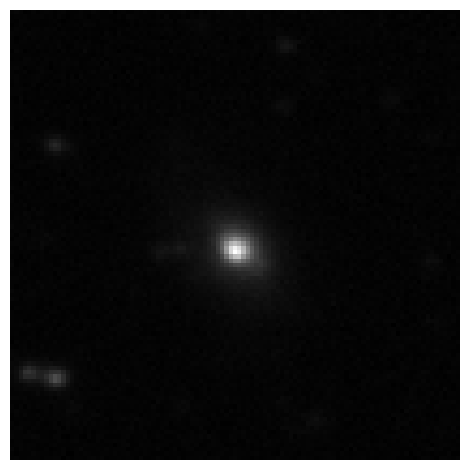

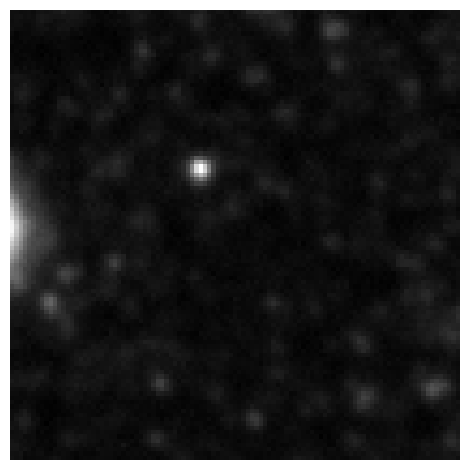

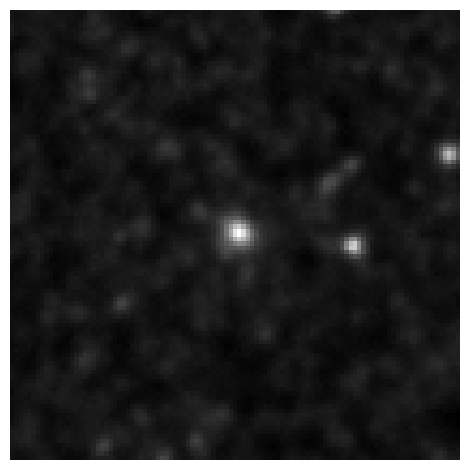

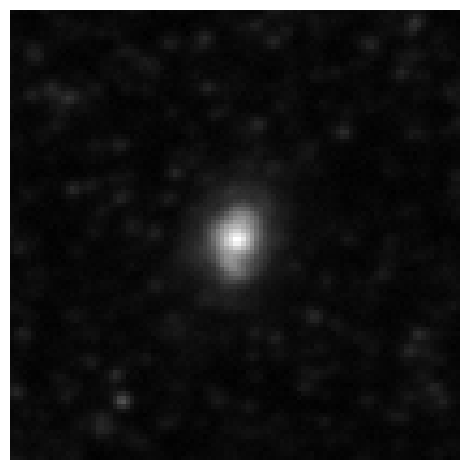

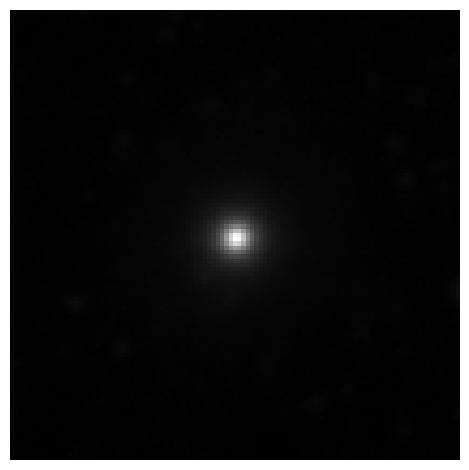

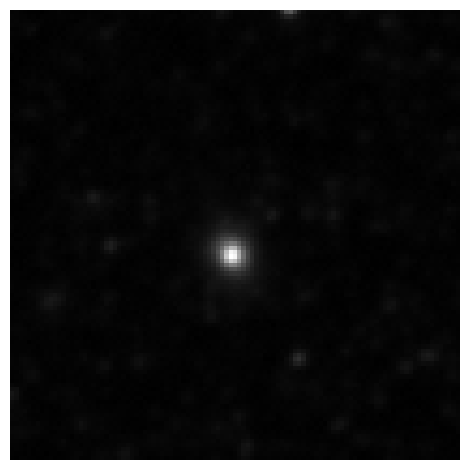

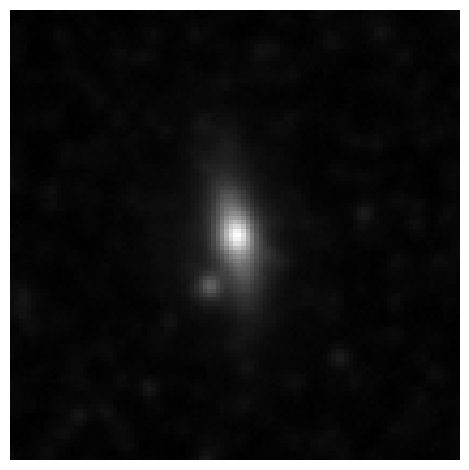

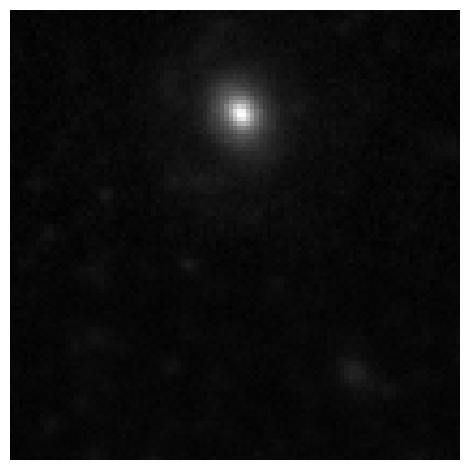

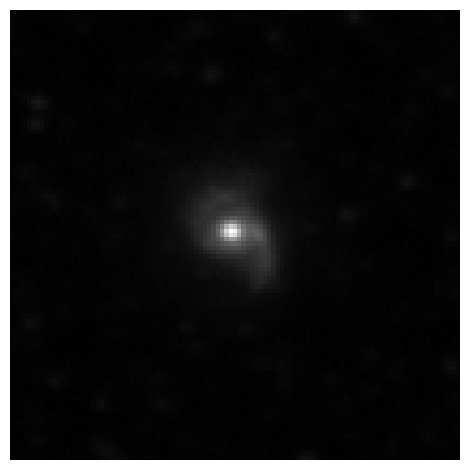

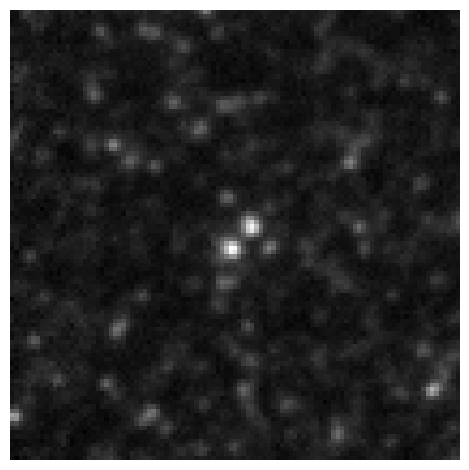

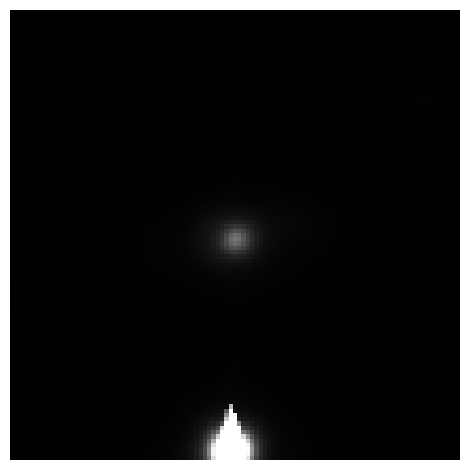

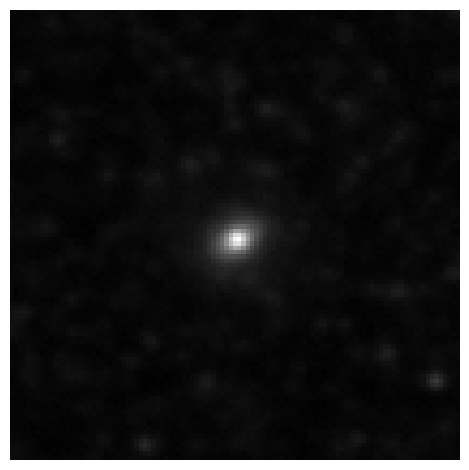

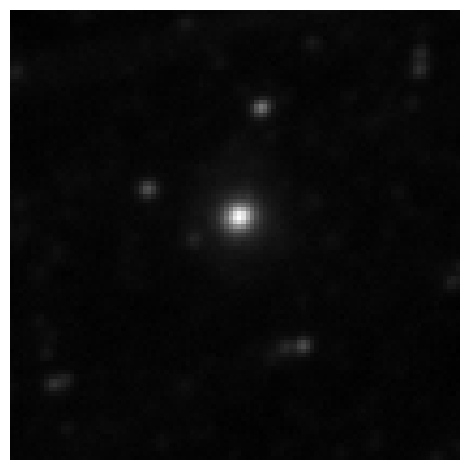

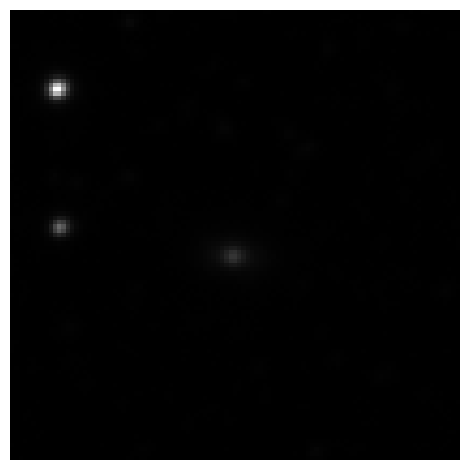

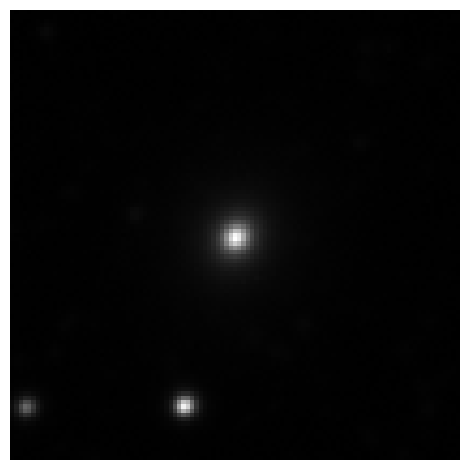

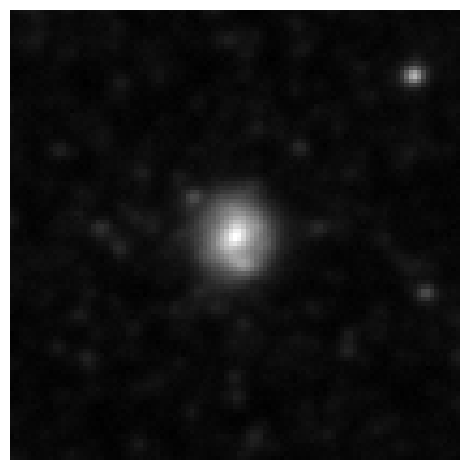

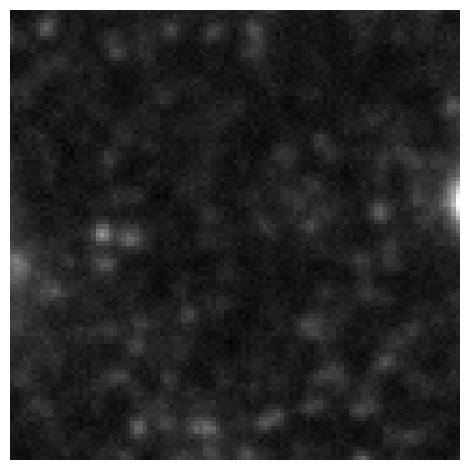

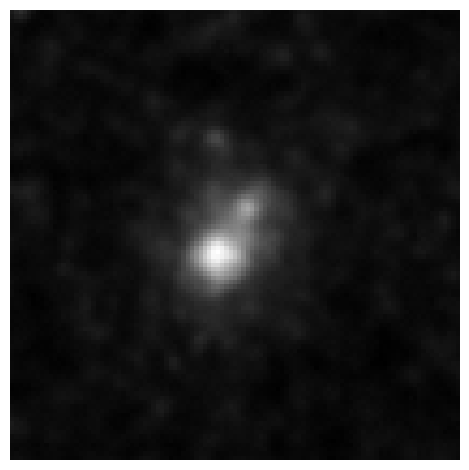

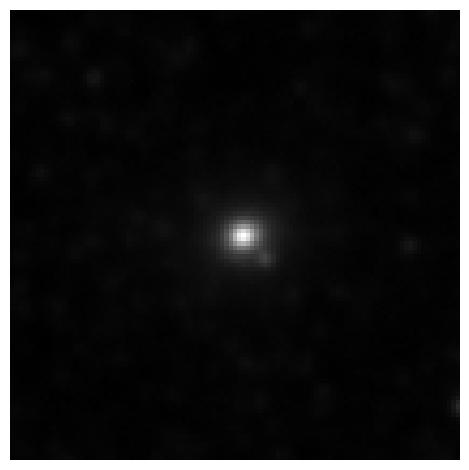

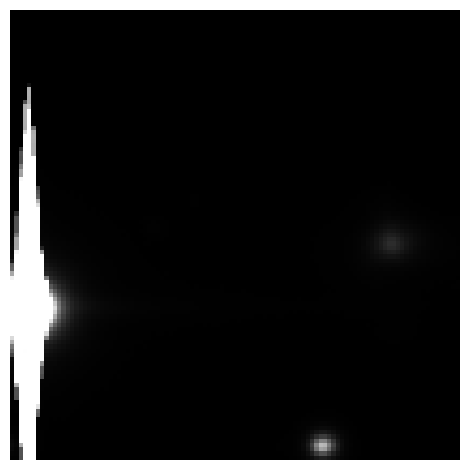

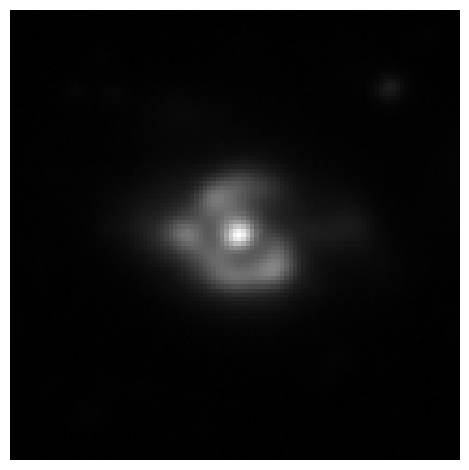

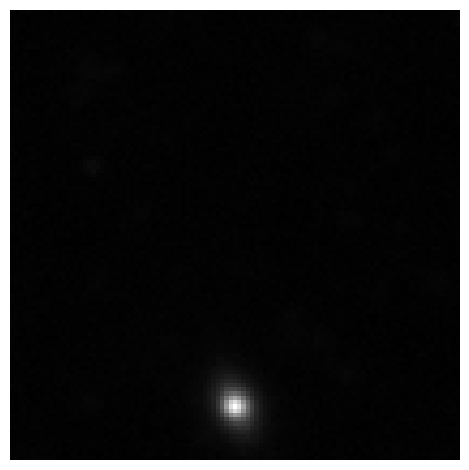

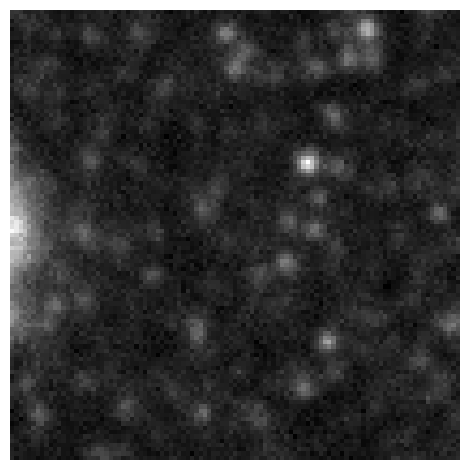

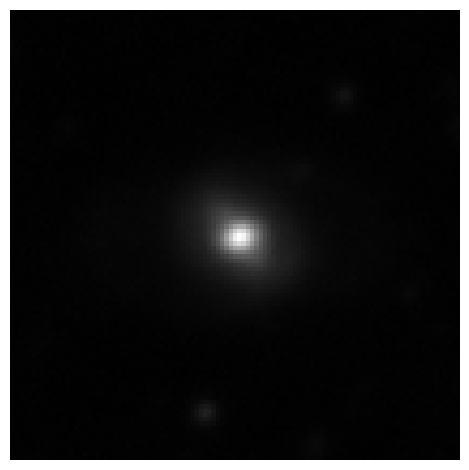

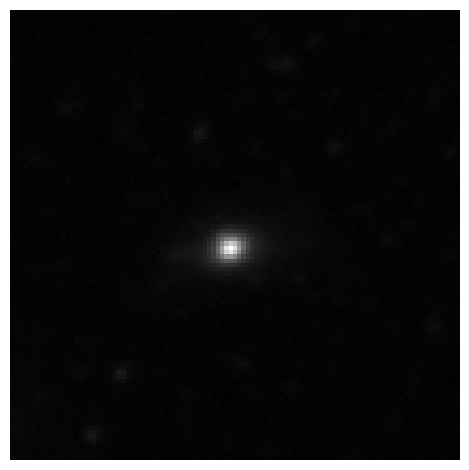

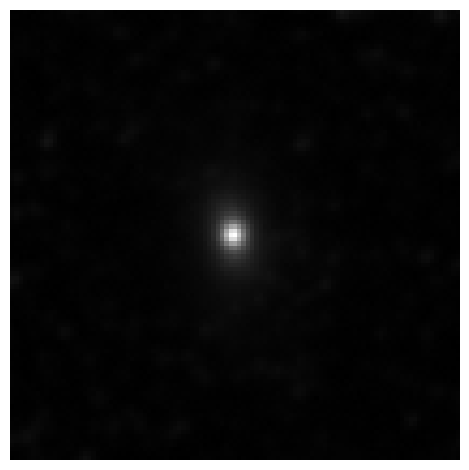

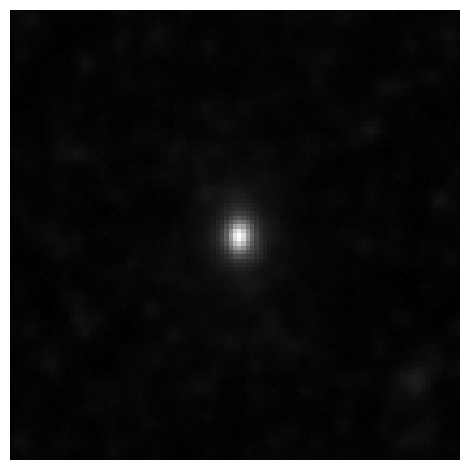

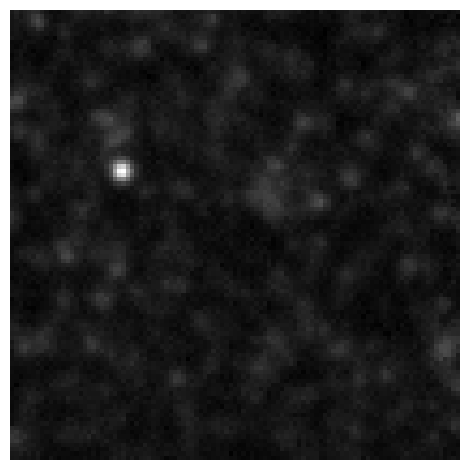

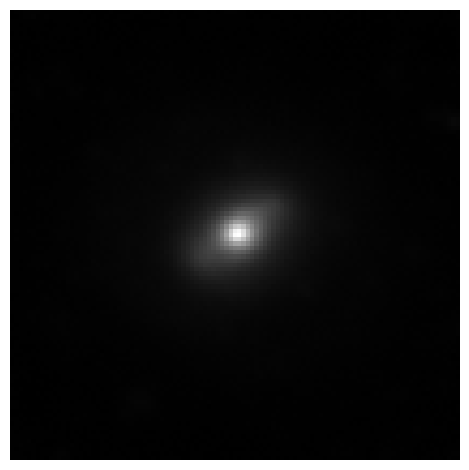

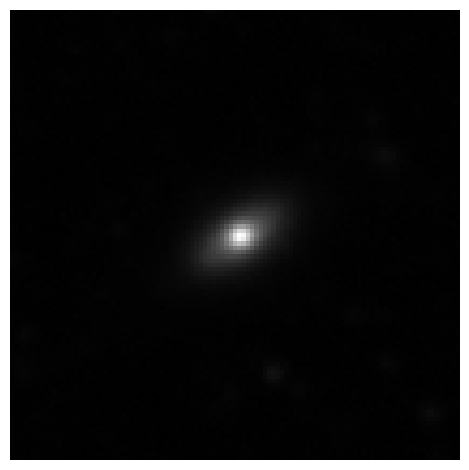

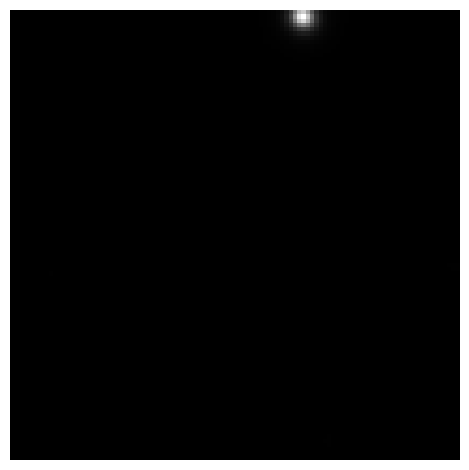

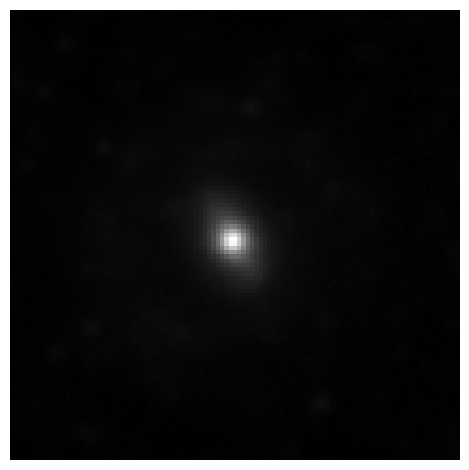

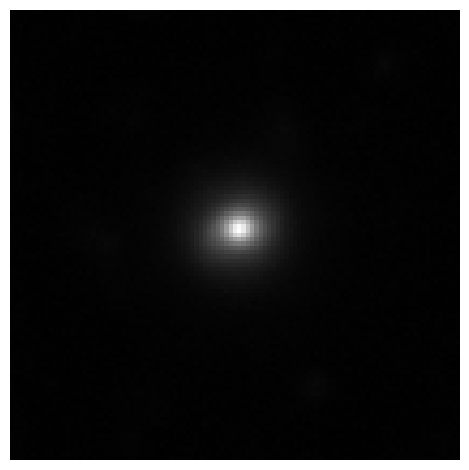

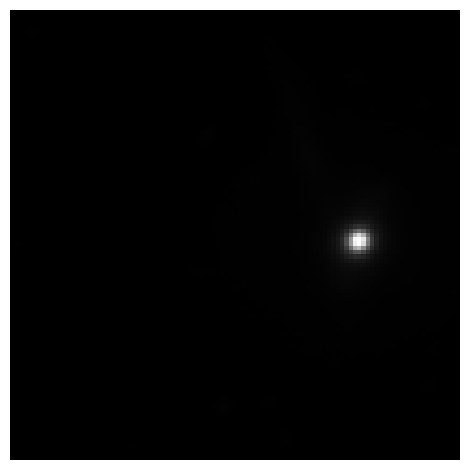

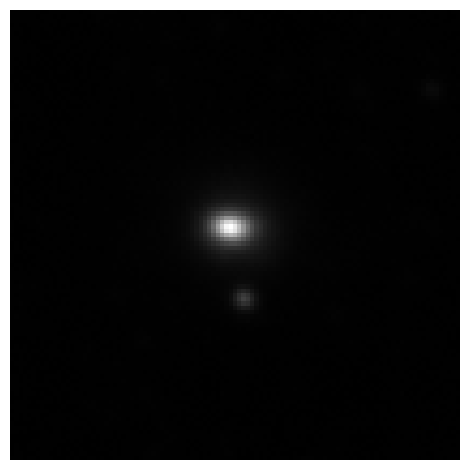

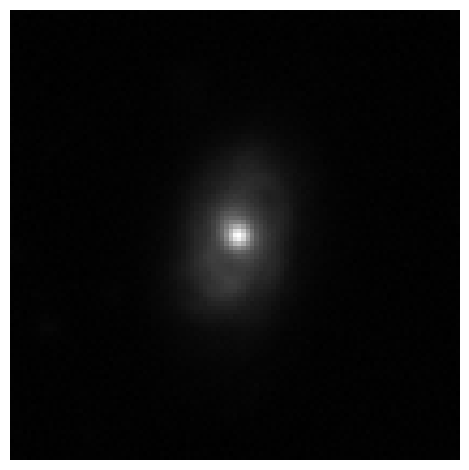

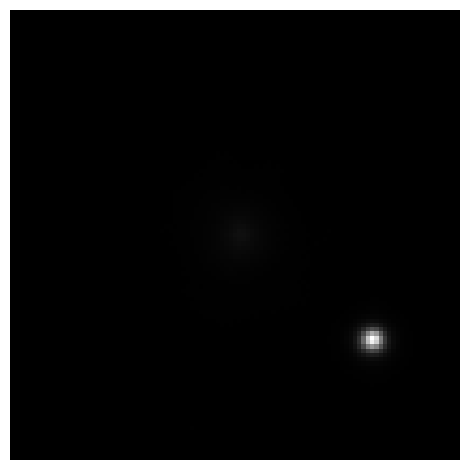

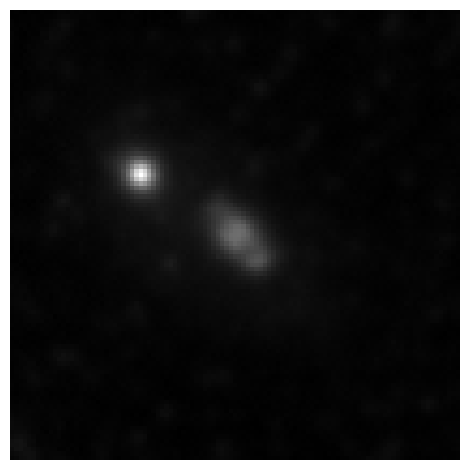

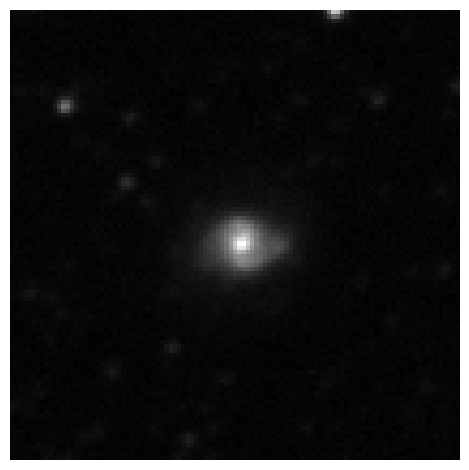

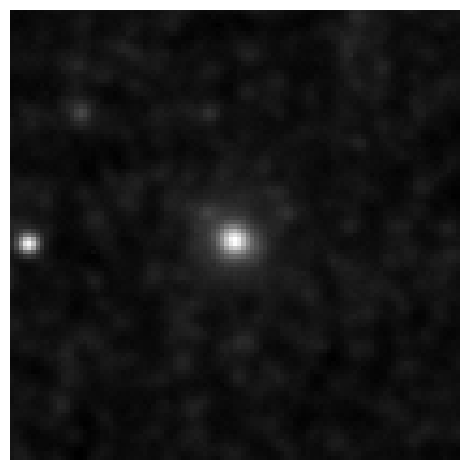

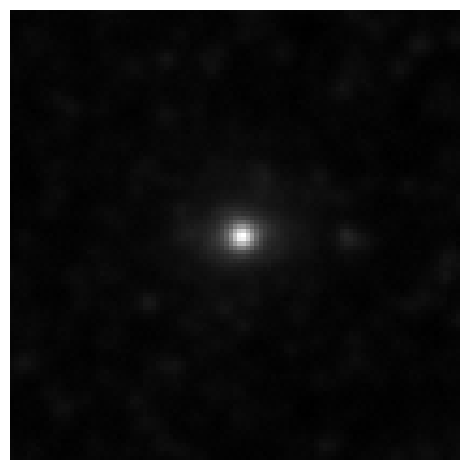

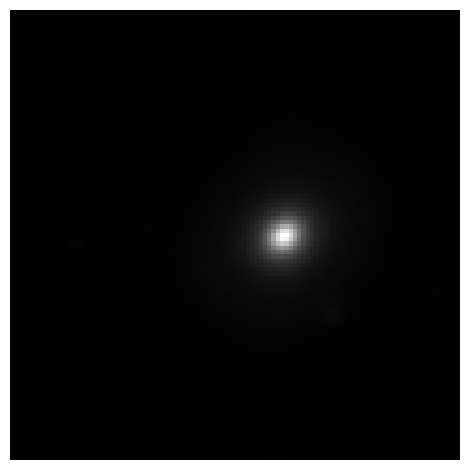

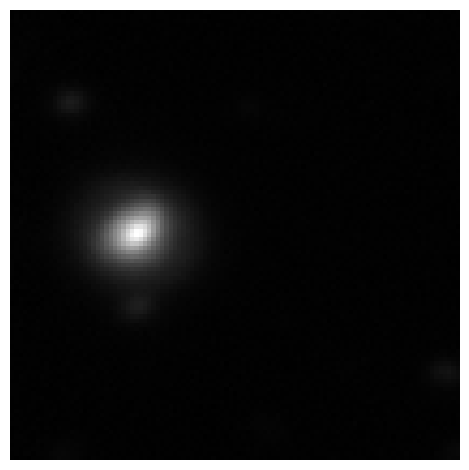

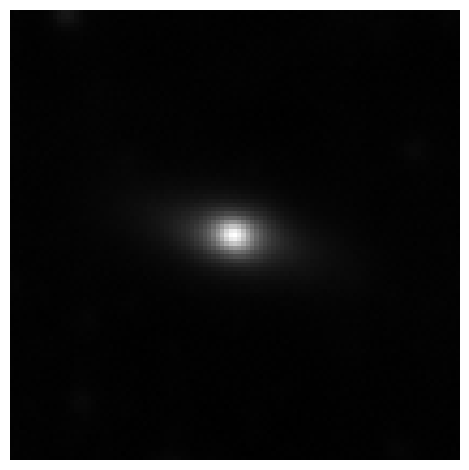

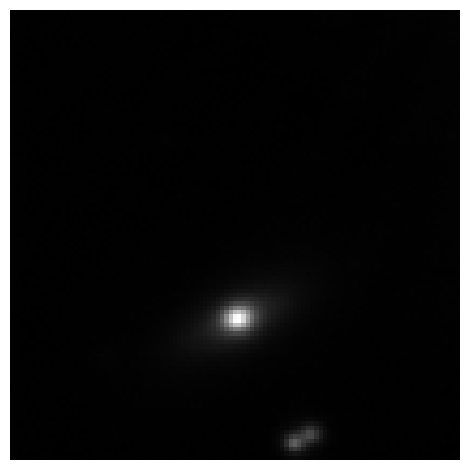

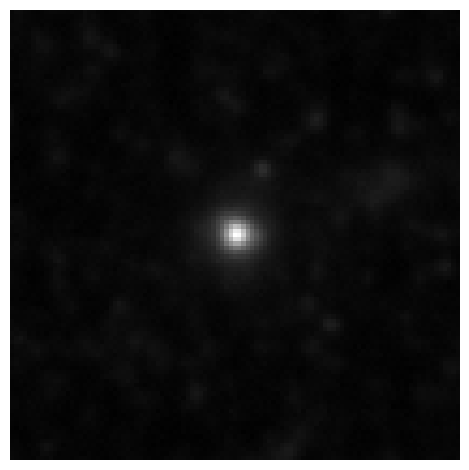

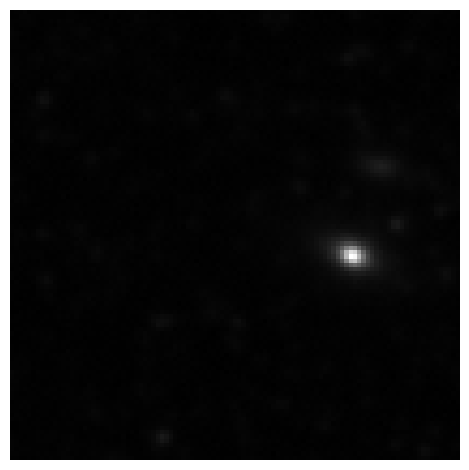

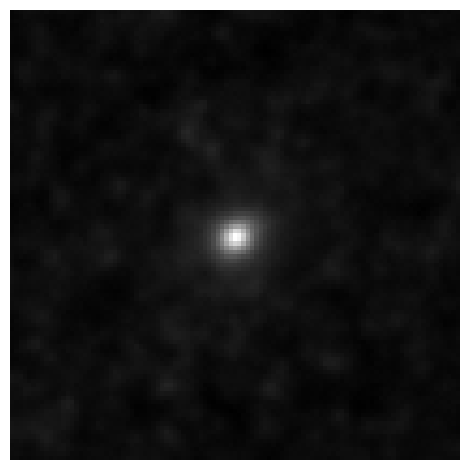

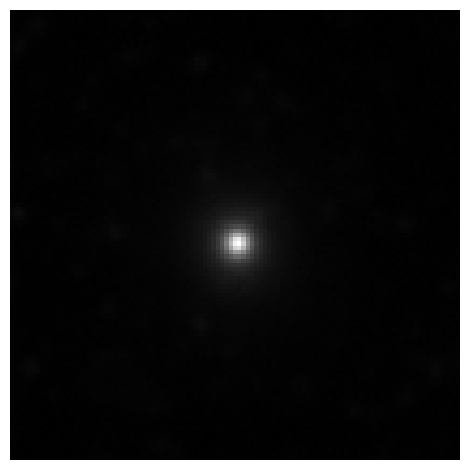

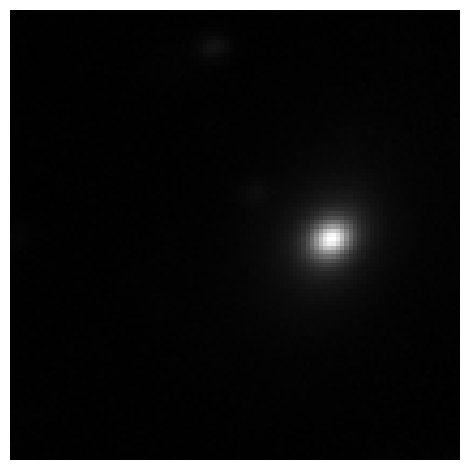

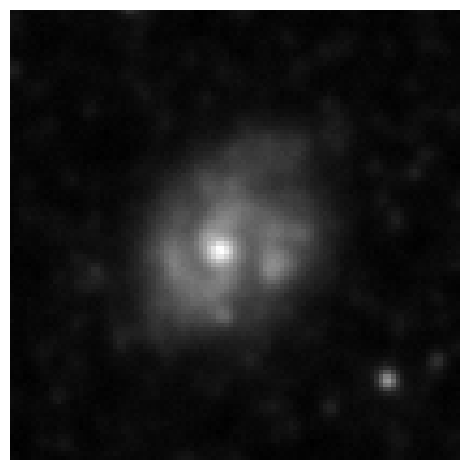

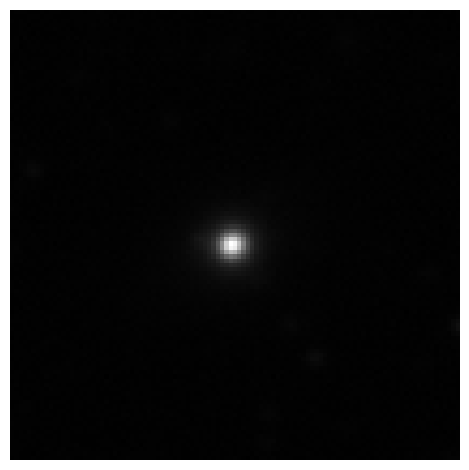

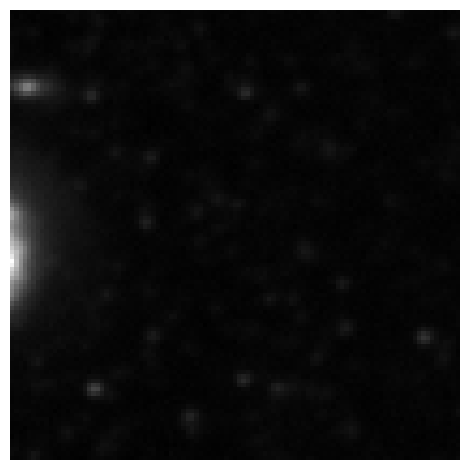

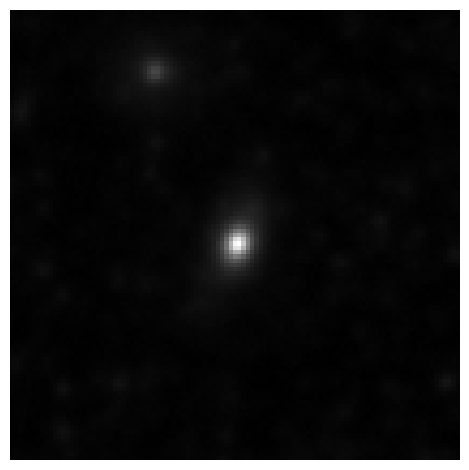

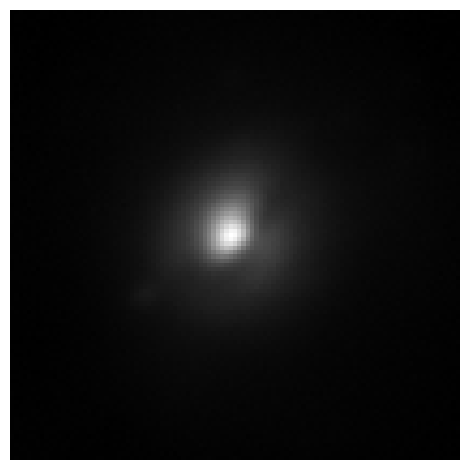

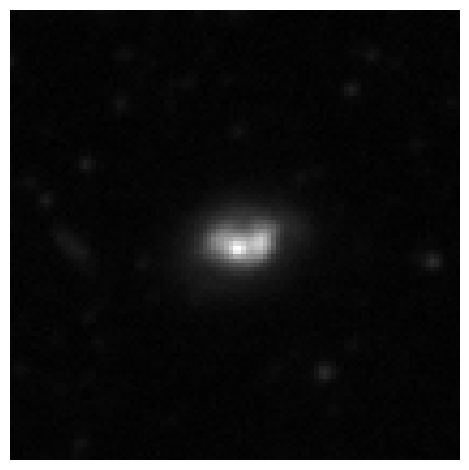

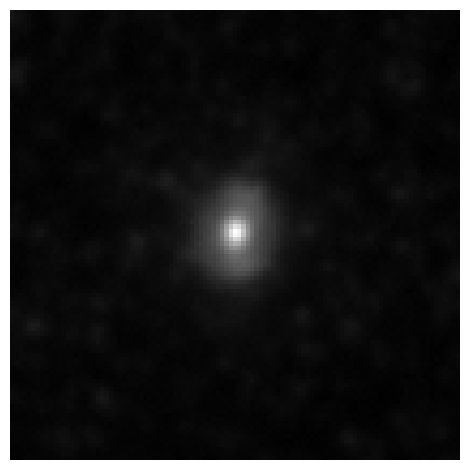

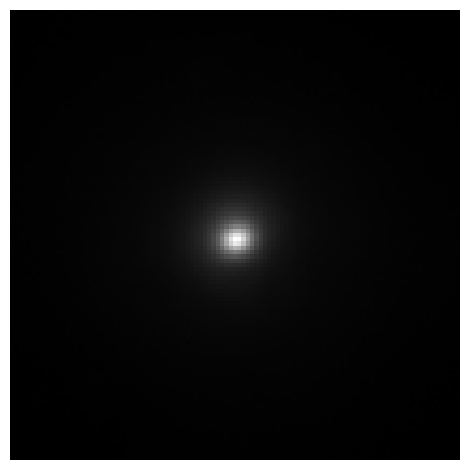

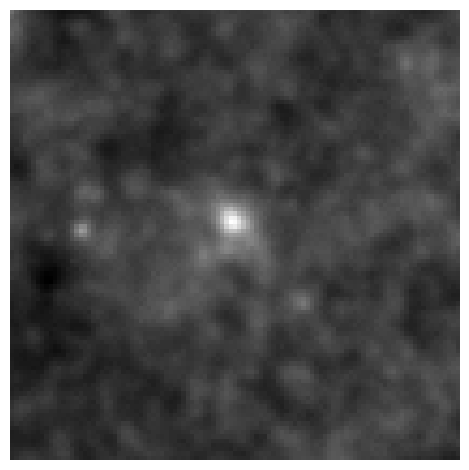

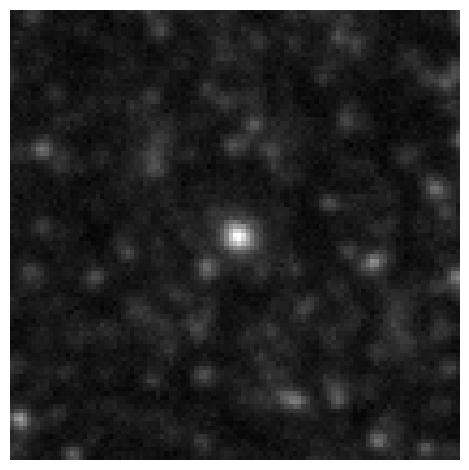

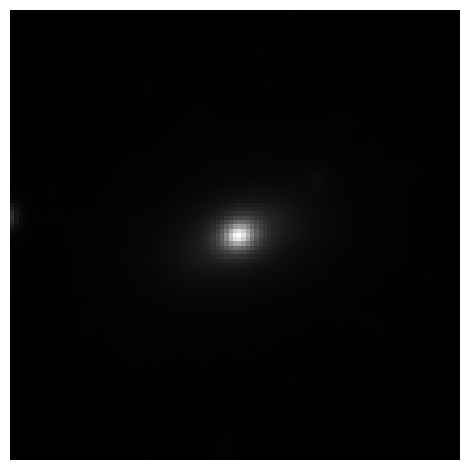

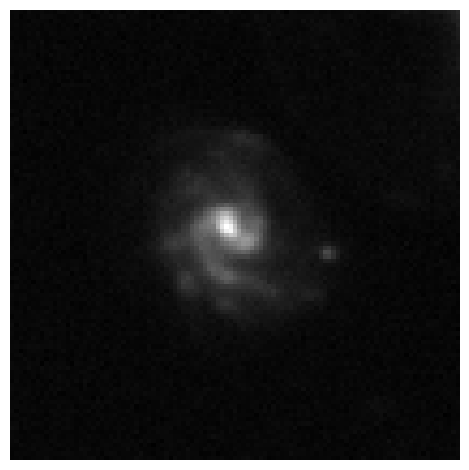

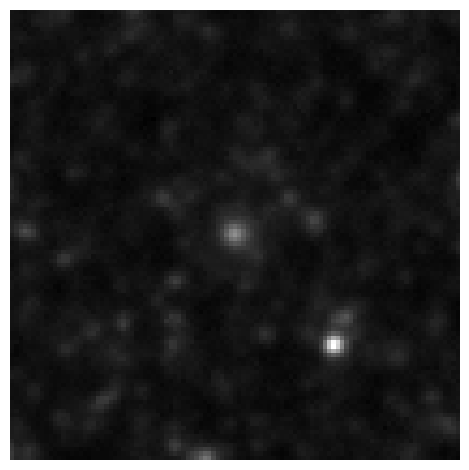

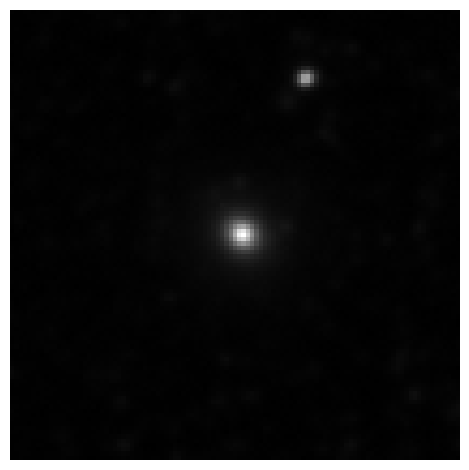

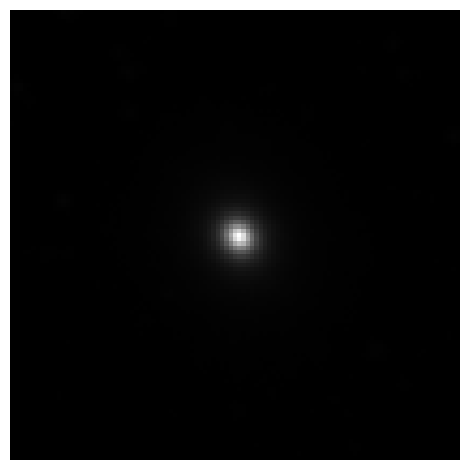

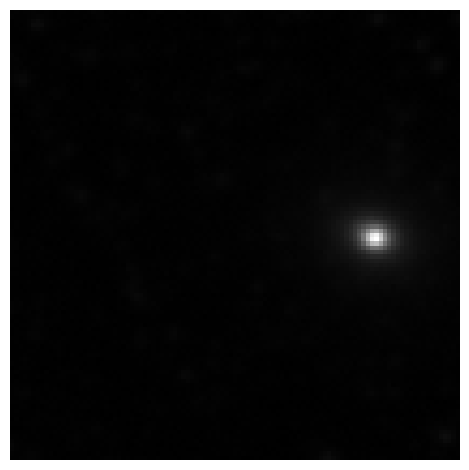

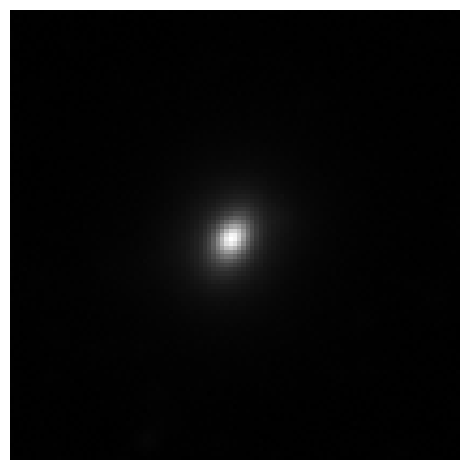

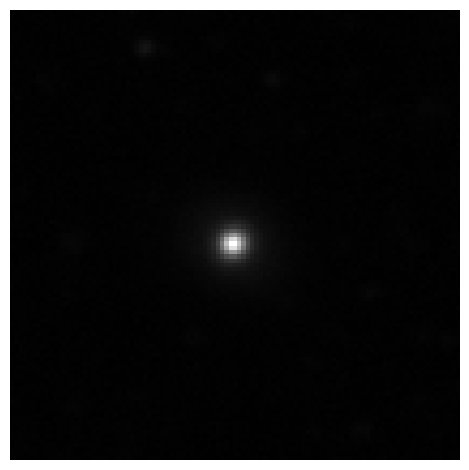

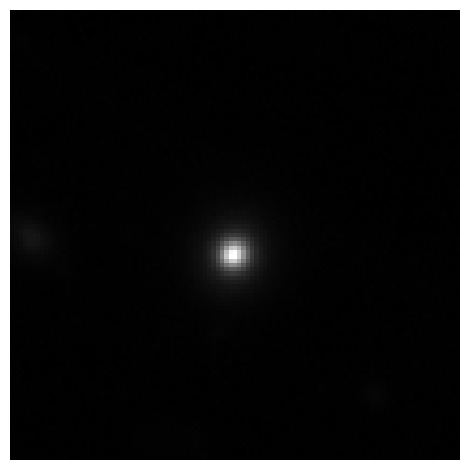

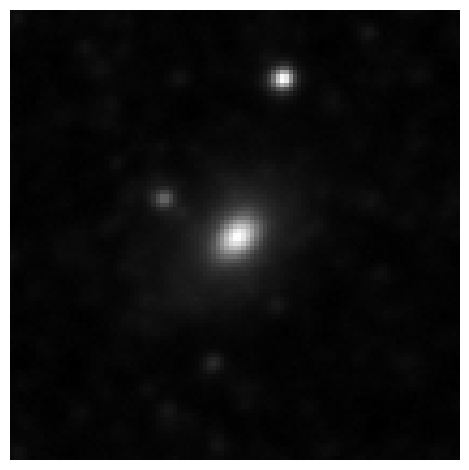

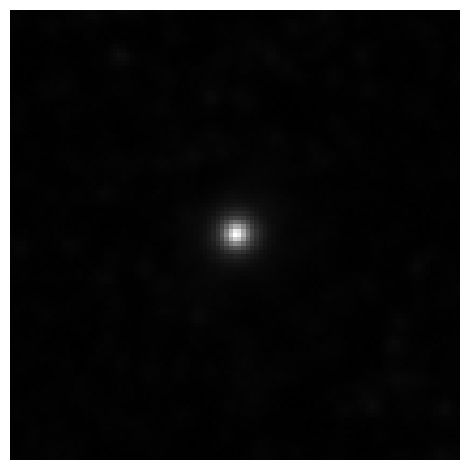

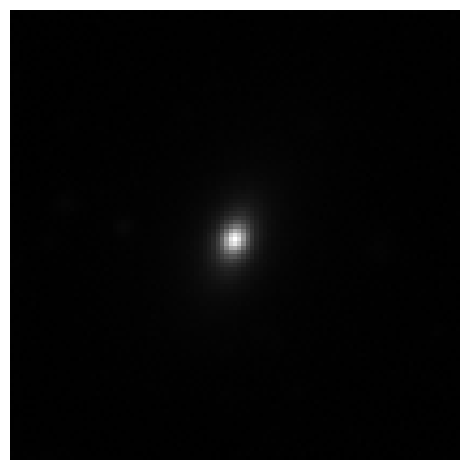

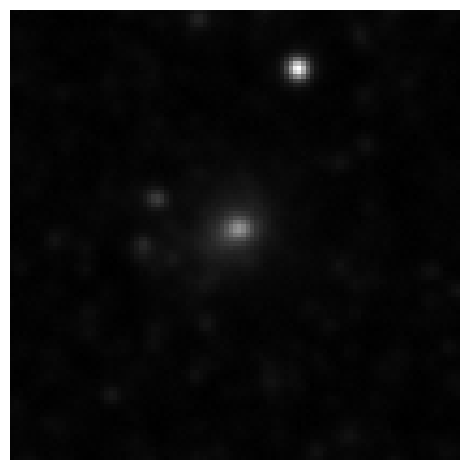

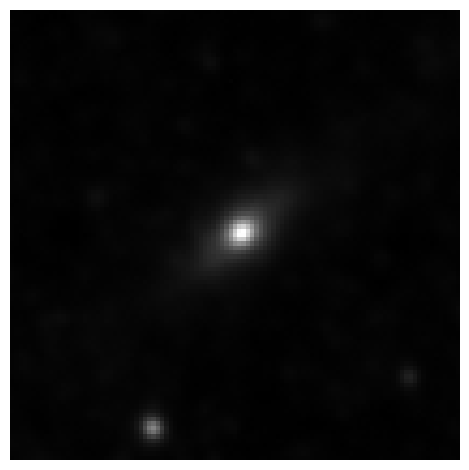

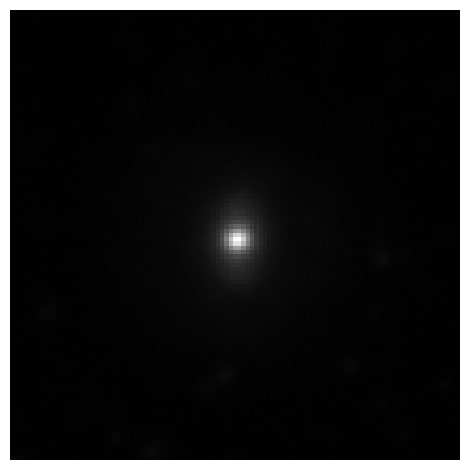

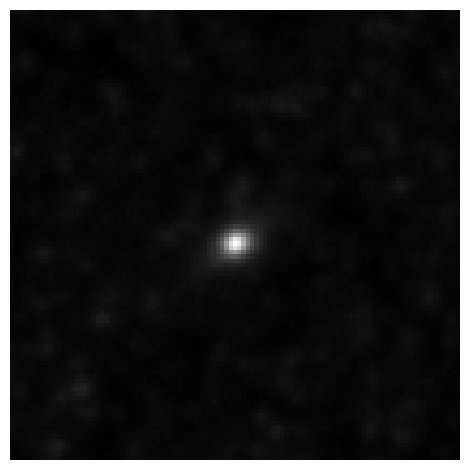

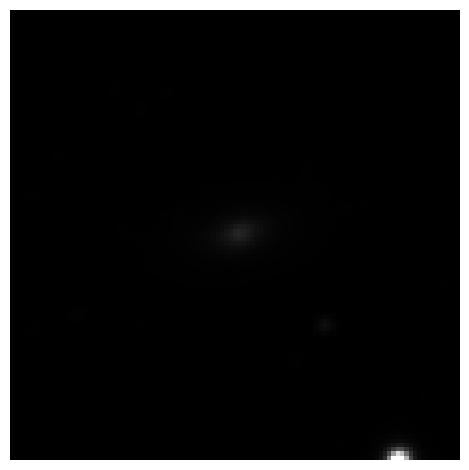

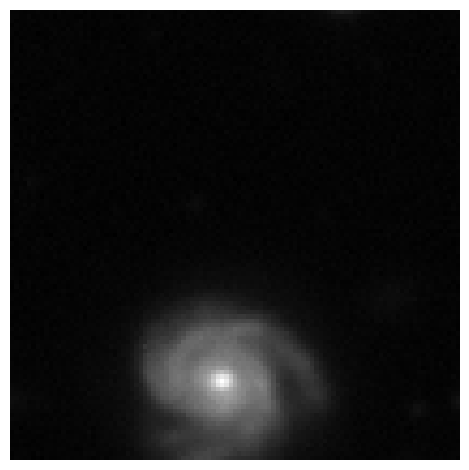

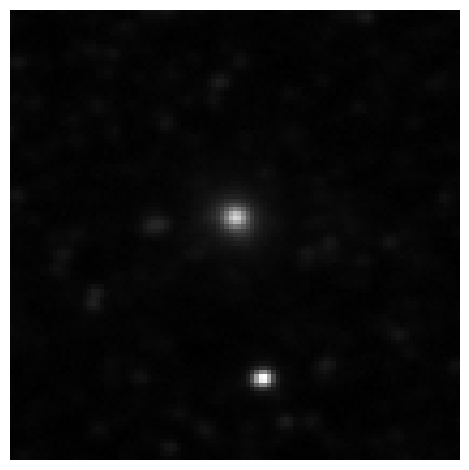

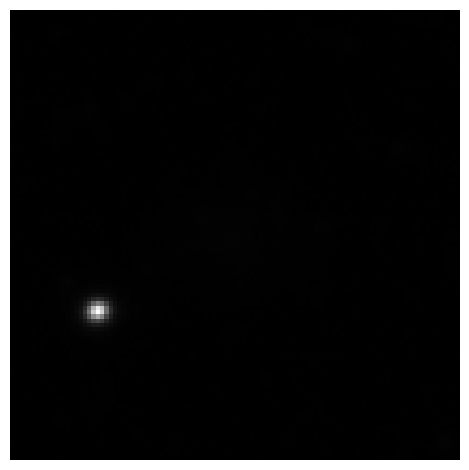

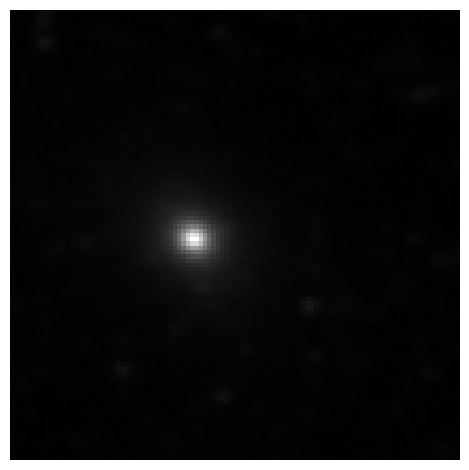

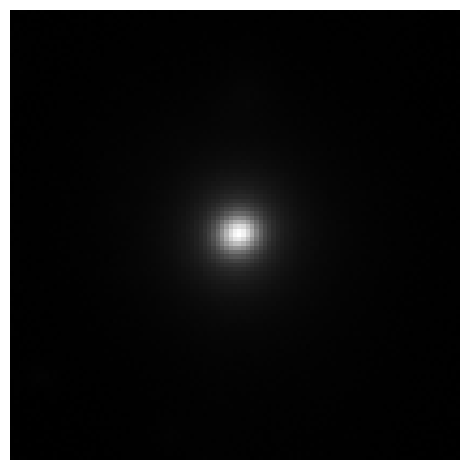

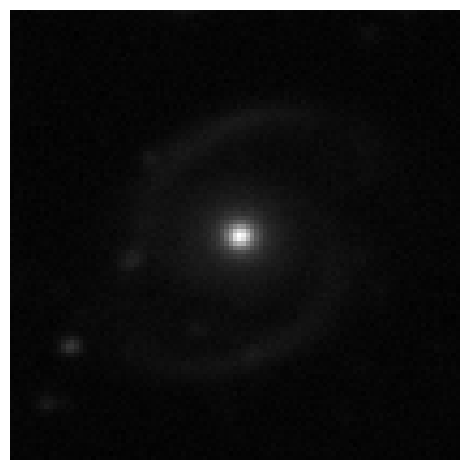

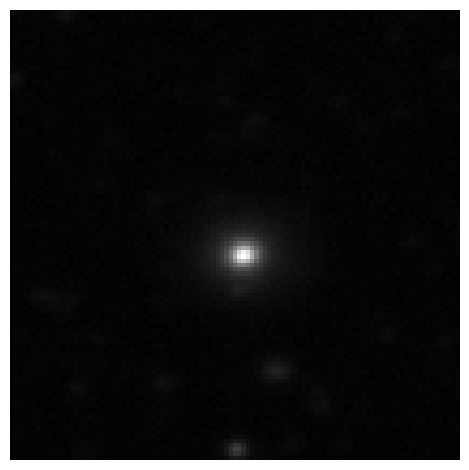

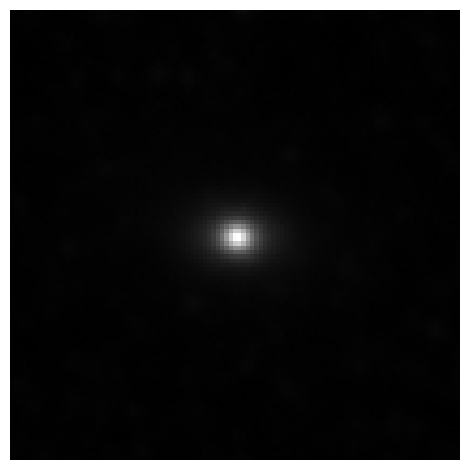

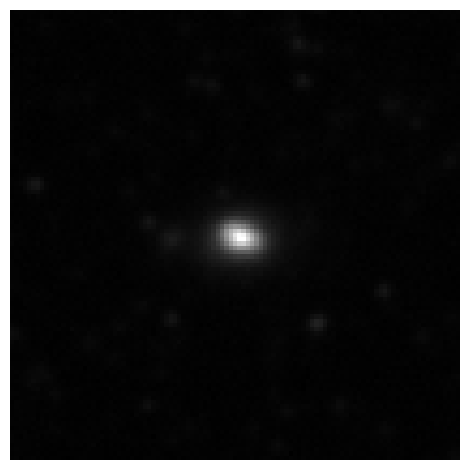

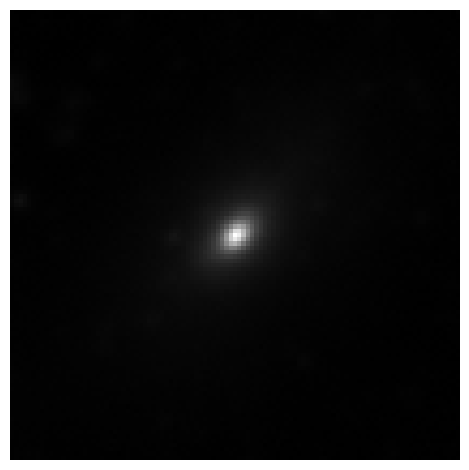

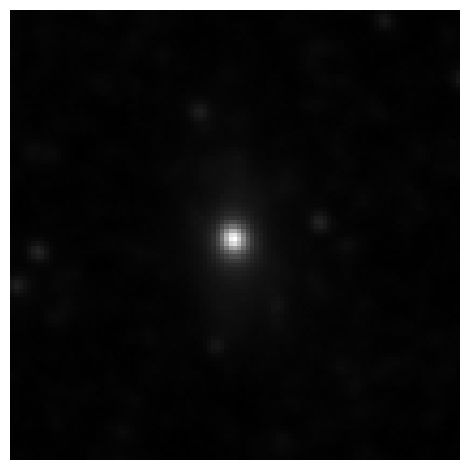

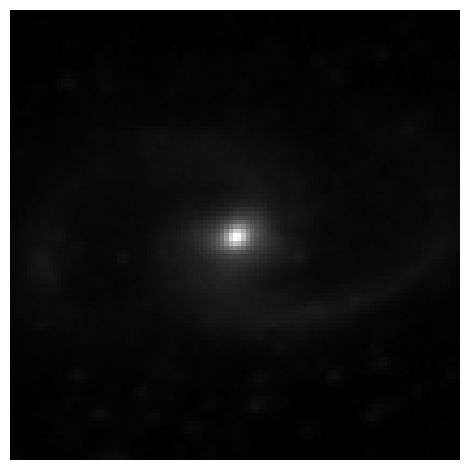

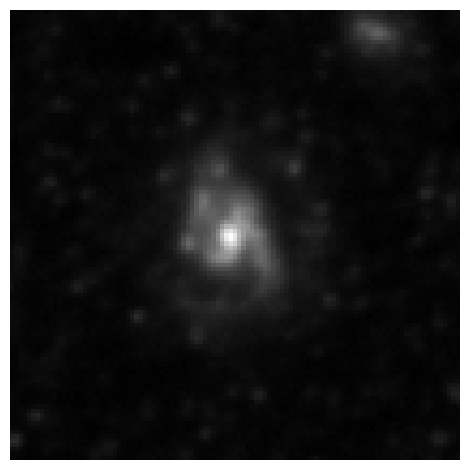

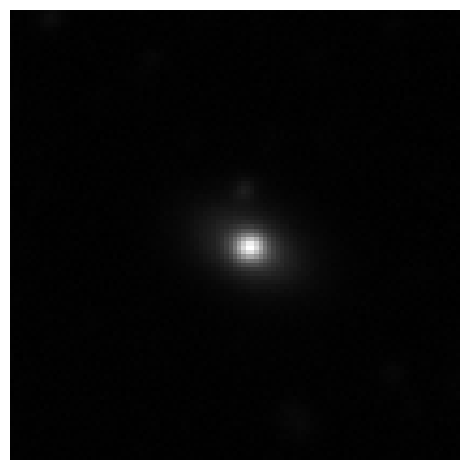

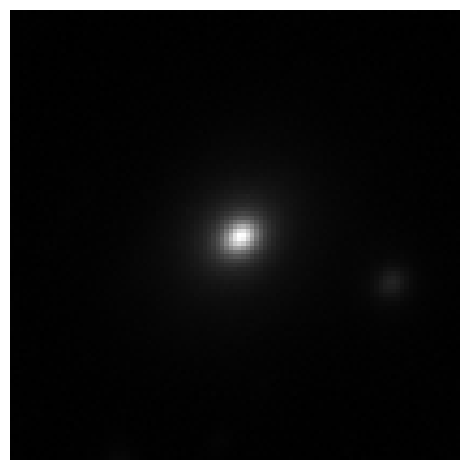

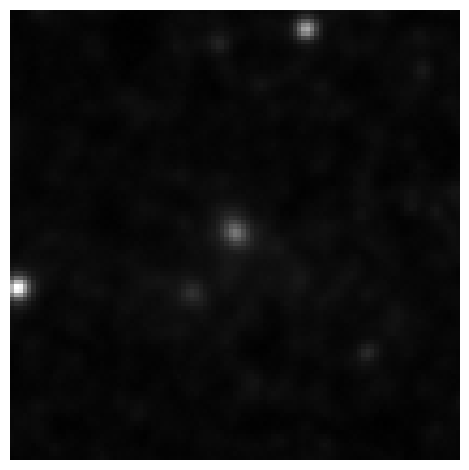

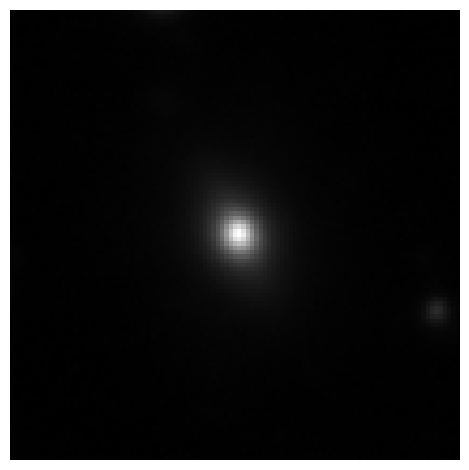

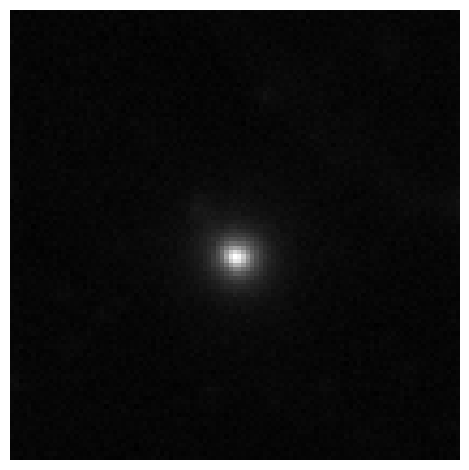

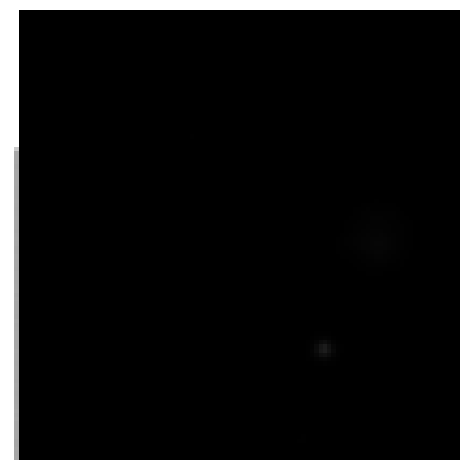

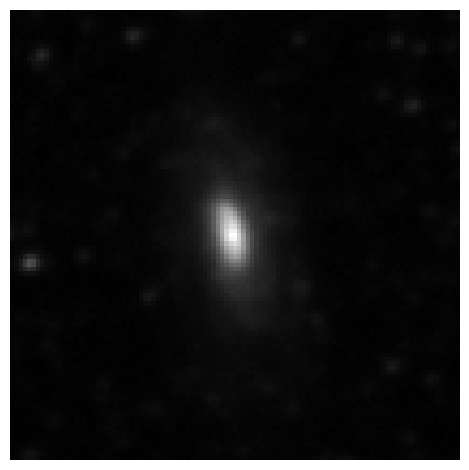

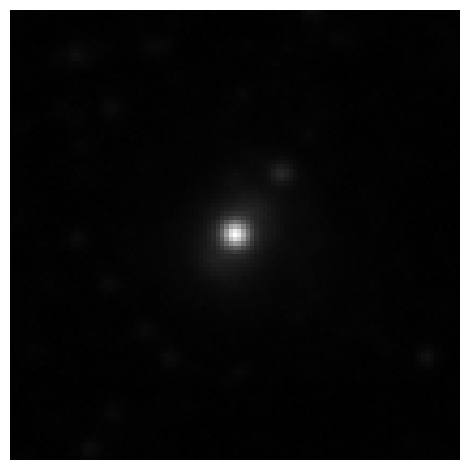

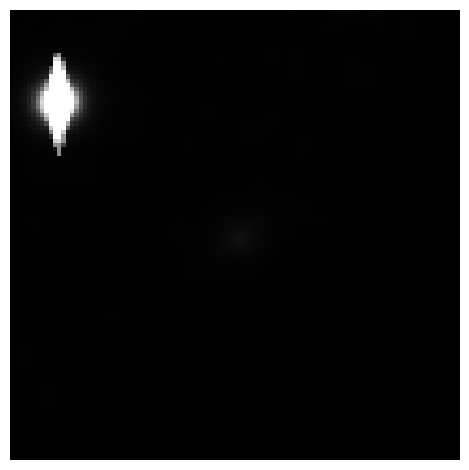

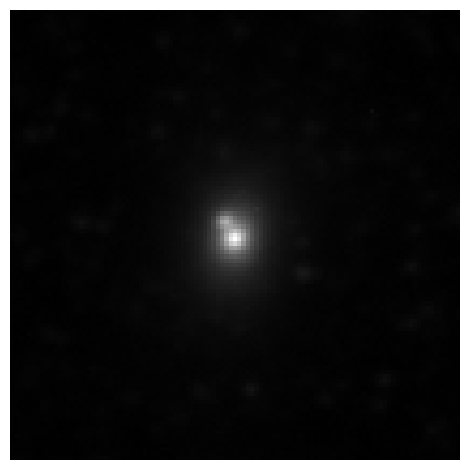

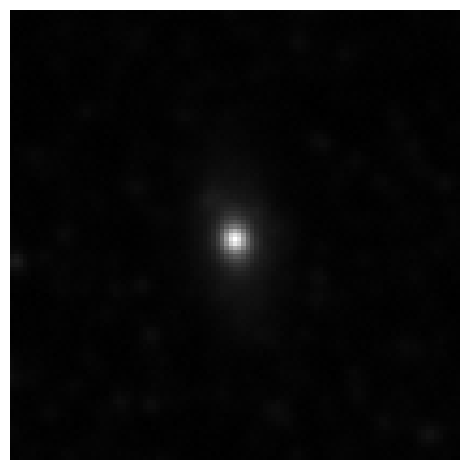

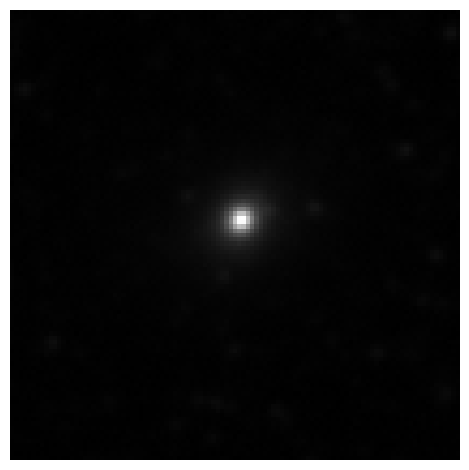

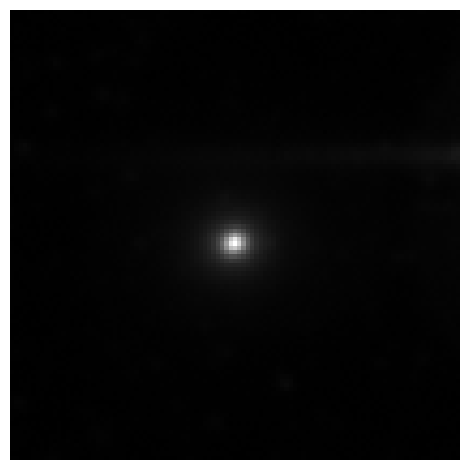

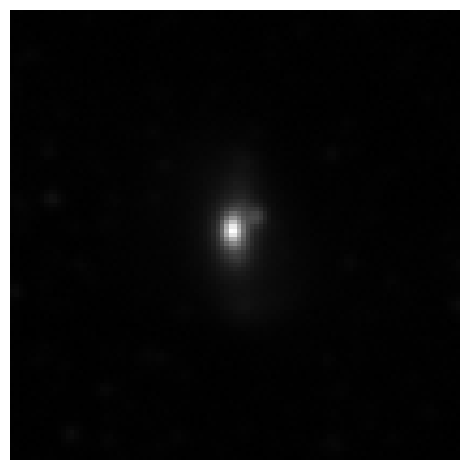

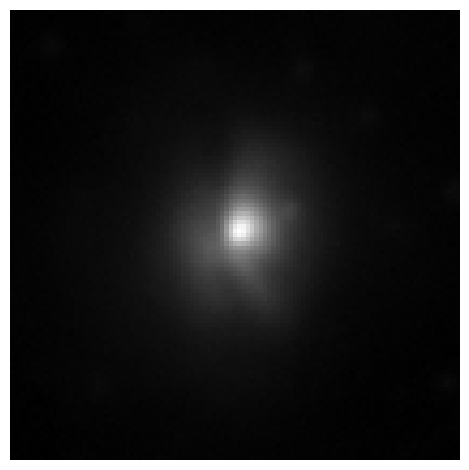

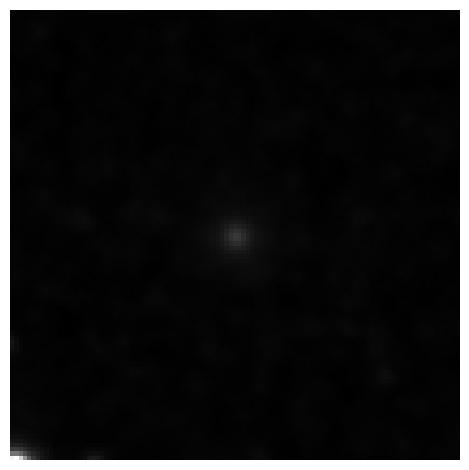

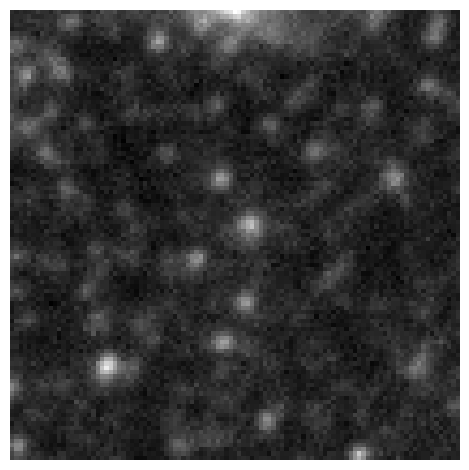

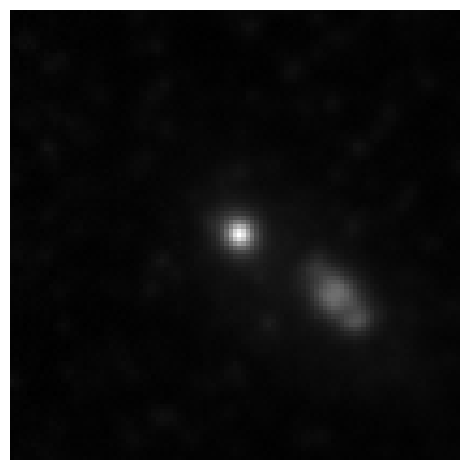

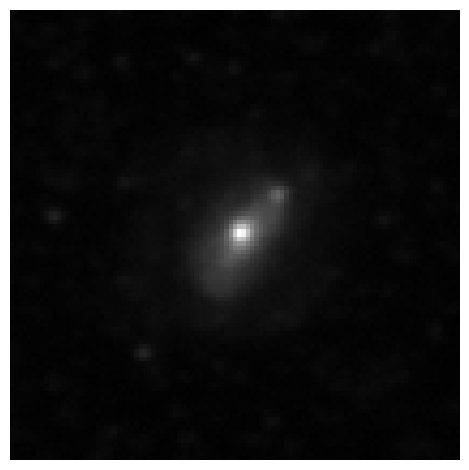

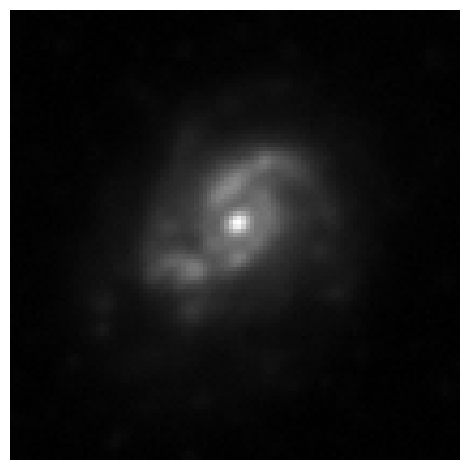

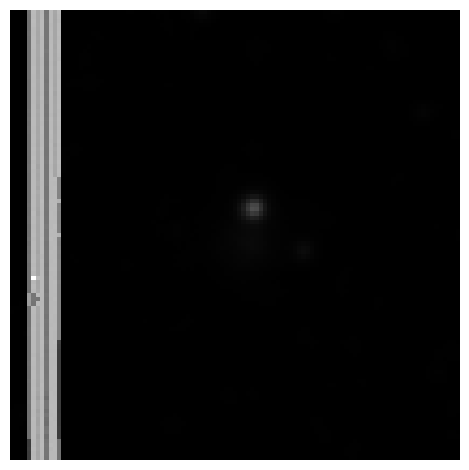

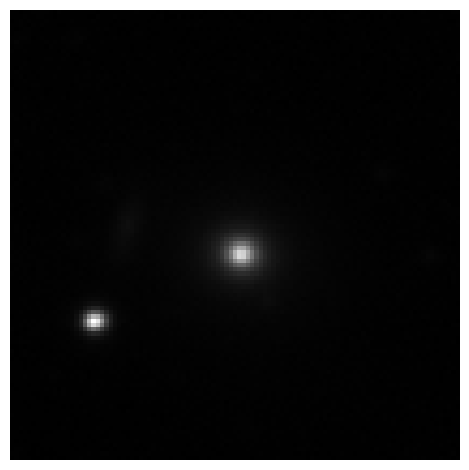

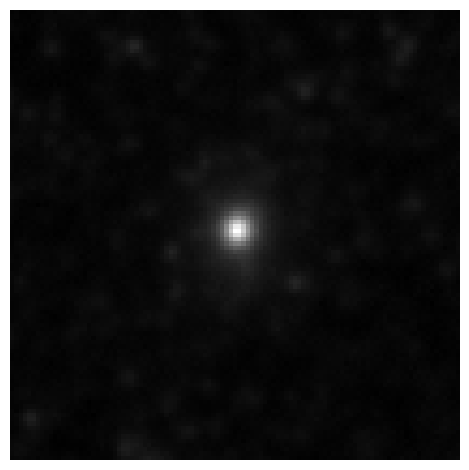

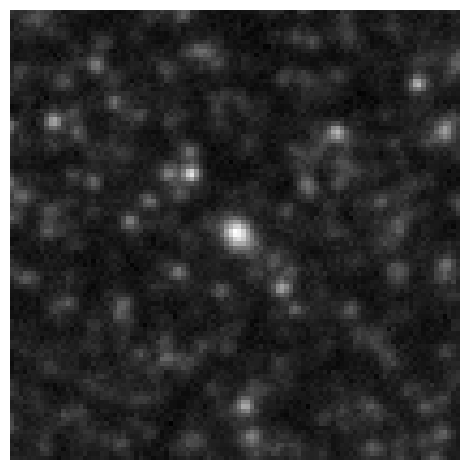

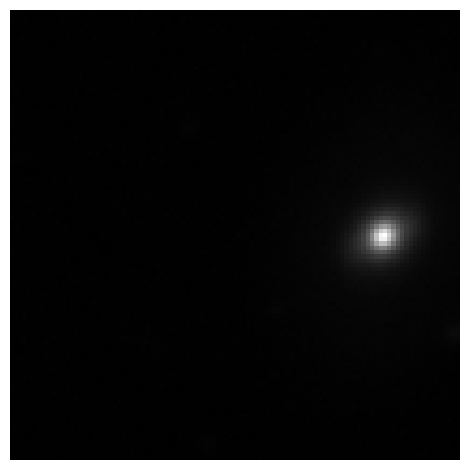

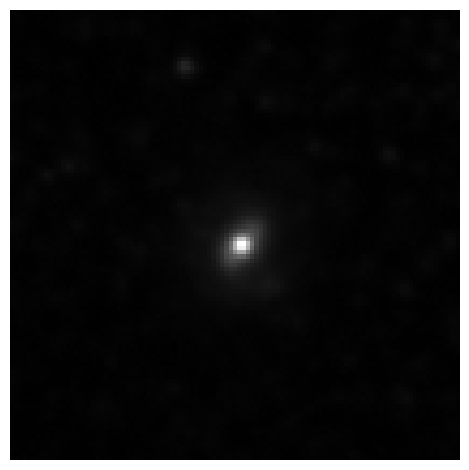

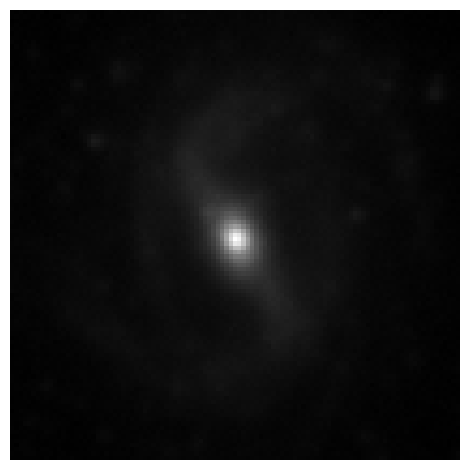

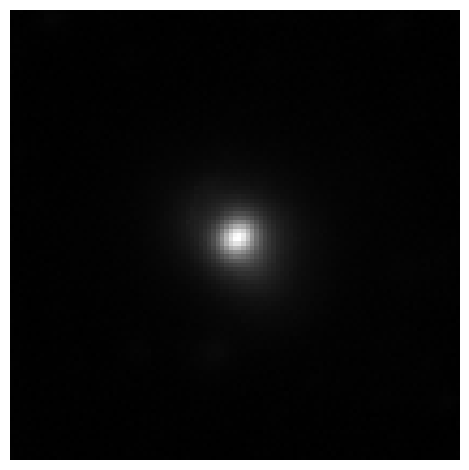

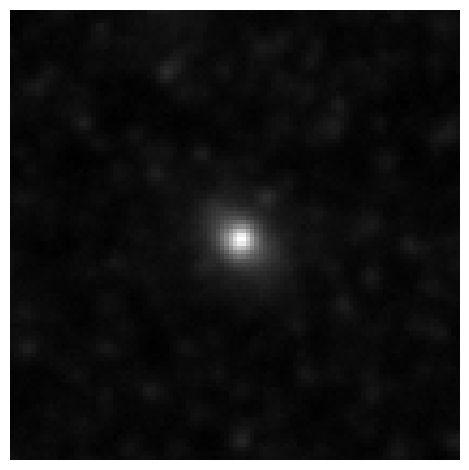

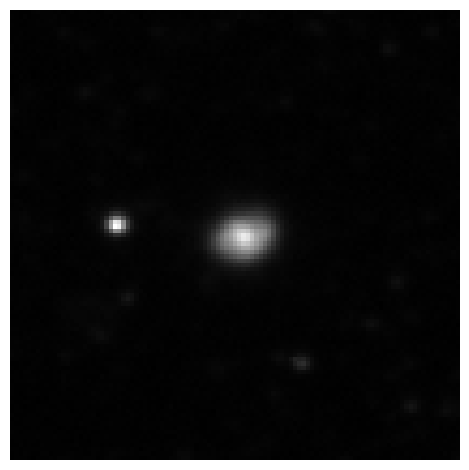

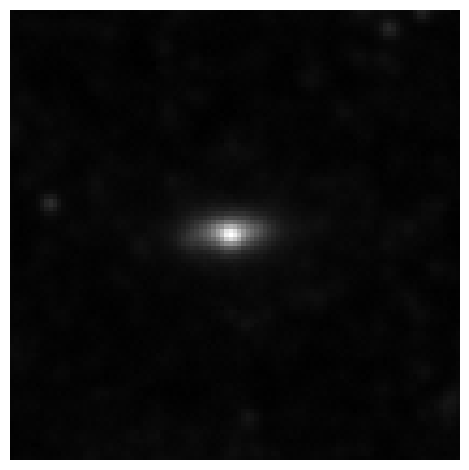

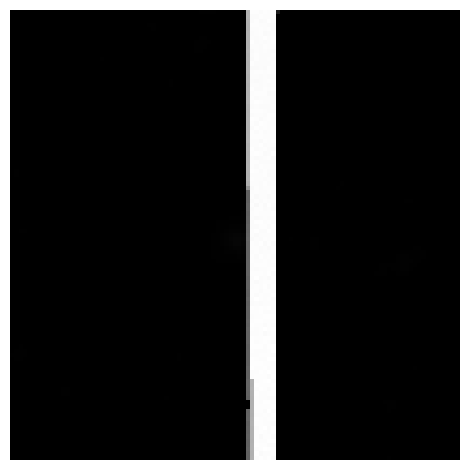

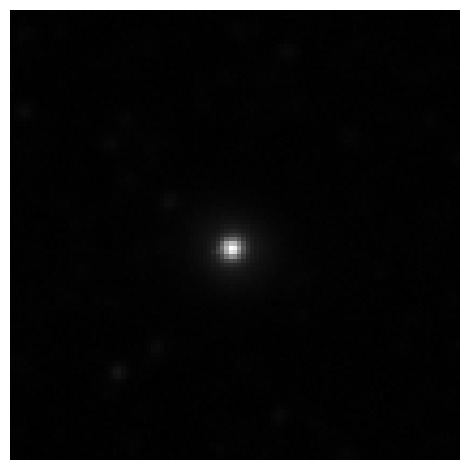

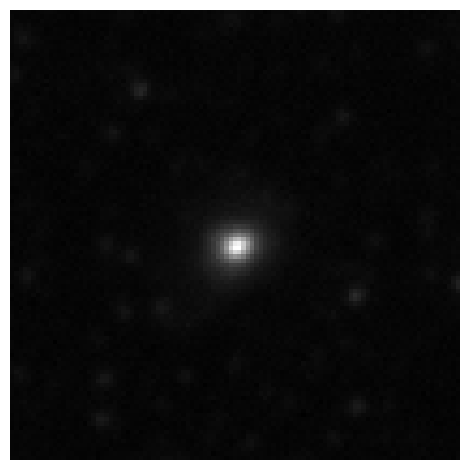

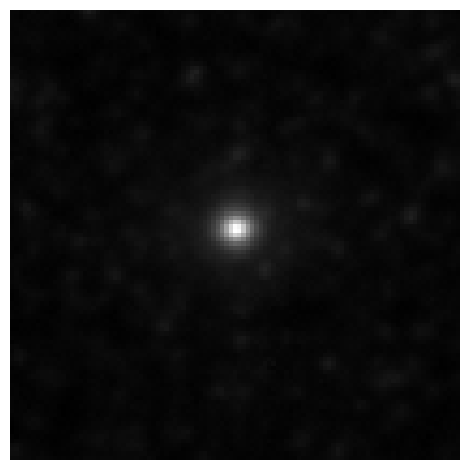

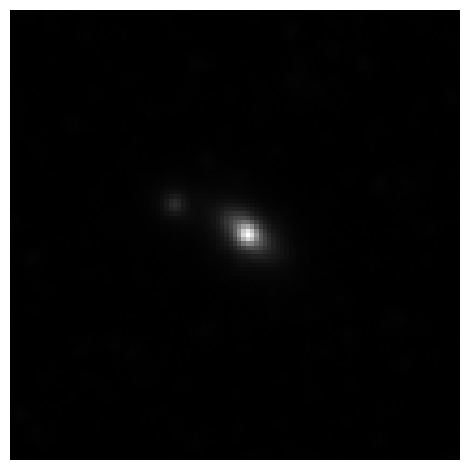

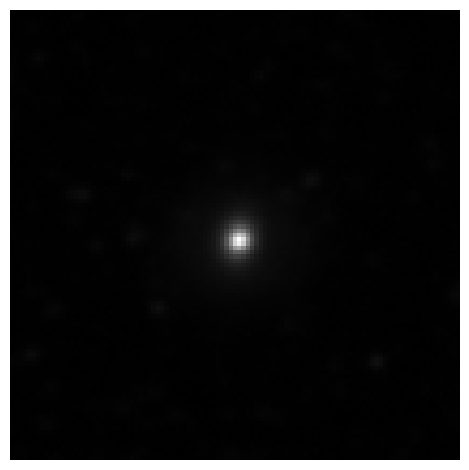

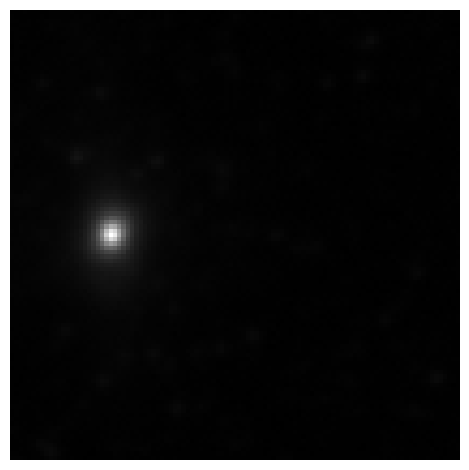

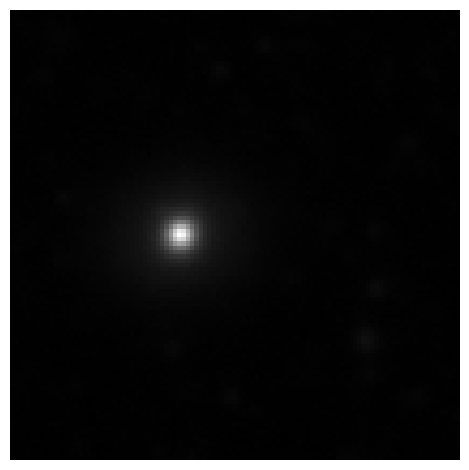

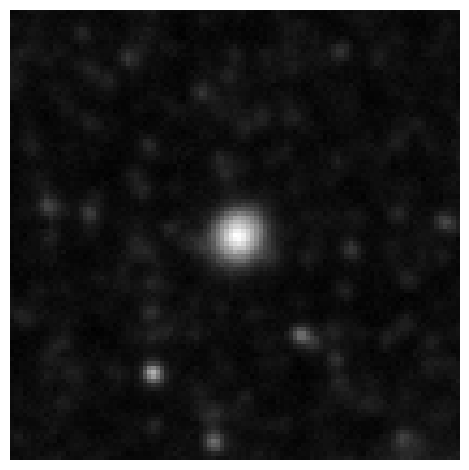

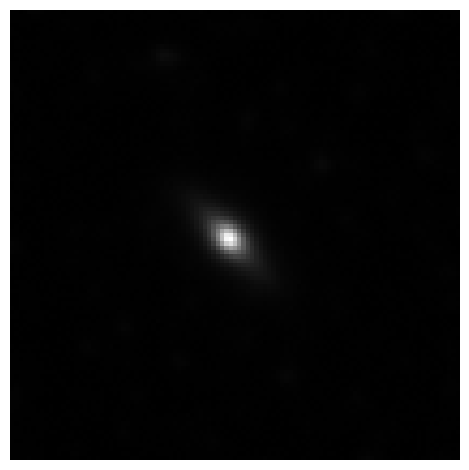

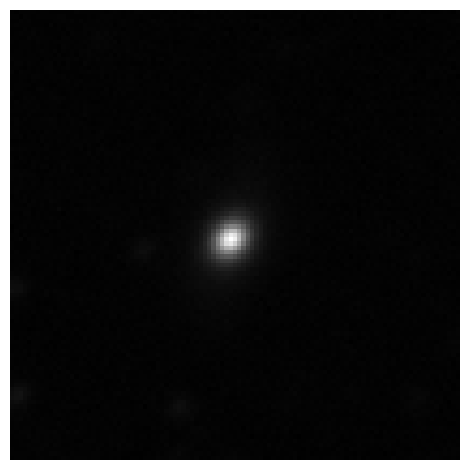

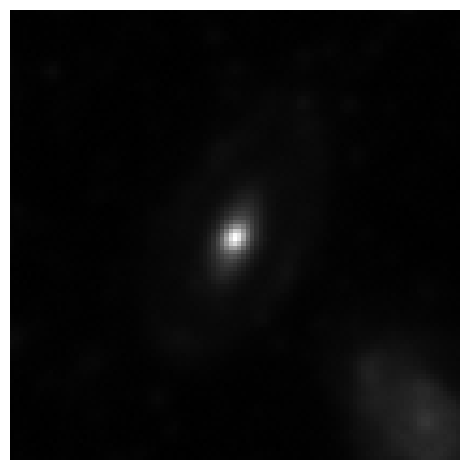

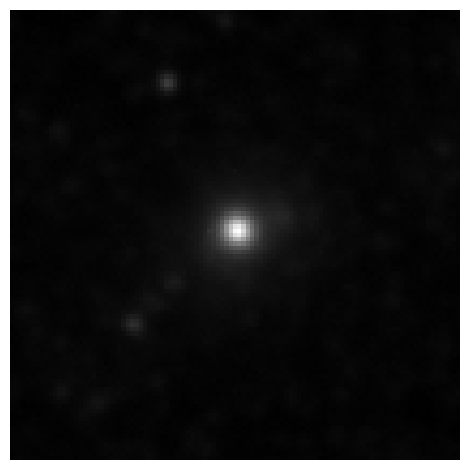

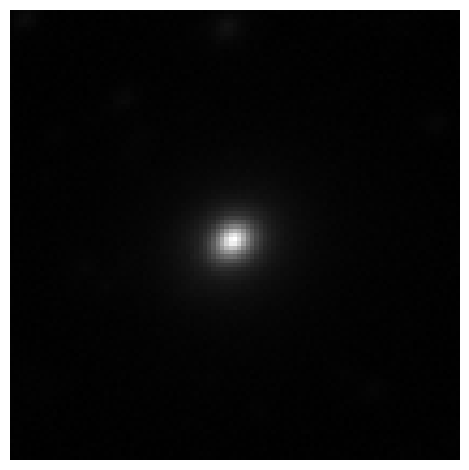

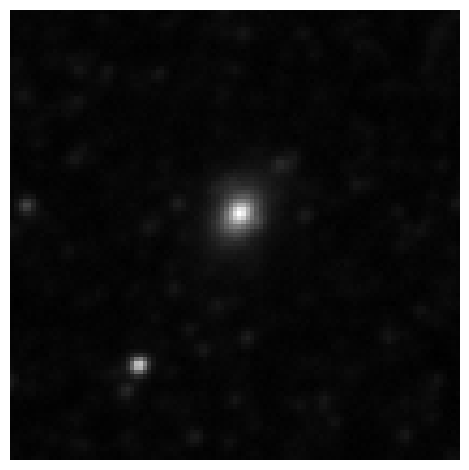

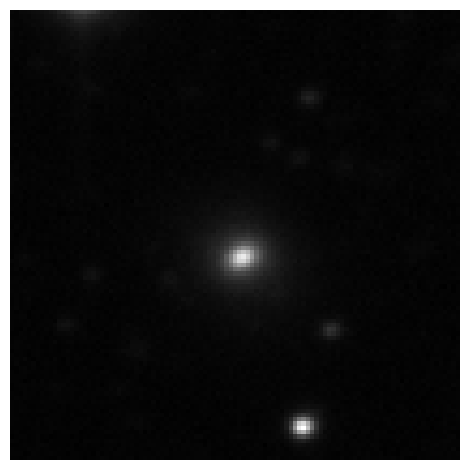

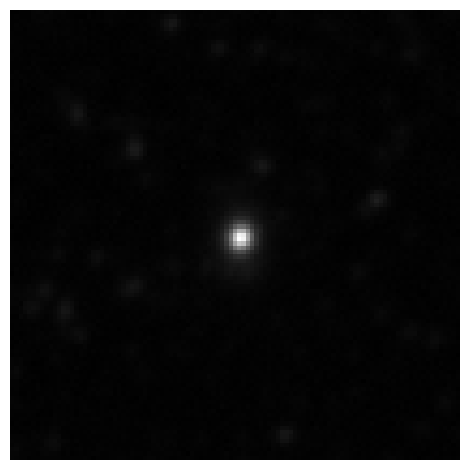

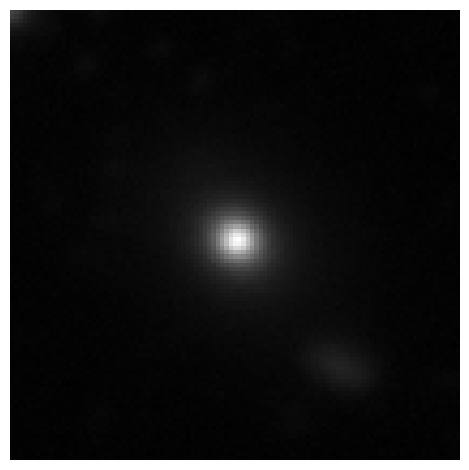

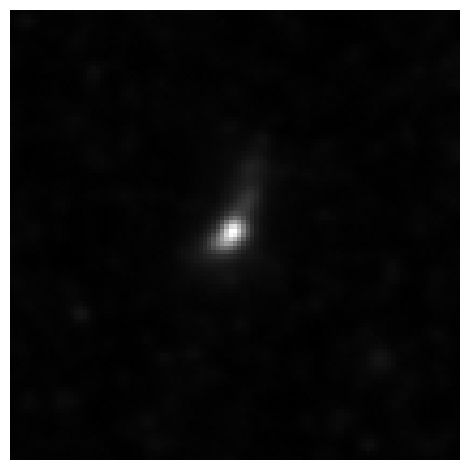

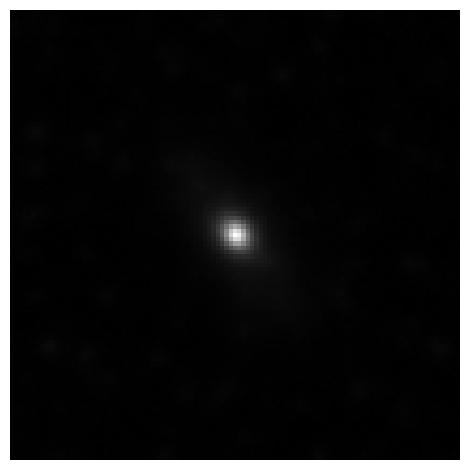

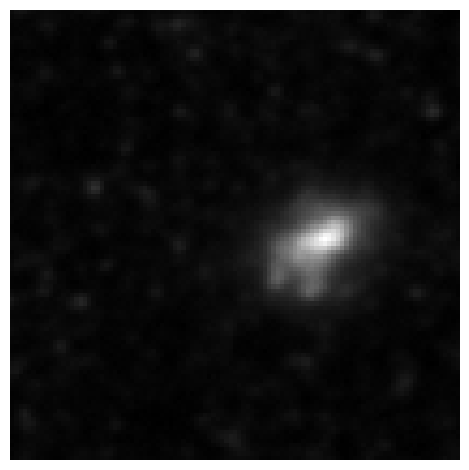

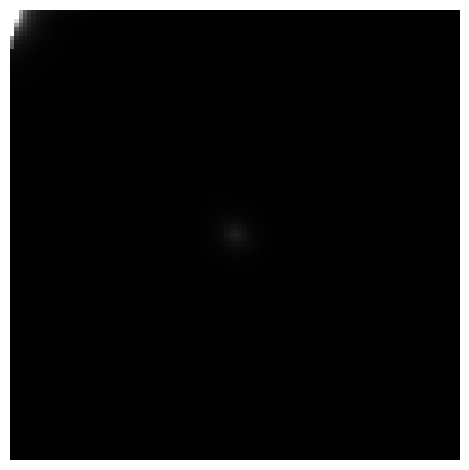

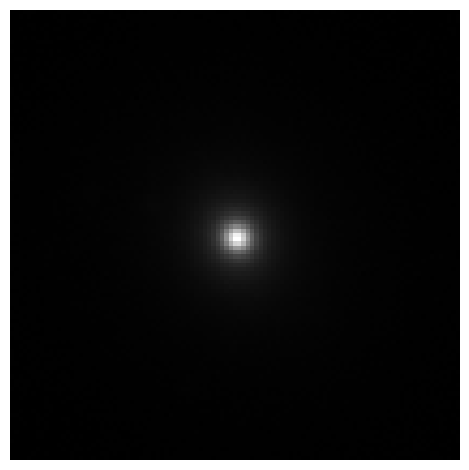

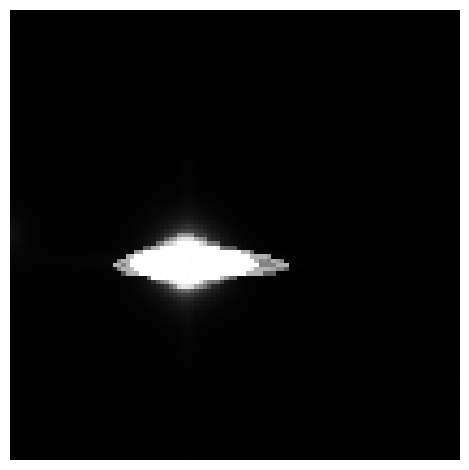

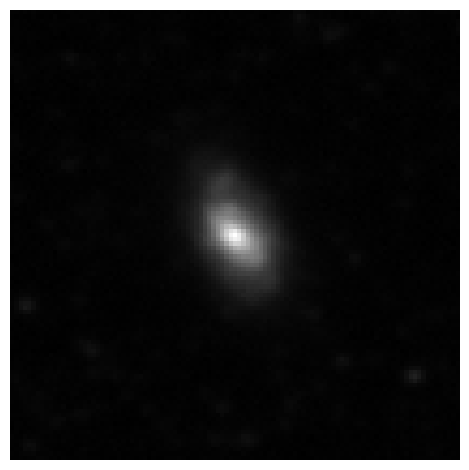

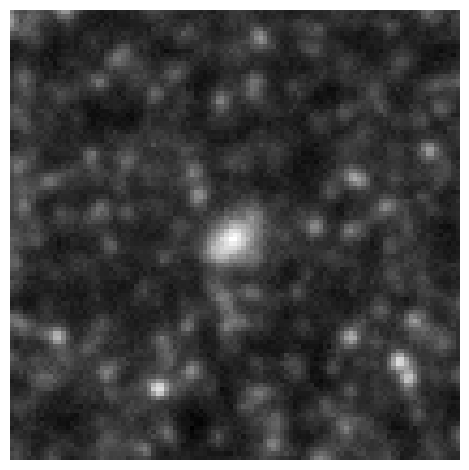

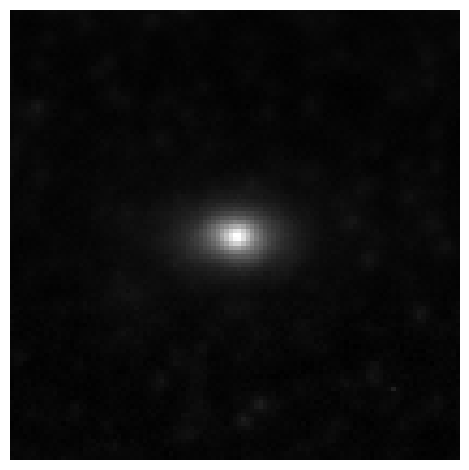

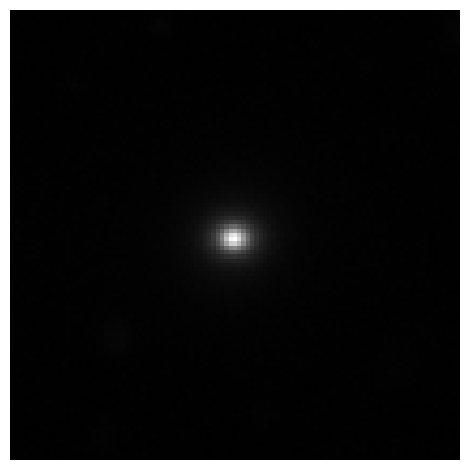

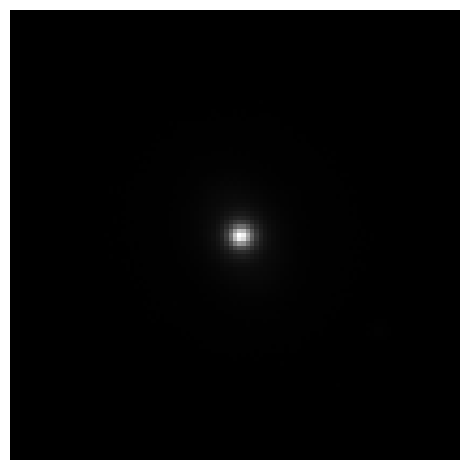

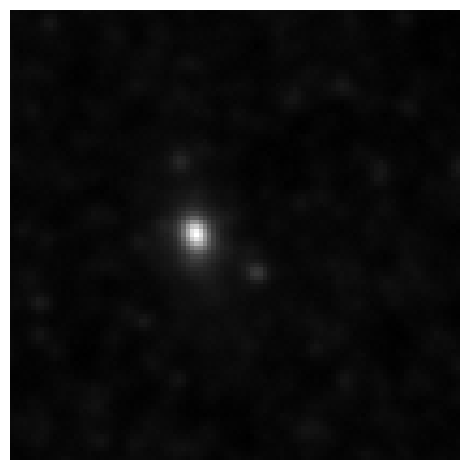

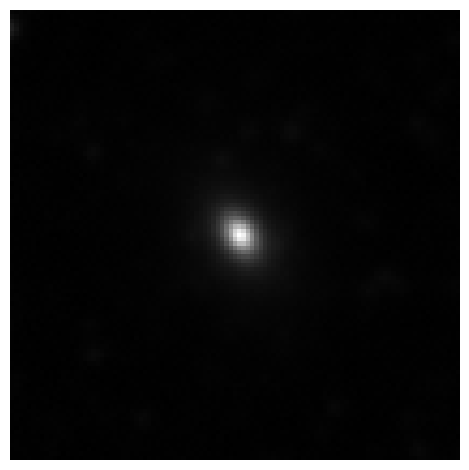

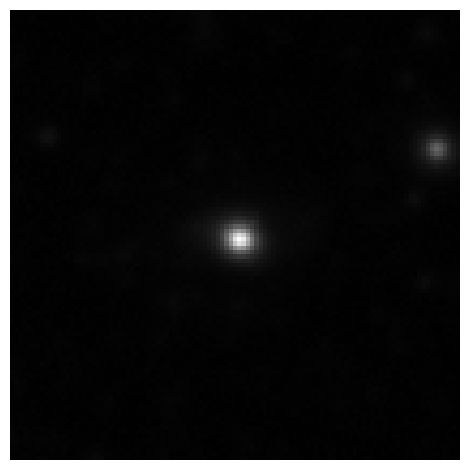

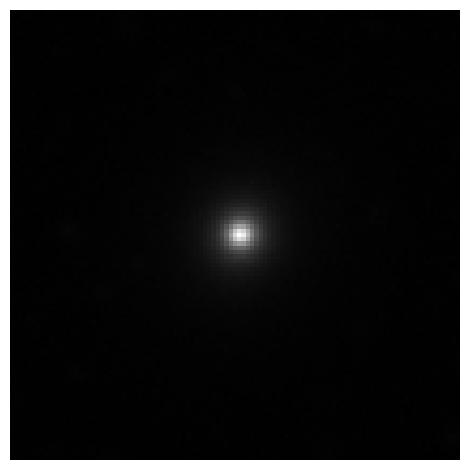

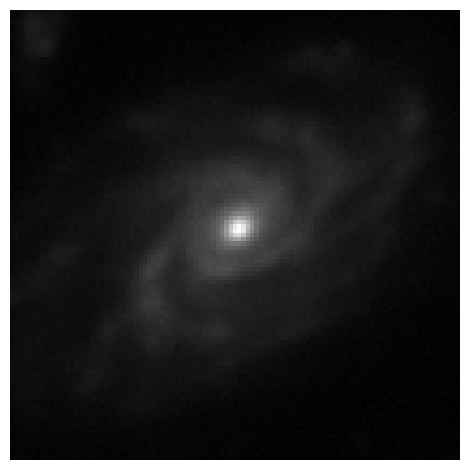

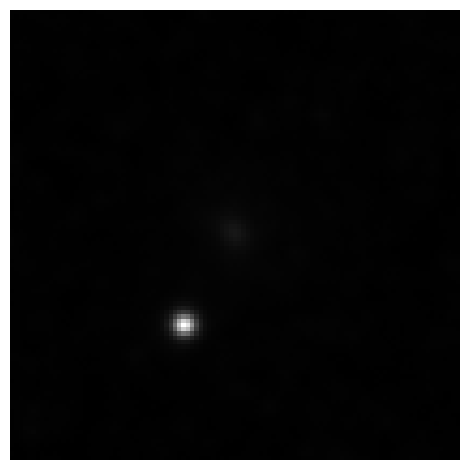

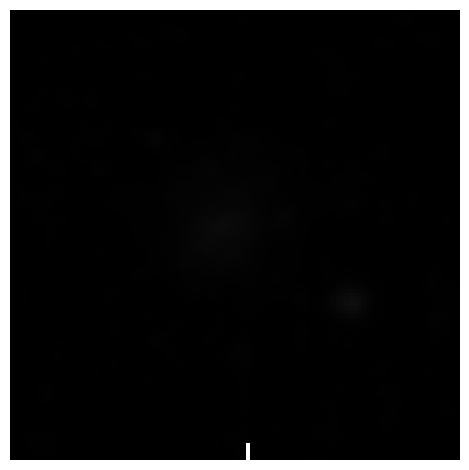

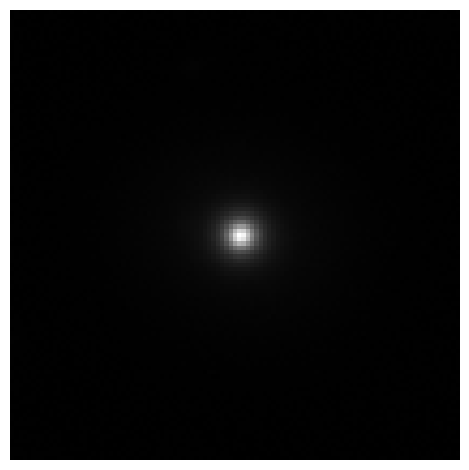

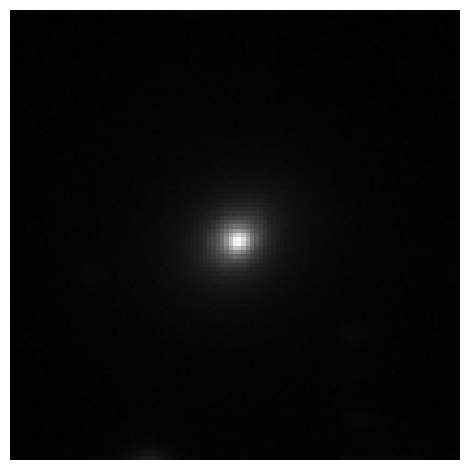

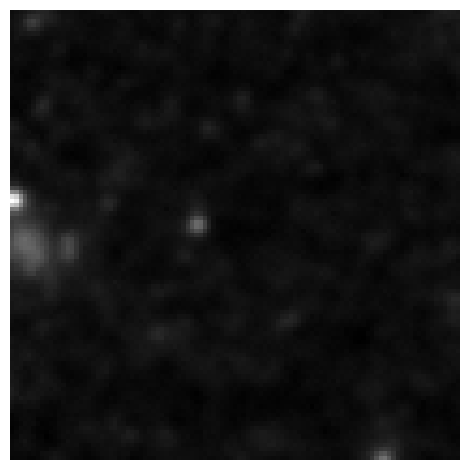

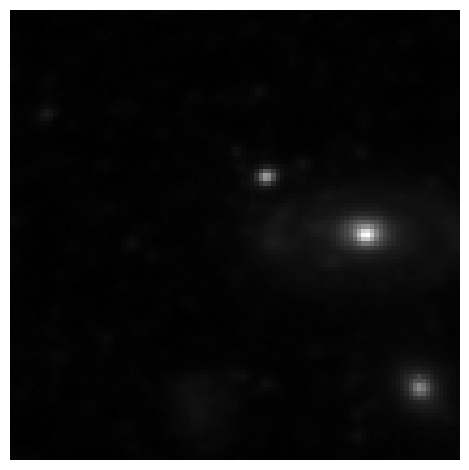

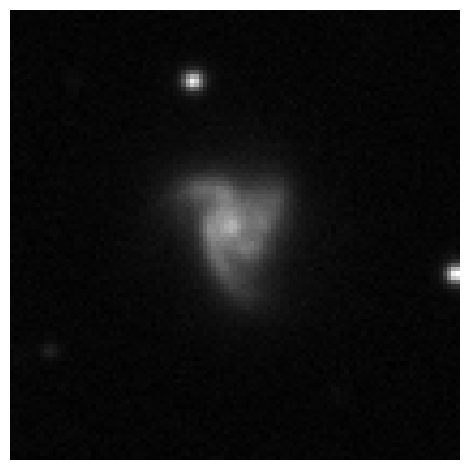

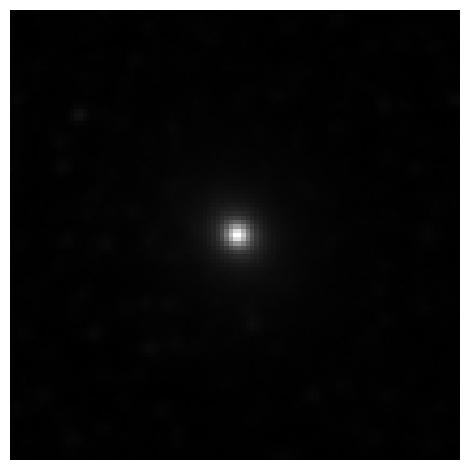

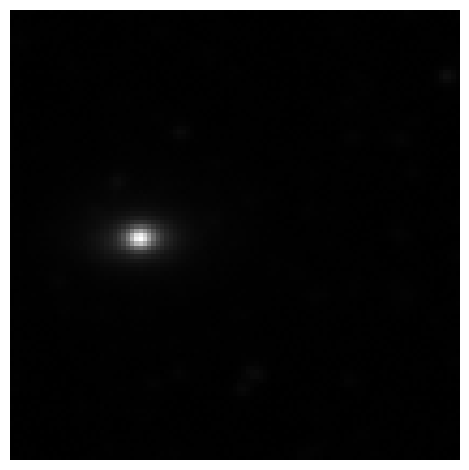

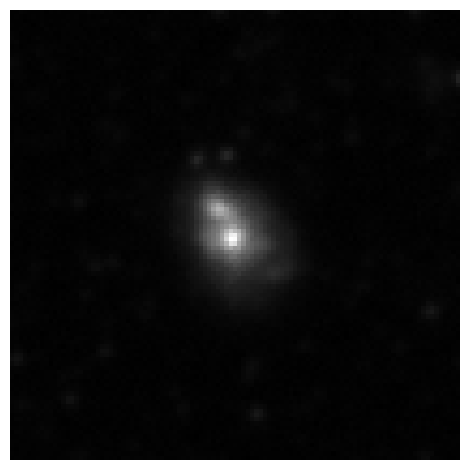

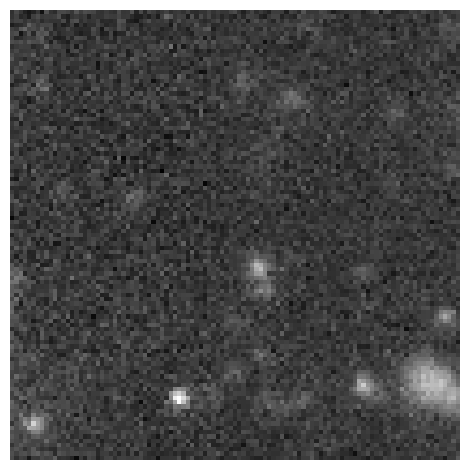

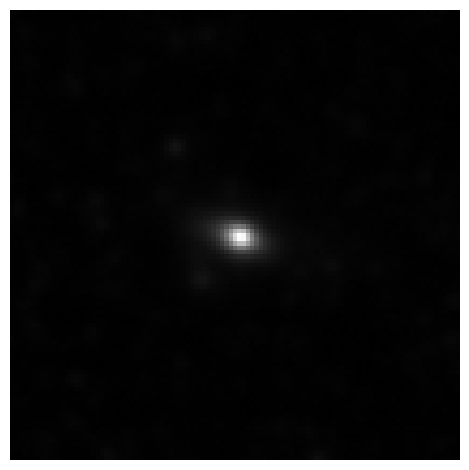

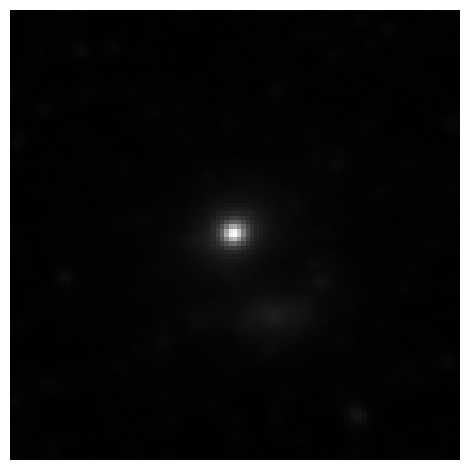

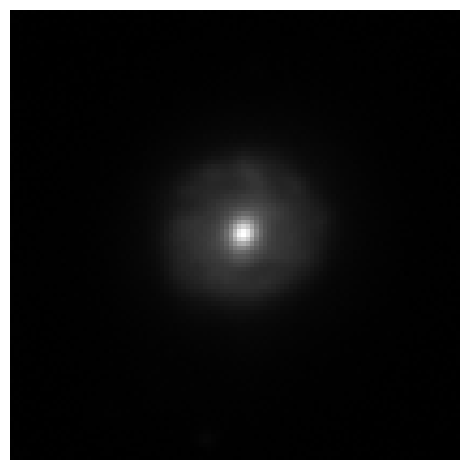

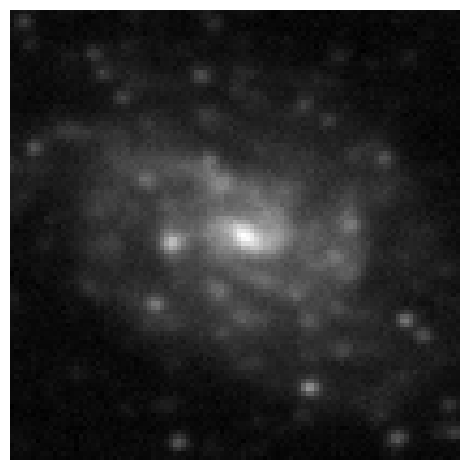

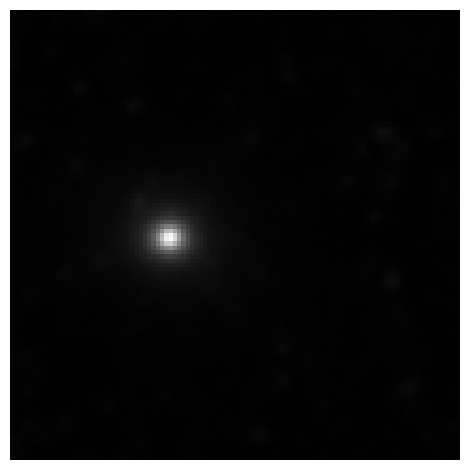

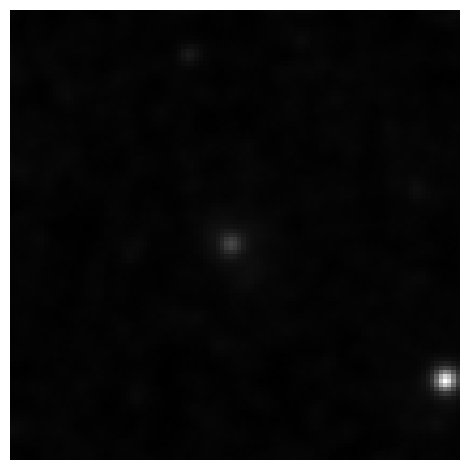

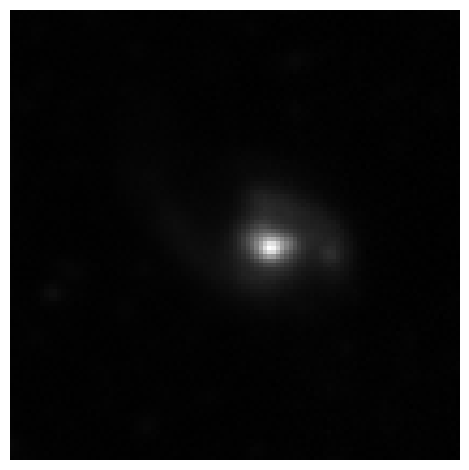

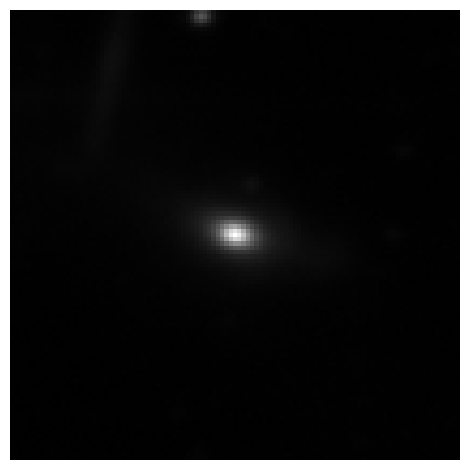

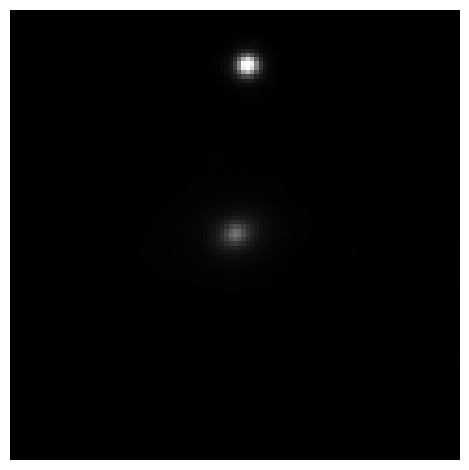

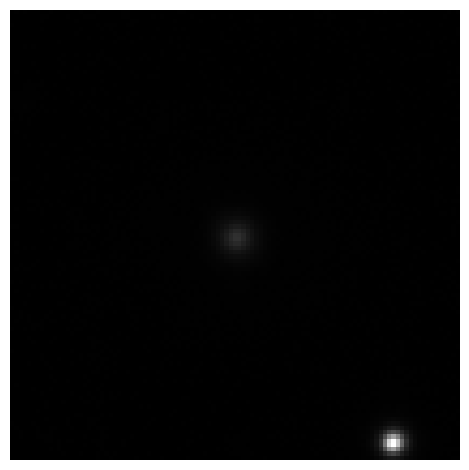

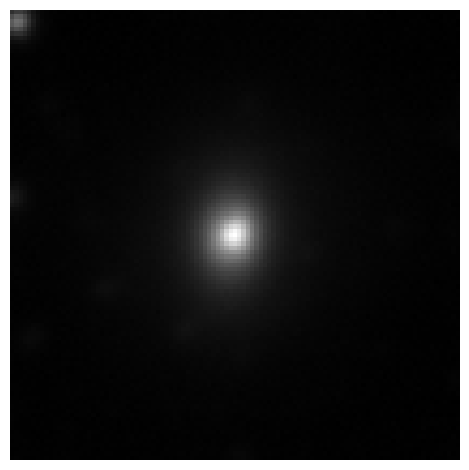

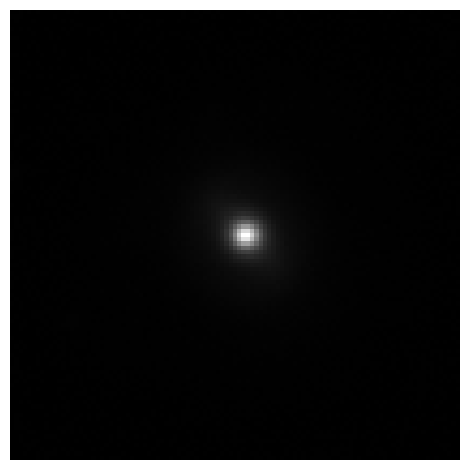

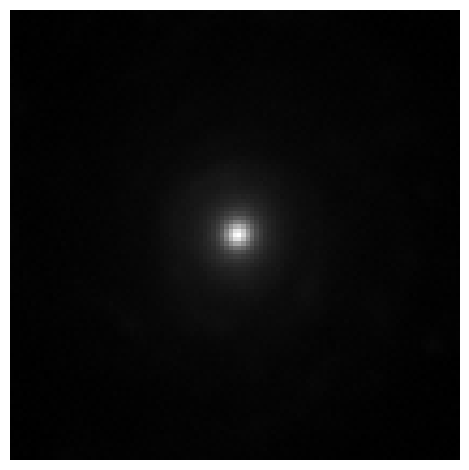

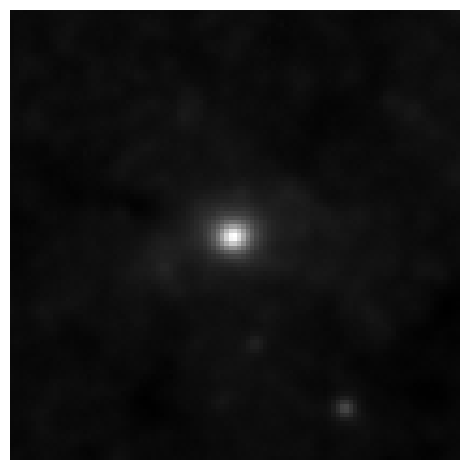

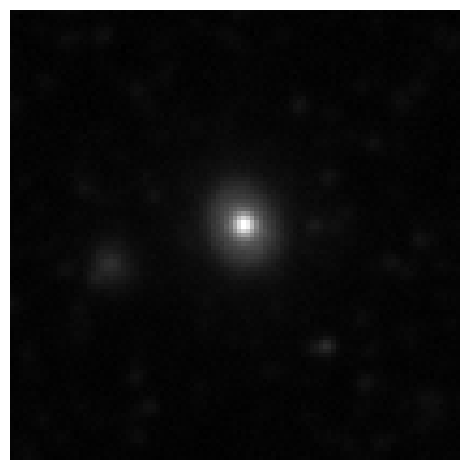

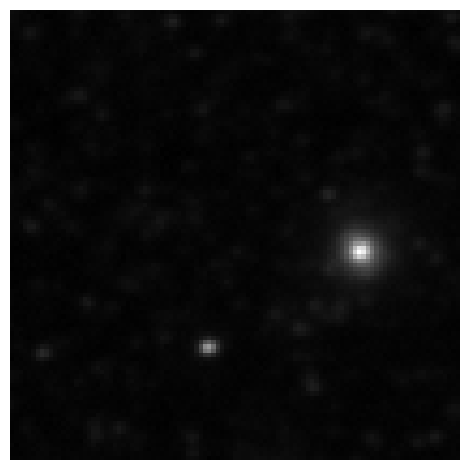

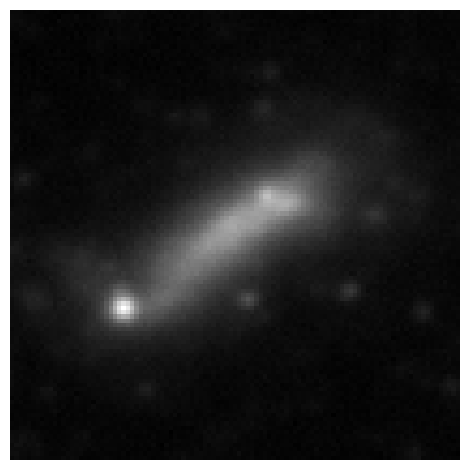

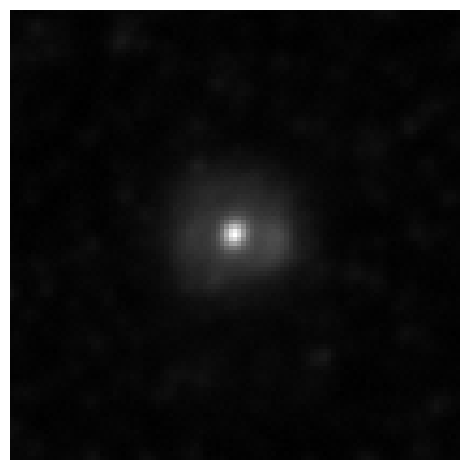

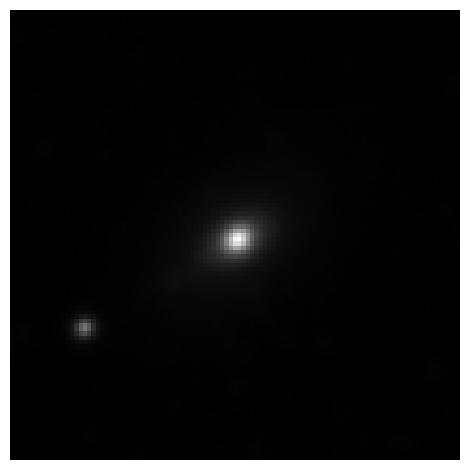

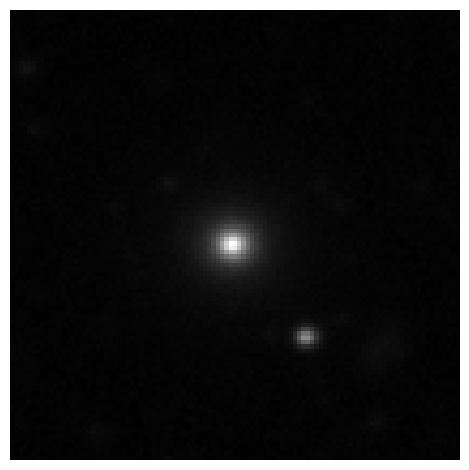

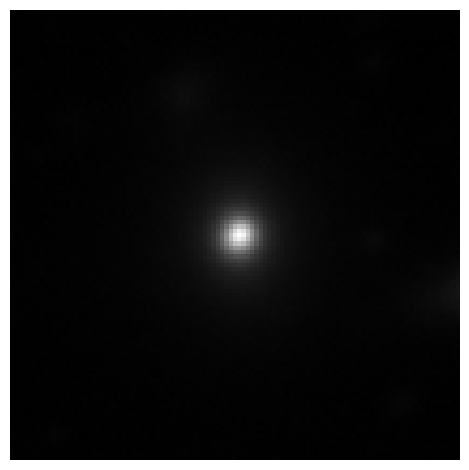

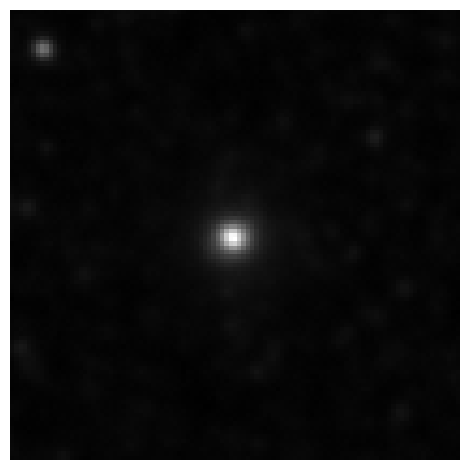

In [89]:
# Combine images
#images = np.concatenate((gcimages_1, gcimages_2, galaxyimages_1, galaxyimages_2,wanghaloimages, wangcentreimages, syntheticgcimages), axis=0)
images = np.concatenate((gcimages_1,galaxyimages_1), axis=0)

for img in images:
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Combine labels
#image_bins = np.concatenate((gcimage_bins1, gcimage_bins2, galaxyimage_bins1,galaxyimage_bins2, wanghaloimage_bins, wangcentreimage_bins, syntheticgcimage_bins), axis=0)
image_bins = np.concatenate((gcimage_bins1, galaxyimage_bins1), axis=0)

Split data into training and testing data 

In [91]:
#Use train_test_split to create training and testing data, with balanced image bins
X_train, X_temp, y_train, y_temp = train_test_split(
    images, image_bins, test_size=0.5, random_state=10, shuffle=True, stratify=image_bins
)

# Split the test data into validation and testing data. 
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=16, shuffle=True, stratify=y_temp)

Create the agumentation generator

In [92]:
#Function to rotate the image 90 degrees
def random_rot90(img):
    k = np.random.randint(0, 4)
    return np.rot90(img, k)
# Define the ImageDataGenerator with horizontal shift and shear augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=random_rot90,
    height_shift_range=0.05,  # 5% vertical shift
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=True,  # Random vertical flip
    fill_mode='nearest')

Generate the amount of agumented images desired 

In [93]:
#Define the CNNs batch size
batch_size = 36
#Define the approximate no of training images desired post augumentation.
total_images = 4500
augmented_images = []
augmented_labels = []

# Number of batches required to reach the desired number of images
batches_needed = total_images // batch_size
# Create augmented images using the datagen.flow()
image_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)


# Loop over the generator and save the generated images
for i in range(batches_needed):
    img_batch, label_batch = next(image_generator) # Get the next batch of augmented images
    augmented_images.extend(img_batch)               # Add generated images to the list
    augmented_labels.extend(label_batch)  
     


Add the agumented images onto the oringinal training images

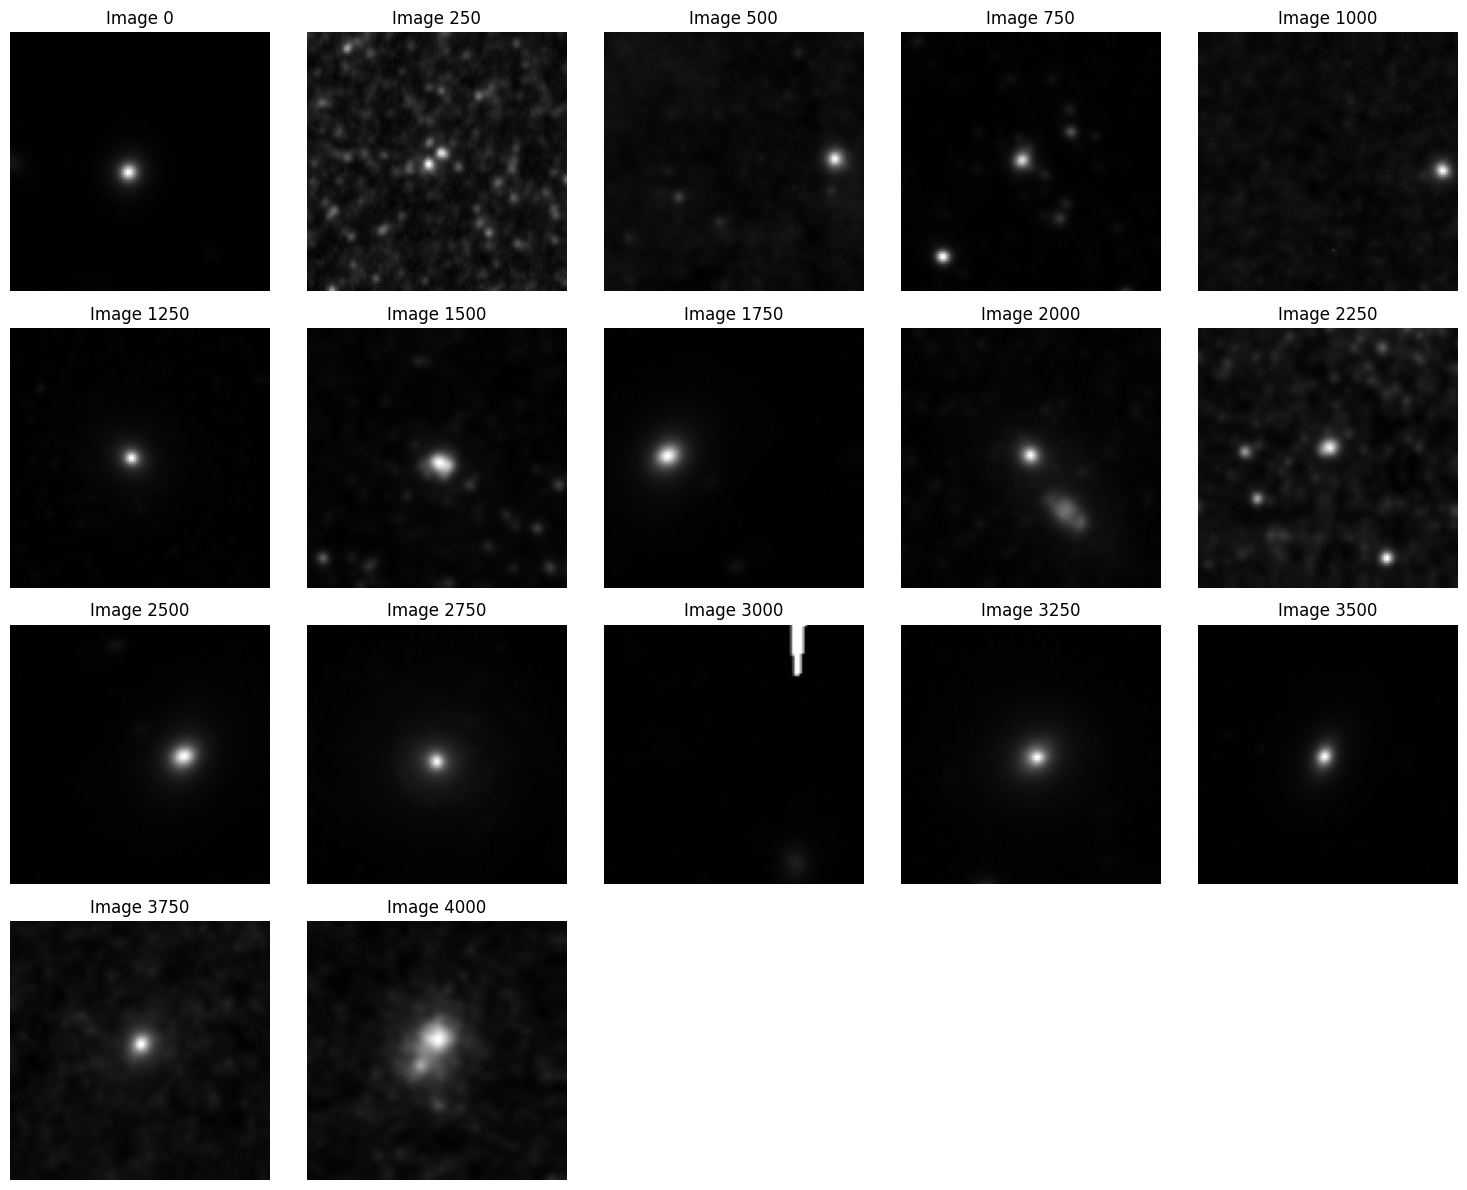

In [94]:
# Convert lists to numpy arrays to be used in datasets
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
expaneded_images = np.concatenate((augmented_images, X_train), axis=0)
expanded_image_bins = np.concatenate((augmented_labels, y_train), axis=0)

import matplotlib.pyplot as plt

# Assuming augmented_images is a numpy array of shape (num_images, height, width, 1)
# If your images are grayscale with a trailing dimension of 1, we can squeeze that out.
selected_images = augmented_images[::250]

n_images = selected_images.shape[0]
cols = 5  # Number of columns for the grid
rows = int(np.ceil(n_images / cols))

plt.figure(figsize=(15, 3 * rows))
for i, img in enumerate(selected_images):
    plt.subplot(rows, cols, i + 1)
    # If there's a trailing channel dimension (e.g., shape is (height, width, 1)), remove it.
    if img.ndim == 3 and img.shape[-1] == 1:
        img_to_show = np.squeeze(img, axis=-1)
    else:
        img_to_show = img
    plt.imshow(img_to_show, cmap='gray')
    plt.title(f'Image {i * 250}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Create the datasets needed 

In [ ]:
#create training, valadation and testing dataset.
dataset = tf.data.Dataset.from_tensor_slices((expaneded_images, expanded_image_bins))
dataset = dataset.shuffle(buffer_size=len(expaneded_images))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

#And dataset to validate efficacy recognising synthetics
syntetic_dataset = tf.data.Dataset.from_tensor_slices((testsyntheticgcimages, testsyntheticgcimage_bins))
syntetic_dataset = syntetic_dataset.batch(batch_size)
syntetic_dataset = syntetic_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Create the class weights to balance the network 

In [96]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

Create the model

In [98]:
# Keras model with 2 conv layers, max pooling, 1 dense layer and dropout. 
height = 105
width = 105
model = Sequential([
    tf.keras.Input(shape=(height, width, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

#Compile the model using the Adam optimiser, and using binary_crossentropy loss to get a Recall metric.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1),
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall()] 
)

Wang et al model 

In [77]:
height = 56
width = 56
model = Sequential([
tf.keras.Input(shape=(height, width, 1)),
tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation='softmax')  
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1),
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall()] 
)

Evaluate the model

In [99]:
model.fit(dataset, epochs=18, validation_data=val_dataset, class_weight = class_weights)

#evaluate model on unseen test data
test_loss, test_acc, test_recall = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")

#Evalulate model on unseen synthetic data
test_loss, test_acc, test_recall = model.evaluate(syntetic_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Epoch 1/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6349 - loss: 1.0880 - recall_12: 0.6298 - val_accuracy: 0.6800 - val_loss: 4.3378 - val_recall_12: 0.8000
Epoch 2/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7280 - loss: 0.7043 - recall_12: 0.7220 - val_accuracy: 0.7900 - val_loss: 5.6740 - val_recall_12: 0.8000
Epoch 3/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7400 - loss: 0.7162 - recall_12: 0.7356 - val_accuracy: 0.8000 - val_loss: 6.3774 - val_recall_12: 0.8000
Epoch 4/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7677 - loss: 0.6523 - recall_12: 0.7486 - val_accuracy: 0.7700 - val_loss: 7.9310 - val_recall_12: 0.7200
Epoch 5/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7676 - loss: 0.6999 - recall_12: 0.7617 - val_accuracy: 0.7500 - val_loss: 8.2018 - val_recall_12: 0.6800
Epoch 6/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7727 - loss: 0.6816 - recall_12: 0.7637 - val_accuracy: 